# Section 1 Libraries and data

In [34]:
#!pip install poetry
#python 3(ipkernel)

In [33]:
#!pip install pystan==2.19.1.1
#!pip install numpy==1.21.1
#!pip install pandas==1.1.5
#!pip install matplotlib==3.4.3
#!pip install holidays==0.11.2
#!pip install fbprophet==0.7.1
#!pip install scikit-learn==0.24.2

In [35]:
#libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric #📒 for cross validation
from sklearn.model_selection import ParameterGrid #for parameter tuning

import warnings
warnings.simplefilter('ignore')

In [2]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [37]:
df.tail()

,ds,y,Christmas,Temperature,Marketing
2187,2020-12-27,685.915026,0,2.89,38.674
2188,2020-12-28,998.051170,0,8.83,166.712
2189,2020-12-29,847.123399,0,3.48,161.865
2190,2020-12-30,857.521043,0,5.97,179.634
2191,2020-12-31,783.891494,0,8.22,149.221


In [3]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [4]:
#Date variable
df.ds = pd.to_datetime(df.ds,
                       format = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2187   2020-12-27
2188   2020-12-28
2189   2020-12-29
2190   2020-12-30
2191   2020-12-31
Name: ds, Length: 2192, dtype: datetime64[ns]

# Section 2 Holidays

## Easter

In [5]:
#Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})

## Thanksgiving

In [6]:
#Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': dates,
                             'lower_window': -3,
                             'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


## Combining events

In [7]:
#Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [8]:
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature,Marketing


- We wont take Christmas into holidays but take it into seasonlity because Christmas is a recurring pattern in the data. Including Christmas as a holiday means that you explicitly model it as a separate component in Prophet, allowing the model to capture any unique patterns or effects associated with Christmas. This can be useful if you expect Christmas to have a distinct impact on your time series that is different from other seasonal patterns


# Section 3 Facebook Prophet model

### FB Prophet components
    Components                      Description
    1. Holidays                     Dataframe that we prepared
    2. Seasonality_mode             Multiplicative or additive
    3. Seasonality_prior_scale      Strength of the seasonality
    4. Holiday_prior_scale          Larger values allow the model to fit larger seasonal flucturations
    5. Changepoint_prior_scale      Does the Trend change easily?
    
## FB model

### Holidays
Starting with the default value for the components, then fine-tuning it
- holidays_prior_scale = 10: holidays are given a prior impact that is 10 times larger than the other seasonality components.
- seasonality_prior_scale = 10: the overall strength of the seasonality components in the model
- changepoint_prior_scale = 0.05: the strength of historical data in detecting and accommodating changepoints.


### Seasonality
- In this case, the seasonality could refer to any repeating patterns or effects related to Christmas, temperature variations, or marketing activities. Prophet can automatically detect and model such seasonal patterns based on the time series data provided.

In [9]:
#Holidays
m = Prophet(holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, 
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)

#Seasonality
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6059.01    0.00952847       385.353           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6067.9    0.00217078       340.229           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.34    0.00157512       181.097      0.1635      0.7422      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       6071.41   7.41906e-05       181.896   5.936e-07       0.001      478  LS failed, Hessian reset 
     399       6072.55   0.000291952       183.662      0.5253      0.5253      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6073.49   0.000204316    

43   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       6073.68   0.000101351       68.4837       0.556           1      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     663       6073.81   8.07383e-08       64.8346      0.1742      0.1742      865   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


- For Train-Test Split, save at least half of the year for test set

In [10]:
#Check how many observations
df.shape[0] - 180 

2012

# Section 4 Cross-validation: Rolling Forecast

📒 The cross_validation function has several parameters that allow you to control the behavior of the cross-validation process. Here are the main parameters:

1. model: This parameter specifies the Prophet model instance that will be used for cross-validation. It should be an instance of the Prophet class. ***m***

2. horizon: This parameter specifies the forecast horizon, i.e., the number of steps to be forecasted into the future for each cutoff point. It should be a string representing a time duration. The time series data will be divided into multiple training and testing sets, with ***each testing set consisting of 31 days of data***.

3. period: This parameter specifies the spacing between cutoff points. It determines how often the cross-validation is performed. The value of period should also be a string representing a time duration. ***The model will be trained on approximately 16 days of data***

4. initial: This parameter specifies the size of the initial training period. It is used to determine the first cutoff point in the time series. The value of initial should be a string that represents a time duration.

5. parallel: This parameter controls whether the cross-validation process will be executed in parallel. If set to "parallel", it uses the joblib library to parallelize the computation. If set to "dask", it uses Dask to parallelize the computation. By default, it is set to "sequential" for non-parallel execution.


***In this case, with a period of '16 days', the model will be trained on approximately 16 days of data and evaluated on the next 31 days. This rolling evaluation process will be repeated throughout the time series.***

In [11]:
df_cv = cross_validation(m,
                         horizon = '31 days',
                         period = '16 days',
                         initial = '2012 days', # specifies the size of the initial training period. 
                         parallel = 'processes')
df_cv.head()  

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5490df460>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5535.69    0.00262898       255.845      0.9338      0.9338      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5553.7    0.00155348       266.416           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5698.47    0.00414997       332.387           1           1      122   
    Iter      log prob 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5641.4    0.00822057       732.186           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5606.98    0.00165459       310.311      0.2965      0.8063      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5712.28    0.00229115       294.308      0.7198      0.7198      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5562.24    0.00072467        236.48           1   

     699       5723.99   0.000361782       131.668           1           1      917   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5862.54   0.000117298       121.855      0.5461      0.5461      728   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5770.55   0.000122434       70.8865      0.2028           1      780   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5668.9   0.000917751       80.6065      0.4758      0.4758      764   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        5821.4   5.64781e-06       71.5901      0.2551      0.2551      873   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     657       5770.57   2.34482e-05       88.1448   2.532e-07       0.001      889  LS failed, Hessian r

     407       5995.91    5.7673e-05       143.821   3.682e-07       0.001      535  LS failed, Hessian reset 
     499       5950.99    0.00122345       82.2525           1           1      637   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     467       5995.99     6.112e-06       80.5123   7.864e-08       0.001      660  LS failed, Hessian reset 
     599       5952.75    0.00125913       97.0466      0.6138      0.6138      757   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          5996   6.35594e-06        66.403           1           1      701   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     626        5953.1    6.9158e-05       163.881   4.454e-07       0.001      834  LS failed, Hessian reset 
     573       5996.04   0.000116444       111.915   1.411e-06       0.001      825  LS failed, Hessian reset 
     699       5953

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,606.840251,542.425502,677.986013,571.069531,2020-07-09
1,2020-07-11,721.627738,654.703542,785.268617,677.106981,2020-07-09
2,2020-07-12,636.544298,564.958695,695.440374,619.572774,2020-07-09
3,2020-07-13,768.686536,697.548193,833.993986,808.932621,2020-07-09
4,2020-07-14,636.135587,568.640351,701.386777,661.791644,2020-07-09


In [12]:
#Performance
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,4 days,2859.836497,53.477439,43.493818,0.059090,0.061596,0.800000
1,5 days,2850.159020,53.386881,44.621018,0.062346,0.064731,0.767742
2,6 days,3567.664891,59.729933,50.754243,0.070125,0.064731,0.703226
3,7 days,2831.816042,53.214810,43.143197,0.060808,0.060257,0.735484
4,8 days,2777.293913,52.700037,40.737325,0.056315,0.056583,0.764516


### Key Ideas: RMSE

MAE and RMSE are performance indicators for Regression modls. RMSE gives you insights into the average magnitude of the prediction errors, while MAPE provides insights into the relative percentage difference.
- MAPE: average percentage difference between the predicted and actual prices. 
more interpretable, but not good for visualization
- RMSE: assess the absolute deviation of your predicted prices from the actual prices.
Cannot interpretable, but show extreme values

In [36]:
#RMSE and MAPE
print("RMSE: ", round(performance_metrics(df_cv)["rmse"].mean(),1))
print("MAPE: ", 100 * round(performance_metrics(df_cv)["mape"].mean(), 3), "%")

RMSE:  53.4
MAPE:  5.800000000000001 %


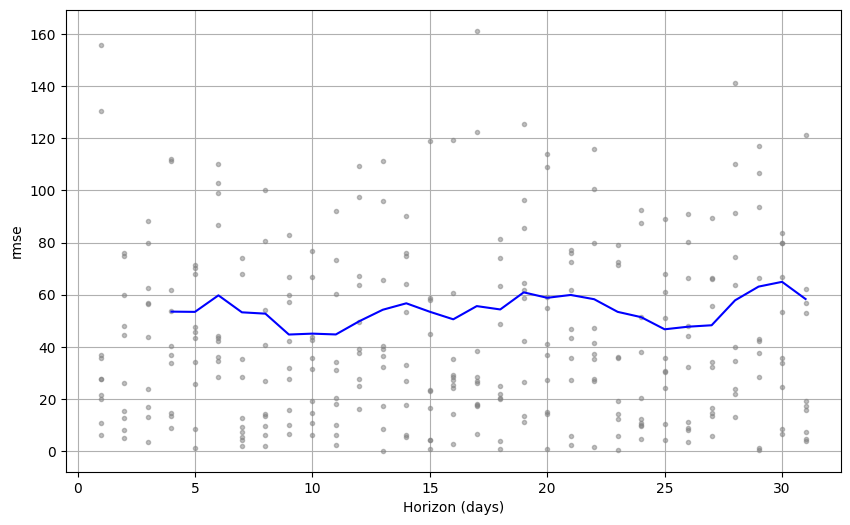

In [14]:
#plotting
plot_cross_validation_metric(df_cv, metric = 'rmse');

# Section 5 Parameter Tuning

## Parameter Grid

In [26]:
#Parameter Grid
param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
              'seasonality_prior_scale': [1, 5, 10, 20],
              'holidays_prior_scale': [5, 10, 20, 25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
list(grid)
#len(list(grid))

[{'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 1},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_s

## Tuning loop

In [23]:
#Store the results
rmse = []

#Loop
i = 1
for params in grid:
    print(f"{i} / {len(list(grid))}")

    #model
    m = Prophet(holidays = holidays,
            seasonality_mode = params['seasonality_mode'],
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
    m.add_regressor('Christmas')
    m.add_regressor('Temperature')
    m.add_regressor('Marketing')
    m.fit(df)
  
    #CV
    df_cv = cross_validation(m,
                        horizon = '31 days',
                        period = '16 days',
                        initial = '2012 days',
                        parallel = 'processes')

    #Measure the error and store the result
    error = performance_metrics(df_cv)["rmse"].mean()
    rmse.append(error)

    i += 1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526c1370>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       5701.36   0.000818558       1172.89   8.495e-07       0.001      117  LS failed, Hessian reset 
      99       5713.32    0.00420289       984.827           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       5713.91    0.00142203       1199.75   2.018e-06       0.001      187  LS failed, Hessian reset 
     137       5715.86   0.000635378       717.909   9.042e-07       0.001      272  LS failed, Hessian reset 
     199       5720.71    0.00119577        731.05           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       5721.59   6.79115e-05       634.337   9.769e-08       0.001      423  LS failed, Hessian reset 
     251       5721.61   1.16994e-06       537.698   1.657e-09   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5270.68    0.00373315       1097.47           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       5272.92    0.00165616       749.381   2.142e-06       0.001      162  LS failed, Hessian reset 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       5305.88   0.000405301       771.098   3.496e-07       0.001      118  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5326.87   0.000102882       614.382           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       5416.73    0.00044001       929.603   3.761e-07       0.001      191  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       5232.64   0.000118538       570.852   1.739e-07       0.001      252  LS failed, Hessian reset 
     251       5375.33    7.2563e-08       583.141      0.2796           1      326   
Optimization terminated normally: 
     299       5289.12   7.71208e-05       791.627           1           1      462   
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||   

     299       5640.15   1.59959e-06       605.146      0.2577           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       5595.28   8.91565e-07       663.164   1.358e-09       0.001      562  LS failed, Hessian reset 
     376       5595.28   3.63548e-08       611.084      0.1538      0.3755      583   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       5640.72    4.4696e-05       640.691      0.8672      0.8672      578   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     484       5640.89     3.573e-08       639.712      0.6086     0.06086      691   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f2730>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5713.29   0.000362311       623.081       1.244      0.1244      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       5720.89   0.000386352         828.3   7.017e-07       0.001      253  LS failed, Hessian reset 
     194       5721.36   3.24178e-09        540.71     0.02298     0.02298      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
      99       5232.05    0.00147581       688.222        0.42           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       5234.71     0.0013152        750.04   1.785e-06       0.001      204  LS failed, Hessian reset 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5449.46   0.000381758       870.555      0.4226      0.8195      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5269.86    0.00175218       1082.46      0.4424           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5235.92   1.41179e-06       644.738      0.4841      0.1473      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       5457.59   0.000473328       1052.22   3.589e-07       0.001      206  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     303       5283.64   8.49131e-05       714.791   1.227e-07       0.001      464  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144        5419.2   0.000429397       797.633   7.249e-07       0.001      268  LS failed, Hessian reset 
     327       5243.69   3.49423e-07       566.685   5.788e-10       0.001      658  LS failed, Hessian reset 
     333       5243.69    9.3332e-09       591.474     0.08239           1      669   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     299       5377.14   0.000437398       771.446           1           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       5283.67   2.16395e-08       622.738      0.3319           1      507   
Optimization terminated normally: 
  Convergence detected: relative gradient

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497b9d30>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5713.72   3.48629e-05       642.002      0.2259      0.2259      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       5721.31   0.000214047       748.742   2.865e-07       0.001      259  LS failed, Hessian reset 
     193       5721.64   1.11461e-05       547.655   1.405e-08       0.001      351  LS failed, Hessian reset 
     199       5721.64   2.07306e-07       574.058      0.1561      0.1561      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       5721.64   6.73072e-09       691.143     0.05237     0.05237      389   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5228.81   0.000728296       671.616           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5449.94     0.0017402       679.009           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       5242.93   0.000885009       1371.35   8.248e-07       0.001      284  LS failed, Hessian reset 
      99       5317.89    0.00196063       986.028      0.6453      0.6453      119   
    Iter      log prob        ||dx||      ||g

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     172       5326.58   0.000616433       1268.47   6.138e-07       0.001      250  LS failed, Hessian reset 
     299       5244.43   9.54296e-06       741.665      0.3475      0.3475      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5365.39   0.000492707       732.811           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5327.03   0.000249377       688.336           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5274.66    0.00239805       1118.86      0.1715      0.8582      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5497.24    0.00241778       945.273      0.4928      0.4928      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       5281.56   0.000846443        907.26    8.82e-07       0.001      272  LS failed, Hessian reset 
     382       5244.61   8.45856e-06       602.405   1.098e-08       0.001      661  LS failed, Hessian reset 
      99       5543.42    0.00143723       688.565           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172        5374.9   7.22877e-06       651.787   1.328e-08       0.001      307  LS failed, Hessian reset 
     399       5244.72   6.65212e-05       726.788      0.2577           1      685   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194        5374.9   1.69508e-08       567.873      0.1153      0.1153      341   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497b9c70>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5710.89   0.000749254       708.131           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       5720.81   0.000451517       1033.01   6.385e-07       0.001      226  LS failed, Hessian reset 
     199       5721.58   7.51775e-05        462.95           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       5721.69   3.69976e-09       547.808      0.1358      0.1358      431   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5268.14    0.00835369       757.378      0.3317           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5230.01    0.00136257       707.035           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       5277.59   0.000732984       722.389    1.28e-06       0.001      214  LS failed, Hessian reset 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5280.62   2.25669e-06       580.464      0.2681      0.2681      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5495.36      0.001261       1012.52      0.7107      0.7107      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       5363.35   0.000476223       994.985   4.443e-07       0.001      148  LS failed, Hessian reset 
      99       5364.09    0.00143595       1002.71           1           1      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5241.74   0.000711749       1282.61   8.329e-07       0.001      293  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     143       5505.41   0.000900572         911.1   1.124e-06       0.001      220  LS failed, Hessian reset 
     141       5372.31   0.000722426       1482.43   9.348e-07       0.001      253  LS failed, Hessian reset 
     279       5281.62   1.42091e-08       589.624      0.1436      0.1436      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     104       5318.72   0.000515439       954.889   3.694e-07       0.001      161  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5244.71   1.82418e-06       531.034      0.3993           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       5244.71   9.092

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5529bcf10>


      99       5779.95   0.000365027       574.641      0.6336      0.6336      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114        5783.4   0.000456203       1139.64   4.983e-07       0.001      192  LS failed, Hessian reset 
     155       5785.93   0.000107776       716.106   2.016e-07       0.001      278  LS failed, Hessian reset 
     188       5786.03   6.25731e-06        624.83   1.092e-08       0.001      385  LS failed, Hessian reset 
     199       5786.03   9.76088e-07        572.09      0.3591           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       5786.04   3.47383e-07       579.345      0.5917      0.1777      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      95       5384.09   0.000212856       698.201   3.288e-07       0.001      151  LS failed, Hessian reset 
      99        5384.2    0.00011785       517.231           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       5333.74   0.000738501       798.808   1.108e-06       0.001      157  LS failed, Hessian reset 
      99       5292.17    0.00128077       1174.17      0.4611           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5334.06   6.63151e-05       429.194      0.2719           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     158       5299.59   0.000113093       613.995   1.644e-07       0.001      263  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5389.33   0.000379909       738.747      0.2069      0.6872      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5480.65   9.52366e-05       604.646      0.3433     0.03433      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5558.56   7.69281e-05       600.485           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5299.74   5.16977e-05       694.207   7.053e-08       0.001      358  L

     403       5665.67   3.19791e-06       681.099   5.383e-09       0.001      741  LS failed, Hessian reset 
     437       5665.68   2.50071e-08       582.217      0.5636      0.5636      790   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       5779.35   0.000737731       1302.86   1.078e-06       0.001      159  LS failed, Hessian reset 
      99       5779.79   2.62406e-05       572.783      0.4573      0.4573      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       5782.44   0.000603005       862.425    8.25e-07       0.001      289  LS failed, Hessian reset 
     199       5785.98   2.25939e-05       487.329           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263        5786.1   1.45571e-05       568.948   2.977e-08       0.001      505  LS failed, Hessian reset 
     299       5786.19   1.45855e-06       586.427      0.2539           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eva

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55267a970>


     539.496   5.818e-09       0.001      727  LS failed, Hessian reset 
     399       5786.23   1.56966e-06       732.512      0.2868           1      755   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       5786.25   1.85214e-07       472.776   2.937e-10       0.001      852  LS failed, Hessian reset 
     445       5786.25   1.78518e-08       475.202      0.4304      0.4304      859   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       5605.84   0.000301623       792.455    3.67e-07       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5608.42   0.000345321       764.196      0.5442      0.5442      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       5618.84   0.000427687       485.676   6.134e-07       0.001      259  LS failed, Hessian reset 
      99       5286.64   0.000285558       740.541        0.35        0.35      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       5619.54   0.000257245       660.465   3.334e-07       0.001      314  LS failed, Hessian reset 
      99       5434.39   0.000206524       689.776      0.4005           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5619.74

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      66       5502.72    0.00133739       1964.63   1.279e-06       0.001      122  LS failed, Hessian reset 
     199        5299.5   4.06381e-05       622.973   5.185e-08       0.001      342  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5441.04     0.0205734       1866.86      0.3024           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       5568.08   0.000468744       977.691   6.588e-07       0.001      205  LS failed, Hessian reset 
      99       5516.36    0.00946631        678.59           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       5337.46   0.000272994       898.795   3.262e-07       0.001      207  LS failed, Hessian reset 
     244       5299.52   3.02569e-06       546.641   4.004e-09       0.001      441  LS failed, Hessian re

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560ac2a00>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5779.73    0.00642752       1153.26           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       5786.11   9.17759e-06        721.53    1.28e-08       0.001      286  LS failed, Hessian reset 
     199       5786.12   7.50216e-08       529.043      0.2697           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       5786.12   2.89101e-08       503.362           1           1      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          5384   7.53213e-05       978.922     0.03977     0.03977      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       5328.77     0.0011054       1671.49   9.286e-07       0.001      149  LS failed, Hessian reset 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5331.84   0.000163049       573.032      0.6508      0.6508      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       5336.72   0.000816946        587.26    1.61e-06       0.001      246  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5432.36     0.0053263       861.497           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       5338.63   0.000558458       725.606     8.1e-07       0.001      315  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5518.09    0.00126122        1304.1      0.5954     0.05954      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       5395.75    0.00473959       1641.79   3.462e-06       0.001      264  LS failed, Hessian reset 
     199       5339.63    0.00190932       717.666           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha     

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5654.97   1.33923e-05       551.613      0.3042      0.3042      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       5658.61   0.000560917       1108.13   5.455e-07       0.001      235  LS failed, Hessian reset 
      78       5698.86   0.000380891       875.957   3.093e-07       0.001      135  LS failed, Hessian reset 
     199        5661.9   0.000106624       573.376      0.9634      0.9634      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5703.11    0.00145333       481.908      0.7515           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560ad8ee0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5781.01     0.0053491       821.985      0.7661      0.7661      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       5784.63   0.000575062       1297.11   9.903e-07       0.001      184  LS failed, Hessian reset 
     133       5785.86   0.000166023       630.149   3.412e-07       0.001      253  LS failed, Hessian reset 
     160       5785.94    8.9777e-06       706.242   1.645e-08       0.001      332  LS failed, Hessian reset 
     184       5785.95   4.49578e-07       668.748   7.009e-10       0.001      413  LS failed, Hessian reset 
     193       5785.95   2.24828e-08       661.229      0.1788           1      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       5466.24   0.000569395       1067.14   7.321e-07       0.001      124  LS failed, Hessian reset 
      96       5475.16   0.000530121       1138.22    5.75e-07       0.001      190  LS failed, Hessian reset 
      99        5475.5   0.000353666       458.084           1           1      193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       5480.14   0.000357378       897.217   4.724e-07       0.001      278  LS failed, Hessian reset 
     199       5482.47     1.239e-05        596.72     0.03607           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5485.97   0.000797461        738.15      0.1819           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       5491.85    1.4283e-05       613.988   2.566e-08       0.001      639  LS failed, Hessian reset 
      99       5289.39    0.00141241       1124.25      0.5591      0.5591      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5491.86   1.11482e-05       587.879       7.228      0.7228      663   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5517.46    0.00614121       895.579      0.5728      0.5728      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       5491.93   5.74545e-06       586.112   9.223e-09       0.001      762  LS failed, Hessian reset 
     150       5297.93   0.000147382       687.485   2.674e-07       0.001      265  LS failed, Hessian rese

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     250       5299.92   2.76656e-07       569.932   3.524e-10       0.001      490  LS failed, Hessian reset 
     255       5299.92   3.79935e-08       529.794           1           1      495   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       5357.97   0.000366763       760.612   5.041e-07       0.001      112  LS failed, Hessian reset 
      99       5334.56    0.00152682       722.218           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5433.26    0.00339864       859.926           1           1      126   
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       5693.58    0.00218973       1808.21   3.631e-06       0.001      104  LS failed, Hessian reset 
      99       5711.64   5.05735e-05       600.269       0.244       0.244      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5721.3   0.000329921       577.955      0.1677           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       5721.53   5.61359e-08       589.755      0.4264           1      398   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff552986af0>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5270.93     0.0240797       2159.47           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5360.83   0.000192704       604.328           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
     188       5279.13   0.000222498       712.983   3.011e-07       0.001      297  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5279.36   0.000376026       706.376           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       5321.49    0.00107605       1345.61   1.116e-06       0.001      153  LS failed, Hessian reset 
      99        5321.9   0.000611993       815.348           1           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5447.66    0.00176927       767.777       5.858      0.5858      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153        5374.9   1.44638e-05       490.143   2.499e-08       0.001      250  LS failed, Hessian reset 
      99        5543.6

     599       5552.79   3.43215e-06       764.247      0.2126       0.777      852   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5552.82   3.33712e-07       556.265     0.09346      0.4439      979   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     701       5552.82   5.78857e-07       565.782      0.8025      0.8025      982   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5581.29    0.00280781       1411.54      0.8732      0.8732      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549633e80>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       5701.26   0.000444258       882.055   3.676e-07       0.001      124  LS failed, Hessian reset 
      88       5710.77   0.000562088       921.301   7.633e-07       0.001      182  LS failed, Hessian reset 
      99        5712.4   0.000337193       562.684           1           1      196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       5719.64   0.000849285       1231.66    1.12e-06       0.001      355  LS failed, Hessian reset 
     199       5721.28   0.000142292       714.137      0.6494      0.6494      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5721.98   4.43251e-05       718.479      0.4197      0.4197      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5232.12   0.000241497       728.187       0.152           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5449.54      0.001815       1009.38           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     116       5457.52     0.0014704       1402.35   1.719e-06       0.001      178  LS failed, Hessian reset 
      99          5266     0.0248247       1103.04           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5241.2    0.00145601       982.066      0.2001      0.6309      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       5462.18   0.000746522       742.737   8.382e-07       0.001      264  LS failed, Hessian reset 
     117       5274.99   0.000688902       984.691   1.087e-06       0.001      179  LS failed, Hessian reset 
      99       5324.59   0.000541145       9

     199       5594.99   6.06735e-05       662.079      0.3354           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5639.32   0.000973401        773.28           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       5595.14   3.74736e-05       499.414    5.14e-08       0.001      345  LS failed, Hessian reset 
     299       5595.18   1.50076e-07       706.178           1           1      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       5595.18   6.68018e-09       665.022      0.2075      0.2075      421   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     299       5640.32   6.67217e-05       625.604           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5713.57   0.000845951       660.079      0.5011      0.5011      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5721.51   0.000156849       630.607      0.4927      0.4927      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       5721.67   1.61458e-05       716.914   2.806e-08       0.001      332  LS failed, Hessian reset 
     242       5721.68   5.57955e-08       471.773      0.7848      0.7848      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5611e6f40>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5230.49   0.000113178       596.566      0.2441      0.2441      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5319.22     0.0105675       1868.85           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5365.9     0.0039469       830.983           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       5243.08   0.000870269       625.939   1.203e-06       0.001      296  LS failed, Hessian reset 
     199        5243.6    0.00025797       759.475           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5269.27     0.0148547        1067.7      0.8957      0.8957      120   


     712       5383.63   2.34718e-08       609.619      0.1714        0.83     1076   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       5554.41    1.8328e-06       776.526           1           1      861   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5289.07   8.08993e-07        829.63      0.3972      0.3972     1040   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     613       5289.07   4.29681e-07       707.505   6.781e-10       0.001     1101  LS failed, Hessian reset 
     620       5289.07    1.5608e-08       550.852      0.2116      0.9809     1109   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     546       5555.02   5.73212e-06       513.202   9.648e-09       0.001      956  LS failed, Hessian reset 
     573       5555.03   6.29488e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e23e50>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66        5701.9    0.00066465       1314.11   6.469e-07       0.001      133  LS failed, Hessian reset 
      99       5712.07    0.00502756       756.411           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       5721.36   0.000971561       829.993   1.181e-06       0.001      310  LS failed, Hessian reset 
     199       5721.85     6.625e-05       711.657           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264          5722   5.78238e-06       634.868   1.093e-08       0.001      500  LS failed, Hessian reset 
     296       5722.02    9.9824e-09       679.473      0.1406      0.1406      550   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5322.4   0.000829534       1386.18   7.978e-07       0.001      164  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5273.64    0.00265519       843.842      0.8904      0.8904      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5231.97    0.00011425       601.443           1           1      125   


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5237.14    9.9435e-05       830.845      0.1746           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       5281.77   0.000441014        952.91   5.628e-07       0.001      370  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5368.54     0.0017033        494.36           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5419.8   1.97287e-05       544.172           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5448.61    0.00149935       682.932           1           1      131   

     274       5595.49   2.87821e-05        746.72    4.34e-08       0.001      538  LS failed, Hessian reset 
     299       5595.52   1.50877e-06       628.296        1.94       0.194      571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       5595.53   7.65861e-06       559.293   1.027e-08       0.001      627  LS failed, Hessian reset 
     338       5595.54   2.43583e-09       558.974     0.04522     0.04522      668   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff51014f250>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5778.56    0.00349725       761.334           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       5782.97   0.000385412       1024.68   4.134e-07       0.001      239  LS failed, Hessian reset 
     158       5785.85   0.000513185       902.555   7.561e-07       0.001      337  LS failed, Hessian reset 
     199       5786.09   4.44147e-05       670.463           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214        5786.1    1.8714e-09       602.862    0.002214           1      420   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       5283.68    0.00213298       1863.69   3.283e-06       0.001      131  LS failed, Hessian reset 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5288.78    0.00076491       748.005      0.7446      0.7446      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5475.02   0.000279302       594.382      0.1768      0.1768      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       5363.51   0.000412501       880.397   4.691e-07       0.001      116  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5289.16   5.67885e-05       675.294   9.474e-08       0.001      272  LS failed, Hessian reset 
Initial log joint pro

     347       5619.84   4.22972e-08       606.067           1           1      700   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       5397.66   2.47327e-05       577.851      0.3357           1      845   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     528       5397.67    9.8192e-07       641.313   1.469e-09       0.001      918  LS failed, Hessian reset 
     550       5397.67   4.86901e-09       609.084     0.05406           1      947   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       5652.53   0.000357339       893.721   3.096e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f2730>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5780.13   0.000130605       740.794      0.5238      0.5238      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       5784.84   0.000529896       765.192   9.873e-07       0.001      195  LS failed, Hessian reset 
     170       5786.12   1.18477e-05        722.23    2.11e-08       0.001      304  LS failed, Hessian reset 
     190       5786.12   1.53319e-08       532.449      0.2728           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       5327.36     0.0018646       1794.64   1.743e-06       0.001      141  LS failed, Hessian reset 
      99       5335.44    0.00321447       901.268       2.458           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       5381.41   0.000332905       717.527   3.205e-07       0.001      158  LS failed, Hessian reset 
      99       5480.76    0.00024384       579.646      0.1725      0.1725      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5383.8    0.00112109       1524.04           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       5345.43   0.000508083       1142.53   4.925e-07       0.001      279  LS failed, Hessian reset 
     125       5482.18   0.000267965       714.764   4.818e-07       0.001      194  LS failed, Hessian reset 
      99       5429.48    0.00986213       

     423       5620.46   5.45652e-08       506.428      0.5081      0.5081      710   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5654.11    0.00254557       933.211      0.3075           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       5698.55   0.000386477       947.211   3.991e-07       0.001      131  LS failed, Hessian reset 
      99       5702.98    9.9314e-05       613.141     0.09149      0.4479      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5662.28   0.000164516       520.502      0.3458      0.996

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


15 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a888e0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5777.04   0.000688238       758.119      0.5113      0.5113      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106        5778.5   0.000465558       1203.24   5.772e-07       0.001      184  LS failed, Hessian reset 
     151       5780.97   0.000191274       551.595   2.763e-07       0.001      281  LS failed, Hessian reset 
     199       5784.15    0.00545095       987.716      0.1678           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       5784.92    0.00141126       679.614   1.473e-06       0.001      391  LS failed, Hessian reset 
     239        5786.1   0.000185453       585.215   2.608e-07       0.001      495  LS failed, Hessian reset 
     267       5786.17   4.61917e-06       484.245   8.566e-09   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5333.78   0.000261074       662.265     0.07204           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5477.08     0.0015835       792.073      0.6849      0.6849      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     108       5478.93   0.000424586       846.593   2.909e-07       0.001      193  LS failed, Hessian reset 
     157       5345.93   0.000929454       1845.59   9.003e-07       0.001      250  LS failed, Hessian reset 
      77       5286.43    0.00235374       765.386   3.651e-06       0.001      142  LS failed, Hessian reset 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5288.31    0.00014946       561.475           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5348.26   4.76138e-05       666.813      0.3151           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5382.32   0.000333809       

     211       5703.82   3.27628e-08       517.905      0.3276      0.3276      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       5663.95   1.18115e-05       619.803      0.8265      0.8265      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       5663.95   1.19054e-08       639.112      0.2491           1      555   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549879250>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5779.07    0.00035312       801.127      0.6914      0.6914      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       5783.17   0.000375346       822.622   2.758e-07       0.001      201  LS failed, Hessian reset 
     173       5786.17   2.08489e-08       610.072      0.1592      0.1592      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5433.54     0.0017907       626.081      0.3181           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      87       5380.02    0.00102491        1692.4   1.497e-06       0.001      153  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5334.6   0.000784985       615.098           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5442.12     0.0119799        725.42           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5383.58    0.00030984       484.987      0.4094           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5519.3   0.000177494       470.779      0.5835      0.5835      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502

     143        5704.3   0.000442586       1231.15   6.189e-07       0.001      221  LS failed, Hessian reset 
     199       5705.38   0.000118652       649.949      0.6433      0.6433      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       5658.13   0.000566744        1272.5   8.218e-07       0.001      304  LS failed, Hessian reset 
     199       5660.54   0.000218737       531.599      0.3269           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       5660.69   2.59439e-05       668.127   4.155e-08       0.001      399  LS failed, Hessian reset 
     249       5705.52   2.11568e-06        683.67   2.999e-09       0.001      404  LS failed, Hessian reset 
     266       5705.52   1.29119e-08       581.053      0.1841      0.8571      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


17 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5713.34    0.00164459       646.388           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       5721.58   6.12501e-06       713.806   1.303e-08       0.001      300  LS failed, Hessian reset 
     199       5721.58   1.60219e-07       657.106      0.2283      0.2283      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       5721.58   1.92092e-07       602.234   3.313e-10       0.001      393  LS failed, Hessian reset 
     230       5721.58   2.33154e-08       597.853     0.05766           1      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f2730>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5316.35   0.000271689        1061.6      0.3245      0.3245      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5276.41    0.00154605       897.211       2.527      0.2527      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       5319.67    0.00029558       586.719   4.778e-07       0.001      175  LS failed, Hessian reset 
      99       5232.36   0.000129881       718.888      0.5081      0.5081      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       5277.04   4.93239e-05       614.031   8.681e-08       0.001      189  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5452.98

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5583.16     0.0035139       707.852           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       5586.53   0.000264796       526.783   2.903e-07       0.001      160  LS failed, Hessian reset 
      99       5635.89   0.000917537       749.877           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5592.95    0.00017247       880.507     0.09841    0.009841      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       5595.17   0.000277423       731.293   3.534e-07       0.001      392  LS

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560ac2a00>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5711.51    0.00123769       674.641           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       5715.52    0.00045694        1009.9   5.497e-07       0.001      176  LS failed, Hessian reset 
     190       5721.12   0.000548737       1275.49   7.754e-07       0.001      315  LS failed, Hessian reset 
     199       5721.41   2.90203e-05       481.542      0.1965      0.1965      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5721.77   4.66929e-08       506.935       0.369       0.369      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       5721.77   3.83066e-08       643.374       0.509       0.509      471   
Optimization terminated normally: 
  Convergence detected: rel

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5324.05    0.00140422       895.788      0.3755           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       5327.09   0.000688854        746.72   7.768e-07       0.001      238  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       5271.45   0.000983135       944.083   1.182e-06       0.001      170  LS failed, Hessian reset 
     199       5327.42   2.73578e-06        586.28      0.2973      0.2973      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5271.85   0.000710562       918.501           1      

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5451.44   0.000357004       1083.26      0.1498      0.1498      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5406.6   0.000318796       941.726      0.4704      0.4704      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141        5277.6   0.000335158       732.121   4.565e-07       0.001      271  LS failed, Hessian reset 
      99       5495.01   0.000120561       638.989      0.2363      0.2363      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       5415.97   0.000516515       1124.11   3.917e-07       0.001      235  L

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5611e7490>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       5689.36     0.0010865       1329.12     1.7e-06       0.001      105  LS failed, Hessian reset 
      99       5711.76   0.000753122        834.93      0.7871      0.7871      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       5719.72   0.000402818        704.83   5.409e-07       0.001      265  LS failed, Hessian reset 
     199       5721.68   1.61677e-05        648.59      0.2427      0.6453      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       5721.69   1.52642e-07       526.625   2.351e-10       0.001      394  LS failed, Hessian reset 
     237       5721.69   1.03104e-08       588.448      0.2952      0.2952      414   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5406.69    0.00104459       709.508      0.7376      0.7376      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5322.16    0.00391394       1540.18      0.5822      0.5822      121   
    Iter      log prob        ||dx||      ||grad||       alpha      al

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5417.58   0.000901074       1339.34   9.837e-07       0.001      200  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       5269.02   0.000712733       1151.21   8.303e-07       0.001      163  LS failed, Hessian reset 
      99        5271.3    0.00163287       849.234           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5366.41    0.00082586       648.164      0.2193      0.2193      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       5241.9

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5631.93    0.00415616       848.307      0.8603      0.8603      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       5587.84    0.00124039       1034.15   1.539e-06       0.001      144  LS failed, Hessian reset 
      99       5589.32   0.000238894       646.618      0.4609      0.4609      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       5589.85   0.000206923       625.018   2.387e-07       0.001      211  LS failed, Hessian reset 
     131       5590.01   2.75547e-05       623.105    4.34e-08       0.001      271  LS failed, Hessian reset 
     160       5638.58   2.69192e-07       4

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a0f070>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       5701.83   0.000644756       1101.18   2.471e-07       0.001      115  LS failed, Hessian reset 
      99        5712.5    0.00057571       680.976     0.03626           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       5720.61    0.00042193       662.172   7.063e-07       0.001      278  LS failed, Hessian reset 
     199       5720.87   3.17402e-06       553.291      0.4955      0.4955      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       5722.33   5.81709e-08       491.516      0.7885      0.7885      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5229.44   6.42666e-06       662.409     0.04517           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5365.91    0.00103856       1351.02           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
     128       5233.04   0.000629944       975.652   8.033e-07       0.001      209  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       5308.14   0.000317374       535.141    2.85e-07       0.001      128  LS failed, Hessian reset 
      99       5408.46    0.00029445       720.464      0.4268      0.4268      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5236.56    0.00026045           690      0.8184      0.8184      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint pro

      99       5637.06    0.00129346       861.264      0.6191      0.6191      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       5639.16   0.000782693       759.066   9.093e-07       0.001      298  LS failed, Hessian reset 
     199       5639.42   0.000110245       632.301      0.2817           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       5639.62   6.39481e-06       560.758   9.091e-09       0.001      380  LS failed, Hessian reset 
     253       5639.62   9.21256e-07       527.007   1.242e-09       0.001      458  LS failed, Hessian reset 
     261       5639.62     3.834e-08       571.244      0.5541      0.5541      469   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5100e3220>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5778.79    0.00164007       615.148      0.9816      0.9816      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       5784.01   0.000901774        1467.7   1.122e-06       0.001      206  LS failed, Hessian reset 
     144       5785.59   0.000116105        685.38   2.121e-07       0.001      288  LS failed, Hessian reset 
     199       5785.72    0.00100022       625.581           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       5785.76   0.000143471       677.161   2.695e-07       0.001      405  LS failed, Hessian reset 
     283       5785.87   1.33234e-08       600.273      0.3111      0.3111      529   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       5381.18   0.000437138       1176.55    4.86e-07       0.001      155  LS failed, Hessian reset 
      99       5382.54    0.00131317       606.505           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5292.29    0.00134885       933.505      0.6599      0.6599      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       5384.11    0.00332387       863.425   4.717e-06       0.001      207  LS failed, Hessian reset 
      99       5336.36    0.00153842       627.255       1.341      0.4301      137   
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
     218       5300.43   4.78462e-08       564.644           1           1      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5436.21   0.000180216       638.042      0.5377      0.5377      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5344.7     0.0144312       823.412      0.3932           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5483.11    0.00400398       1133.92           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


22 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55263a370>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5776.98    0.00105851       594.339           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5783.05    0.00051502       1102.51   8.073e-07       0.001      211  LS failed, Hessian reset 
     199       5785.94    0.00251783       673.679           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       5786.34   6.36695e-08       680.348           1           1      437   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       5318.02     0.0047879       3497.39   5.796e-06       0.001      130  LS failed, Hessian reset 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5331.02    0.00169765       789.632      0.2678           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76        5603.3    0.00037126       799.285   5.364e-07       0.001      136  LS failed, Hessian reset 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5291.54    0.00082281       828.579      0.6741      0.6741      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5608.15   0.000258202       576.342           1           1      164   
    Iter      log prob        ||dx||      ||g

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99        5427.5    0.00149019       644.075      0.3334           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       5346.26   0.000372277       764.814   2.993e-07       0.001      295  LS failed, Hessian reset 
      78       5559.63    0.00125125       1499.71   2.322e-06       0.001      145  LS failed, Hessian reset 
     137       5298.03   0.000792503       1616.99   7.455e-07       0.001      221  LS failed, Hessian reset 
     199       5348.07   7.71147e-05        740.03           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5561.65   0.000220645       618.014      0.4972      0.4972      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

     264       5705.35   0.000127765       623.104   2.382e-07       0.001      412  LS failed, Hessian reset 
     281       5664.68   8.21898e-05       526.336   1.243e-07       0.001      441  LS failed, Hessian reset 
     299       5664.82   0.000169382       634.668           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5705.46   3.30877e-06       602.076       0.284       0.284      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       5705.46   4.31705e-08       642.644      0.6302      0.6302      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399        5665.7   3.33655e-05       488.515      0.3239      0.3239      595   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     420       5665.71    8.4652e-08        566.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5611e6f40>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5780.93    0.00346868       718.724           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       5783.36   0.000566535       1494.15   5.826e-07       0.001      191  LS failed, Hessian reset 
     170       5785.97   9.02601e-09       623.747      0.1277      0.1277      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5384.28     0.0002084       672.219      0.4051           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5479.94    0.00173502       723.931      0.7896      0.7896      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       5329.13   0.000602352       748.191   2.351e-07       0.001      132  LS failed, Hessian reset 
     136       5386.42   0.000540265       801.027   7.486e-07       0.001      207  LS failed, Hessian reset 
      99       5335.21   0.000861509       633.953       0.836       0.836      172   
    Iter      log prob        ||dx||      ||grad||       alpha     

     284       5619.98   2.68337e-07       589.388   3.988e-10       0.001      605  LS failed, Hessian reset 
     289       5619.98   4.73132e-08       502.599       0.216           1      611   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     419       5447.67     1.818e-05       458.268   2.774e-08       0.001      750  LS failed, Hessian reset 
     449       5531.84   3.82319e-06       652.957   6.218e-09       0.001      738  LS failed, Hessian reset 
     491       5447.69   9.09436e-09       618.878      0.2651      0.2651      858   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     467       5531.84   2.42997e-08       513.338      0.7571      0.7571      763   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549930850>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5782.69     0.0288619       912.208      0.7005           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       5783.88   0.000800361       844.649   1.295e-06       0.001      194  LS failed, Hessian reset 
     162       5785.99   3.18785e-05        653.16   5.123e-08       0.001      318  LS failed, Hessian reset 
     181       5785.99   2.15936e-08       451.101      0.2697           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5334.89   0.000187145       648.631      0.2548      0.2548      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       5429.81   0.000419797       917.664   2.641e-07       0.001      163  LS failed, Hessian reset 
      99       5430.98    0.00297783       857.003           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5286.37   0.000170783       418.997      0.2419           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       5435.12   0.000426429       550.683   6.867e-07       0.001      232  LS failed, Hessian reset 
      76       5381.23

     499       5488.12   1.57517e-05        454.44       0.158           1      829   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463       5532.53   8.44041e-07       615.888   1.198e-09       0.001      816  LS failed, Hessian reset 
     499       5532.54   2.19397e-06        658.54      0.2804           1      869   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     556       5488.16   2.30651e-07       533.037   5.272e-10       0.001      947  LS failed, Hessian reset 
     522       5532.54   1.10993e-07       495.611           1           1      905   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
     571       5488.16   7.29956e-09       626.922      0.1856      0.1856      972   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probab

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a0f070>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5712.14    0.00393479       595.237           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       5714.29   0.000210869       717.164   3.354e-07       0.001      197  LS failed, Hessian reset 
     143        5714.5   4.65793e-06       587.374   7.677e-09       0.001      271  LS failed, Hessian reset 
     199       5716.74     0.0027349       771.227           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       5720.21   0.000361942       762.949   6.261e-07       0.001      447  LS failed, Hessian reset 
     295       5722.15   3.63387e-05       571.107   6.755e-08       0.001      559  LS failed, Hessian reset 
     299       5722.17   7.29336e-06       520.784      0.4692   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5275.25   0.000416482        772.76      0.6161      0.6161      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5231.48    0.00107233       786.502      0.5894           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       5277.87   0.000419879       878.938    5.26e-07       0.001      198  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5453.04    0.00667413       1366.46       2.126           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       5235.46   0.000883184       1132.17   9.958e-07       0.001      212  LS failed, Hessian reset 
      99       5364.5

     471       5554.58   3.07495e-05       772.935   4.403e-08       0.001      733  LS failed, Hessian reset 
     421       5422.26   0.000626455       1371.48   5.977e-07       0.001      670  LS failed, Hessian reset 
     499       5554.66   5.12033e-06       890.809      0.6281      0.6281      766   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     483       5423.39   1.72705e-05       773.503   2.265e-08       0.001      785  LS failed, Hessian reset 
     499        5423.4   4.74691e-07       652.035      0.3272      0.3272      805   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     507        5423.4   7.01525e-09       593.388     0.09914     0.09914      815   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     599       5554.89   1.68292e-06       807.817           1           1      893   
    Iter      log prob        

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541366940>


      99       5712.03    0.00146571       718.568      0.3396           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       5712.31   0.000957399       710.509   1.332e-06       0.001      161  LS failed, Hessian reset 
     191       5720.29    0.00182313       768.643   2.454e-06       0.001      318  LS failed, Hessian reset 
     199       5720.56   0.000105665       606.517      0.9694      0.9694      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       5721.69   6.18932e-05       656.719   8.467e-08       0.001      422  LS failed, Hessian reset 
     268       5721.72      1.29e-06         619.6   2.381e-09       0.001      493  LS failed, Hessian reset 
     280       5721.72   2.45779e-08        604.42      0.3538           1      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5366.09    0.00288744       631.562           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
     128       5372.21   0.000947751       643.627   1.245e-06       0.001      205  LS failed, Hessian reset 
      99       5321.21    0.00650797       1262.28      0.2263           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5232.86   0.000250519       587.565       0.611       0.611      124   
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5266.03     0.0376599       1796.09           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5407.79   0.000601814       668.419      0.1137      0.4602      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       5274.19    0.00154211       1263.02   2.284e-06       0.001      162  LS failed, Hessian reset 
     193       5375.16   2.83444e-08       655.113      0.1638      0.9904      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       5496.66    0.00169343        812.08      0.3209          

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e43820>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5711.46   0.000197568       522.686      0.9778      0.9778      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       5721.54   0.000252913       746.776   3.177e-07       0.001      250  LS failed, Hessian reset 
     199       5721.64   2.77232e-06        736.13      0.2848           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       5721.69   7.63492e-09       552.797     0.07342           1      368   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5232.07   0.000300305       579.821           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       5270.72   0.000559366       1025.44   3.109e-07       0.001      160  LS failed, Hessian reset 
      99       5271.69   0.000840194        613.79           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5319.76    0.00372455       1008.64           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5449.87    0.00184073       839.552       0.826       0.826      117   
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     101       5321.49   0.000489787       976.537   5.378e-07       0.001      158  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       5242.58    0.00115378       1828.75   1.329e-06       0.001      310  LS failed, Hessian reset 
     199       5243.08   0.000145046       748.555      0.2783           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5409.53      0.025529       1235.43           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5494.93   0.000334295       661.289      0.3472           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5281.6   1.28494e-05       657.489      0.3066           1      302   
    Iter      log pro

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5587.85    0.00461264       1366.85      0.5028      0.5028      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5636.24    0.00203671       598.133      0.8013      0.8013      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       5590.16   1.36208e-05         698.8    2.43e-08       0.001      206  LS failed, Hessian reset 
     165       5590.17   5.43414e-09       738.372     0.08415     0.08415      250   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199        5639.3   1.21964e-05       623.586      0.7646      0.7646

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5713.16    0.00096608       753.159           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       5720.83    0.00016412       605.558   2.281e-07       0.001      214  LS failed, Hessian reset 
     165       5721.21   0.000104611       695.224   1.658e-07       0.001      295  LS failed, Hessian reset 
     199       5721.26   7.64275e-05       560.738          10           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       5721.33   3.74336e-06       659.533   6.224e-09       0.001      418  LS failed, Hessian reset 
     242       5721.33   1.43488e-08       600.499      0.2112           1      443   
Optimization terminated normally: 
  Convergence detected: relative gradient mag

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55267aca0>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5317.37    0.00679939        903.11      0.3825           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5231.55   0.000484322       644.202           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       5321.48    0.00048791       1011.59   3.225e-07       0.001      166  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5269.79     0.0019671       680.623       0.123      0.3495      124   
Initial log joint probability = -22.6644
    I

     499       5465.04   0.000387683        835.41           1           1      829   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5336.94   0.000372844         989.5           1           1      915   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     622       5336.94   9.77876e-08       570.242      0.3021           1      945   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     477       5554.86   2.29772e-08        454.55      0.5124      0.5124      835   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     599       5465.33   6.57415e-06       616.851      0.7167      0.7167      957   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5465.54   2.69978e-06        634.46      0.7727      0.7727   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


29 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e23eb0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5779.93    0.00193001         636.1           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       5783.14   0.000523505       1239.22   4.157e-07       0.001      183  LS failed, Hessian reset 
     180       5786.11   0.000124643       632.536   1.699e-07       0.001      315  LS failed, Hessian reset 
     199       5786.16   9.81016e-08       504.872      0.5216     0.05216      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       5786.18   3.55119e-06       519.614   5.887e-09       0.001      403  LS failed, Hessian reset 
     241       5786.18   4.47934e-08       525.557           1           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5433.32     0.0101777       911.211       6.928      0.6928      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       5328.28    0.00121428       1657.21   1.083e-06       0.001      132  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       5436.05   0.000503489       1263.03   5.412e-07       0.001      210  LS failed, Hessian reset 
      99       5334.24   0.000708456       678.017           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5291.67   0.000367506       1018.95      0.7784      0.7784      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       5380.43   0.000443869       1045.44   5.015e-07       0.001      152  LS failed, Hessian reset 
      99       5383.17    0.00252667        609.95           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5480.56    0.00452504       742.421     0.07767      0.6018      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       5437.11   0.000702169        583.65   1.185e-06       0.001      347  L

     135       5703.19   1.02637e-07        521.18   1.998e-10       0.001      255  LS failed, Hessian reset 
     137       5703.19    5.6169e-08       516.371           1           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     132       5655.51   1.36643e-05       677.681   2.391e-08       0.001      312  LS failed, Hessian reset 
     172       5655.67   0.000302124       789.465     2.8e-07       0.001      405  LS failed, Hessian reset 
     197       5655.81   6.77551e-09        542.67    0.002836           1      444   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526c1370>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5778.77    0.00585703       1081.47      0.1811           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5783.51   0.000481853       950.305   8.839e-07       0.001      246  LS failed, Hessian reset 
     199       5785.96   0.000203215       667.911           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5786.99   5.08949e-06       648.163      0.2171      0.3767      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       5786.99   8.65222e-07       636.036    1.43e-09       0.001      534  LS failed, Hessian reset 
     351          5787   3.59397e-08       576.385           1           1      616   
Optimization terminated normally: 
  Convergence detected: rel

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5383.97   0.000505188       652.219           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5434.28   0.000764859       612.739      0.5652      0.5652      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       5282.18   0.000725416       1430.25   9.465e-07       0.001      166  LS failed, Hessian reset 
      99       5284.63   0.000247629       528.196      0.5097      0.5097      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5334.52   4.87751e-05        657.22      0.6452      0.6452      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5476.21    0.00229504       1089.76     0.02431           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5439.52    0.00367317        738.36           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5394.81    0.00916351       775.829           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       5337.69   0.000989676       647.991   1.296e-06       0.001      220  LS failed, Hessian reset 
      99       5519.42    0.00117972    

     123       5703.27   0.000439861       1015.87   5.652e-07       0.001      244  LS failed, Hessian reset 
     200       5664.89   0.000438169       941.704   7.614e-07       0.001      335  LS failed, Hessian reset 
     170       5703.72   2.91262e-08       580.487      0.1101      0.4156      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     228       5665.19   2.48716e-05       642.727   4.197e-08       0.001      413  LS failed, Hessian reset 
     241        5665.2   1.56115e-06       554.146   3.572e-09       0.001      475  LS failed, Hessian reset 
     299       5665.74   2.39494e-06       651.006      0.1088      0.1088      545   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       5665.74   9.97052e-09       500.884      0.1643      0.6338      573   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff561236e50>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       5779.14   0.000369275       809.552   5.485e-07       0.001      150  LS failed, Hessian reset 
      99       5779.91   0.000705216       794.604     0.04452      0.7184      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       5784.71    0.00130443        1764.6   1.289e-06       0.001      318  LS failed, Hessian reset 
     199       5785.97   0.000108288        663.63           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       5786.08   5.50673e-05       592.968   8.214e-08       0.001      394  LS failed, Hessian reset 
     299       5786.16   1.31014e-06       606.384           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       5786.17   2.62449e-06  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5380.93    0.00239303        1743.2      0.3434      0.3434      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5433.09    0.00111146       1620.49           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5288.26   0.000431874       677.448           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5384.56    0.00141008       836.954   2.666e-06   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5335.68   0.000124952       653.177      0.1704           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5477.64   0.000970294       2384.73      0.3248      0.3248      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5440.69    0.00375373        818.02           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5520.24   0.000802367       405.079           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       529

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       5650.92   0.000595501       1339.93   6.905e-07       0.001      142  LS failed, Hessian reset 
      99       5654.17   0.000239733       661.448      0.2735      0.7653      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5700.28    0.00261812       937.298      0.1671      0.8465      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       5700.35   0.000393542       1064.64   4.199e-07       0.001      172  LS failed, Hessian reset 
     187       5664.78   0.000669501       1180.86   9.549e-07       0.001      329  LS failed, Hessian reset 
     199       5665.37   4.69605e-05       5

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526b15b0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5780.18    0.00184333       734.171      0.3633           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142        5785.3   0.000317515       803.212   4.795e-07       0.001      223  LS failed, Hessian reset 
     199       5786.36   4.50314e-05       496.311      0.6784      0.6784      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236        5786.4    3.6299e-06       608.325   5.829e-09       0.001      379  LS failed, Hessian reset 
     250        5786.4   2.87135e-08       654.861      0.2392           1      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5287.2   0.000902418       876.844       0.699       0.699      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       5328.27    0.00050935       1124.27   5.859e-07       0.001      132  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5335.02   0.000680477       702.469       3.422      0.3422      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       5298.87   0.000419405       855.292   3.263e-07       0.001      210  LS failed, Hessian reset 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5383.72   0.000667019       635.296           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       5299.31   4.22154e-05       829.029   6.028e-08       0.001      289  LS failed, Hessian reset 
     139       5339.47   0.000719569       1108.65   9.528e-07       0.001      247  LS failed, Hessian reset 
      78       5512.92   0.000392001       884.478   4.887e-07       0.001      133  LS failed, Hessian reset 
      99       5518.45      0.001012       873.895      0.4702      0.4702      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
     199       5299.33   1.90621e-07       750.302           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5476.93    0.00562649       

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5655.17   0.000238106       716.591      0.2479           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       5659.77   0.000658697       1366.34   6.741e-07       0.001      221  LS failed, Hessian reset 
     199        5661.2   9.72049e-05       650.979           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       5661.32   4.96725e-05       498.463   6.636e-08       0.001      372  LS failed, Hessian reset 
      99       5703.32   2.19874e-05        538.14      0.2139      0.2139      124   
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff54992e6d0>


      99       5857.83   0.000895095       248.365           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5863.5   2.72011e-05       245.657      0.3236           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5863.85   0.000241246       352.471           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       5863.89   1.16945e-06       305.054     0.08074           1      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      88       5396.03   0.000256662       481.142   3.654e-07       0.001      136  LS failed, Hessian reset 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5399.38   0.000809438       379.826      0.7449      0.7449      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5496.16   0.000417675        370.21      0.7425      0.7425      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5449.4    0.00417754       935.497           1           1      120   
    Iter      log prob        ||dx||      ||gr

     402       5689.87   6.36883e-05       382.298   2.241e-07       0.001      629  LS failed, Hessian reset 
     451        5689.9   2.04965e-08       375.286     0.03374           1      695   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5729.49    0.00127992       547.828      0.5767      0.5767      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5776.04   0.000389347       377.666           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       5731.24    0.00032344       355.674   8.865e-07       0.00

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


34 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e43820>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5856.32    0.00127858         420.5      0.6714      0.6714      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       5861.81   0.000180112       363.961   2.444e-07       0.001      248  LS failed, Hessian reset 
     199       5862.17   0.000589589       394.376           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       5863.48   0.000328621       328.822   8.987e-07       0.001      361  LS failed, Hessian reset 
     299       5863.76   7.74241e-05       267.036           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5863.9   6.16928e-06       297.256      0.2299           1      597   
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5399.14    0.00367992       558.411           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5348.04    0.00206129       485.283      0.8993      0.8993      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5410.67   0.000461084       445.341      0.2984      0.2984      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5450.07    0.00296148       607.449      0.7322      0.7322      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5540.51     0.0109307       740.387           1   

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5729.35   0.000406241       357.699      0.6804      0.6804      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       5731.02   0.000527587        786.66     1.3e-06       0.001      190  LS failed, Hessian reset 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       5732.13   1.06015e-05       323.022    4.03e-08       0.001      283  LS failed, Hessian reset 
     178       5732.14   9.12594e-06        313.94   3.011e-08       0.001      336  LS failed, Hessian reset 
      94       5776.05   0.000531419       844.241   1.135e-06       0.001      145  LS failed, Hessian reset 
      99       5776.96    0.00134243       446.205      0.7287      0.7287      150   
    Iter      log prob   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609ce280>


      99       5857.65    0.00121879       366.038      0.5312      0.5312      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       5862.86   0.000299497       565.617   6.093e-07       0.001      237  LS failed, Hessian reset 
     199       5863.32   3.79286e-06       266.072           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5863.73   7.77437e-07       287.569      0.8693      0.8693      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       5863.74   3.95419e-06       231.584   1.195e-08       0.001      560  LS failed, Hessian reset 
     382       5863.74   1.38144e-07       260.843        0.73        0.73      580   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5348.57     0.0039494       1462.67           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5399.18   0.000266894        704.28      0.4722      0.4722      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       5359.15   0.000213878       455.053   3.703e-07       0.001      266  LS failed, Hessian reset 
      99       5538.86    0.00198091       905.642      0.5561      0.5561      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5362.45   9.35147e-06       296.346      0.6437      0.6437      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       5407.34   0.000231213       521.796   3.864e-07       0.001      231  LS failed, Hessian reset 
      99       5449.77    0.00152052       637.561       4.659      0.4659      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5587.33    0.00488275       910.329       3.644      0.3644      117   
    Iter      log prob        ||dx||      ||g

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5728.55   0.000742823       401.317           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5774.29     0.0101288       702.782           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5733.27   6.73069e-05       322.327      0.4739      0.4739      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5779.56   0.000262164       269.738           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5735

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609ce280>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5857.33     0.0016393       517.697           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       5860.65    0.00029906       570.388   9.317e-07       0.001      218  LS failed, Hessian reset 
     199       5863.19   0.000594668       310.073           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       5863.48   7.48906e-05       301.112   2.623e-07       0.001      357  LS failed, Hessian reset 
     257       5863.73   3.36064e-06       280.641   1.233e-08       0.001      459  LS failed, Hessian reset 
     269       5863.73   1.04027e-07       271.593           1           1      479   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5345.1    0.00287046       1298.97      0.6254      0.6254      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5448.94    0.00170587       680.891      0.7865      0.7865      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5398.22    0.00511405       1116.79           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       5358.69    0.00059858       703.623   1.002e-06       0.001      225  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
      99       5498.28    0.00210287       559.835      0.8773      0.8773      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5362.17    2.0772e-05       301.527      0.5766      0.5766      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5589.22    0.00425972       841.953      0.3003           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       5408.28   0.000357732       710.589   5.924e-07       0.001      223  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5460.29   4.30842e-05       365.479      0.3567           1      239   


     197        5732.6   0.000232039       364.503   1.046e-06       0.001      317  LS failed, Hessian reset 
     199       5732.64   0.000277829       300.505           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       5779.05    7.2609e-08       299.284      0.7095      0.7095      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     258       5733.29   2.13996e-05        317.99   6.857e-08       0.001      438  LS failed, Hessian reset 
     299       5733.42   7.77301e-06       304.717       0.148       0.788      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       5736.13   0.000262344       613.646   5.906e-07       0.001      657  LS failed, Hessian reset 
     399        5736.6   6.45234e-06       259.384       1.047       0.662      699   
    Iter      log prob       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


37 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff561236e50>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.27    0.00146703       1068.03      0.6202      0.6202      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191        5932.1    1.8021e-06         324.5   6.328e-09       0.001      304  LS failed, Hessian reset 
     195        5932.1   4.03557e-08       212.361      0.1373      0.3926      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5515.09    0.00329255       491.603      0.8926      0.8926      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5615.52    0.00137961       381.525      0.2427      0.2427      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5412.48    0.00108491       314.502       4.073      0.4073      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5464.54    0.00219251       586.109      0.3229  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5527.62   3.91211e-05       291.219      0.3284           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       5422.56   0.000742946       1041.84   1.874e-06       0.001      214  LS failed, Hessian reset 
      99       5565.02    0.00231077       541.394       0.245           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       5527.63   5.36188e-08       290.049      0.1436      0.4185      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       5663.66    0.00529053        568.45      0.5748          

     326       5855.32   2.33179e-08       250.662      0.2671      0.7359      666   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


38 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497b7700>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.82    0.00064998       314.973      0.4432      0.4432      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138        5931.1   0.000143664       373.991   5.927e-07       0.001      247  LS failed, Hessian reset 
     183       5931.95   6.47811e-08       239.441      0.8388     0.08388      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5613.78    0.00924206       789.314           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5412.98    0.00107468       463.931      0.6212      0.6212      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       5618.63   0.000496235       541.402   1.556e-06       0.001      221  LS failed, Hessian reset 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       5563.32   0.000202625       466.296   3.405e-07       0.001      138  LS failed, Hessian reset 
      99       5567.89     0.0027003       743.502      0.3713      0.3713      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5419.2

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5506.66    0.00793084       890.461           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5625.4   0.000171003       236.829      0.2367        0.79      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5464.89    0.00109454       334.147           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       5510.41   0.000297604        705.31   3.403e-07       0.001      160  LS failed, Hessian reset 
     216       5625.78    8.2827e-05       311.516    1.56e-07       0.001      360  LS failed, Hessian reset 
     145       5575.96    0.00369112       1033.13   8.748e-06       0.001      258  LS failed, Hessian rese

     487       5679.32   9.54977e-07       375.103   2.968e-09       0.001      804  LS failed, Hessian reset 
     493       5679.32    1.0246e-07       221.763           1           1      811   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     632       5483.08   0.000651771       469.863   1.836e-06       0.001      887  LS failed, Hessian reset 
     677       5483.36   6.09813e-08       288.021         0.4           1      959   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5801.42    0.00233584       893.579           1           1      132   
    Iter      log prob        ||dx||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


39 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e43820>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.39   0.000698344        729.19      0.9375      0.9375      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       5930.68    0.00112082          1134    2.77e-06       0.001      213  LS failed, Hessian reset 
     174       5931.79   4.84583e-06       254.512   1.705e-08       0.001      314  LS failed, Hessian reset 
     192       5931.79   1.69381e-08       255.018     0.08246      0.3204      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5514.33    0.00259214       322.236      0.2347           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5412.72    0.00771015       502.775           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      al

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5614.13    0.00880029       1069.35      0.4993           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       5423.88   6.74668e-05       336.012   2.024e-07       0.001      254  LS failed, Hessian reset 
     199       5527.13   5.42877e-05       252.049      0.5639      0.5639      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5567.42    0.00255706       347.699      0.3043           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       5475.56    0.00113261       1010.41   2.171e-06       0.001      263  L

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     197       5423.92   3.70967e-08       295.831      0.2905           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       5662.83     0.0010809       445.047      0.1208      0.1208      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5625.88   5.68327e-05       289.629      0.4566      0.4566      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5475.75   3.97341e-07       269.459           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5710.85    0.00118893       419.819         0.8         0.8      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       5667.78   0.000488234         286.7   2.118e-06       0.001      194  LS fai

     272       5854.95   0.000132103       381.539    5.46e-07       0.001      497  LS failed, Hessian reset 
     299        5855.4   0.000166966       311.405           1           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       5855.43   5.07725e-05       288.448   1.259e-07       0.001      589  LS failed, Hessian reset 
     338       5855.44   1.82994e-06       271.177   5.961e-09       0.001      671  LS failed, Hessian reset 
     350       5855.44   5.66161e-08       284.355      0.3728      0.3728      688   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541d07ee0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.09      0.001057       804.718     0.07138           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5930.75   0.000187116        420.37   2.512e-07       0.001      220  LS failed, Hessian reset 
     199        5932.1   5.37883e-05       262.381      0.4778      0.4778      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       5932.38   1.21893e-05       334.766   5.258e-08       0.001      456  LS failed, Hessian reset 
     299       5932.39   1.18731e-06       282.048           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     396       5932.73   3.30091e-05       341.203   1.253e-07       0.001      642  LS failed, Hessian rese

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      87        5461.5    0.00027155       614.744   7.448e-07       0.001      152  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5463.97   0.000953743       665.091      0.9128      0.9128      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5514.61     0.0002055       320.055      0.1371      0.1371      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5411.8    0.00463926       949.971      0.6309      0.6309      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       5470.57   0.000282598       637.712   3.909e-07       0.001      239  L

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     102       5412.34    0.00029003       546.969   7.535e-07       0.001      175  LS failed, Hessian reset 
      99        5707.5    0.00550556       424.385           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5567.88    0.00151514       670.108      0.4285      0.4285      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       5475.79   8.46204e-05       414.815   1.982e-07       0.001      354  LS failed, Hessian reset 
      99       5610.02    0.00331003       703.768      0.4385           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha     

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5798.75   0.000434299       968.651      0.2326      0.2326      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5843.52     0.0030133       656.018           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       5851.07    0.00016976       429.586   4.338e-07       0.001      195  LS failed, Hessian reset 
     157       5807.63   0.000160637        341.69     2.4e-07       0.001      243  LS failed, Hessian reset 
     199       5808.81    0.00164844        276.78           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


41 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a881c0>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       5855.31   0.000188381       425.613   3.928e-07       0.001      137  LS failed, Hessian reset 
      99       5857.06    0.00156315       356.233           1           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5863.47   2.37112e-07       283.354      0.7372      0.7372      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       5863.47   4.87835e-08        306.68      0.2354           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5345.39     0.0017643       886.417      0.2642      0.6386      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5449.11    0.00314304       798.471      0.1097           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5491.26   0.000524297       457.817       0.424      0.0424      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       5359.17    0.00275417       1180.89   5.283e-06       0.001      226  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5361.92   2.41291e-05       308.365           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       5396.29   0.000417022       576.061   4.936e-07       0.001      152  LS failed, Hessian reset 
      99       5396.99    0.00189204       516.564           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       5503.11   6.73814e-08       286.936      0.3064      0.3064      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     207       5361.94   3.40423e-05       384.302   1.141e-07       0.001      329  LS failed, Hessian reset 
      99       5586.56    0.00741465       802.755      0.3738           1      112   
    Ite

     172       5779.11   8.35366e-05       395.321   2.416e-07       0.001      280  LS failed, Hessian reset 
     199       5779.14   5.80937e-07       342.561      0.9898      0.9898      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       5780.15   0.000158935        442.46   3.566e-07       0.001      468  LS failed, Hessian reset 
     299       5780.22    0.00087094       342.214           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362        5781.2   9.01541e-08       328.354      0.1823           1      561   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


42 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55265f820>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5857.19   0.000639446       483.014           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       5862.13   0.000635935       997.939   9.515e-07       0.001      243  LS failed, Hessian reset 
     199       5863.59   0.000374614       288.152      0.2346           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       5863.59    6.8752e-05       347.975   2.386e-07       0.001      353  LS failed, Hessian reset 
     283       5863.76   7.93268e-08       273.961      0.5031      0.5031      472   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5350.25    0.00186294       866.336           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5538.33    0.00328675       633.258           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5394.84    0.00284298       997.485      0.5411      0.5411      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       5359.74   0.000226102       404.782   2.981e-07       0.001      221  LS failed, Hessian reset 
Initial log joint probability = -20.1724
     122       5547.06    0.00034691       624.134   4.562e-07       0.001      180  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5362.2

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5443.3    0.00106505       580.652      0.2587      0.8534      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       5362.28   1.07868e-07       344.118       0.247           1      317   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
      99       5494.83    0.00358455       789.519           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       5407.75   0.000360832       709.216   5.619e-07       0.001      234  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5550.93   1.33197e-05       290.321      0.250

     475       5736.67   2.57761e-05       297.945   8.407e-08       0.001      756  LS failed, Hessian reset 
     499       5736.69   4.83928e-07       323.952      0.4229      0.4229      785   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     590       5736.72   3.51561e-07       267.656      0.6205      0.4103      911   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


43 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55265f820>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5856.91    0.00166218       284.648           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       5858.22    0.00105851       865.205   3.473e-06       0.001      173  LS failed, Hessian reset 
     166       5862.93   0.000235944        405.62   6.675e-07       0.001      278  LS failed, Hessian reset 
     199       5863.52   4.38918e-05       318.457      0.1512           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       5863.61   6.71687e-07       339.985   2.113e-09       0.001      419  LS failed, Hessian reset 
     249       5863.61   5.23508e-08           350      0.1084           1      427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      92       5396.81    0.00035658       501.525    2.68e-07       0.001      149  LS failed, Hessian reset 
      99       5398.83    0.00047799       798.357      0.5042      0.5042      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5350.11    0.00944591       942.742      0.1865           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5444.56    0.00454554       775.056           1           1      120   
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     156       5409.37   0.000244257       482.877    3.33e-07       0.001      277  LS failed, Hessian reset 
      99       5539.29    0.00353893       1933.76      0.5595      0.5595      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       5360.28   0.000785103       1022.18    1.26e-06       0.001      242  LS failed, Hessian reset 
     106       5446.15   0.000260216       427.561   2.821e-07       0.001      168  LS failed, Hessian reset 
     199       5410.49   5.66086e-07       328.995      0.3957      0.3957      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5497.68    0.00207233       481.429           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5726.49   0.000958274       368.207      0.6711      0.6711      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5773.47    0.00161625       878.691      0.8168      0.8168      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5733.18   0.000127302       283.571      0.2515      0.2515      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        5778.1   0.000211082       481.212   3.664e-07       0.001      191  LS failed, Hessian reset 
     168       5778.66   6.89278e-08       275.073      0.3942           1      258   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549942280>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5858.63    0.00149665       363.036      0.8471      0.8471      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5863.61   0.000484369        334.72           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       5863.68   1.65031e-05       298.794   5.325e-08       0.001      313  LS failed, Hessian reset 
     238        5863.7   3.59462e-08       299.163     0.07679      0.9377      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5398.75   0.000678098       901.695     0.04598           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5494.54   0.000737477       373.465      0.2336           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       5409.83    0.00059913       595.135   1.295e-06       0.001      241  LS failed, Hessian reset 
      99       5349.03   0.000342203        947.64      0.6009      0.6009      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5410.81   2.14612e-06       299.261      0.2629           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       5502.85   6.48526e-05        296.52   2.105e-07       0.001      222  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       5447.33   0.000289412       618.185   5.316e-07       0.001      154  LS failed, Hessian reset 
      99       5448.99    0.00458104       831.054      0.2672           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5540.25     0.0051283       703.104           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5504.03    0.00671501       315.926           1           1      273   
    Iter      log pro

     409       5736.54   1.27895e-09       307.403    0.008348      0.3554      716   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497993a0>


      99       5927.32   0.000924408       762.431       0.328           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117        5929.4   0.000168039        350.21   2.425e-07       0.001      182  LS failed, Hessian reset 
     170       5931.85   0.000344306       475.545   1.117e-06       0.001      291  LS failed, Hessian reset 
     199       5932.19   0.000135397       260.389           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        5932.2   2.79913e-07       265.081   1.514e-09       0.001      397  LS failed, Hessian reset 
     221        5932.2   5.57523e-08       246.125      0.4067           1      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5412.88       0.01254       1456.52           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       5420.01   0.000236097       592.626   3.352e-07       0.001      193  LS failed, Hessian reset 
      99       5513.39    0.00186646       1081.54      0.1703       0.549      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5462.81   0.000470779       345.508      0.6601      0.6601      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5423.79   0.000739483       311.416           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5711.88    0.00308512        757.18      0.7832      0.7832      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        5471.5   0.000532702       920.311   1.098e-06       0.001      203  LS failed, Hessian reset 
     142       5521.92    0.00025516       587.709   4.457e-07       0.001      228  LS failed, Hessian reset 
      99       5612.87    0.00261924       1508.81      0.2883      0.2883      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha     

     394       5581.18   4.14228e-06       321.483   1.575e-08       0.001      777  LS failed, Hessian reset 
     399       5581.18   7.26935e-07       236.117      0.4456      0.4456      784   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       5581.19   1.16563e-07       304.917      0.6757      0.6757      836   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5800.4   0.000760906       325.123           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5848.4    0.00183541       624.543           1           

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5101abf10>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.85   0.000975677       414.903           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       5930.78   0.000282702       622.186   6.728e-07       0.001      225  LS failed, Hessian reset 
     181       5932.02   6.67203e-05       312.951   1.761e-07       0.001      323  LS failed, Hessian reset 
     199       5932.04   3.26398e-05       259.879           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       5932.05   1.07112e-05       296.549   3.101e-08       0.001      419  LS failed, Hessian reset 
     299        5932.2   5.68204e-05       303.159      0.5267      0.5267      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5464.56   0.000402201       314.369      0.3409           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5409.52    0.00574184       1190.31      0.8769      0.8769      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       5471.17   0.000264259       586.012   5.218e-07       0.001      218  LS failed, Hessian reset 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5566.16   0.000468276       538.246      0.5657      0.5657      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5512.74     0.0023465       861.053      0.6507      0.6507      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       5474.57   0.000289754       559.497   8.508e-07       0.001      289  L

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5475.44   0.000554598        261.89      0.4993           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5423.78   4.88726e-06       301.709      0.3009           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       5576.67   0.000634627       946.961   1.642e-06       0.001      222  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       5475.45   7.50348e-05       249.874   2.865e-07       0.001      384  LS failed, Hessian reset 
      99       5661.33    0.00389246       373.313      0.9024      0.9024      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       5524.14    0.00122794       1083.09   3.063e-06       0.001      229  LS failed, Hessian rese

      99       5801.52    0.00106185         549.7           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5848.52    0.00216331        459.15      0.5978           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       5805.18   6.42848e-05       291.826   2.876e-07       0.001      221  LS failed, Hessian reset 
     134       5851.29   0.000229025       571.838   3.458e-07       0.001      195  LS failed, Hessian reset 
     199       5808.31    0.00166502       514.683      0.2571     0.02571      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5852.51    0.00134262       390.636      0.1756           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       5809.19   1.03098e-05       295.615   3.636e-08

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


47 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609b1f10>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.12    0.00215762       439.496           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5931.27   0.000561443       827.117   1.382e-06       0.001      237  LS failed, Hessian reset 
     169       5932.04   6.06239e-05       285.052   2.343e-07       0.001      320  LS failed, Hessian reset 
     199       5932.07   1.07098e-06       292.085      0.2977           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       5932.17   2.02867e-07       307.737      0.2984           1      487   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5409.21    0.00691731       671.975           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5508.58     0.0109519       571.727           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       5420.65   0.000484591       855.168   1.161e-06       0.001      213  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74        5561.9   0.000490585       874.759   8.385e-07       0.001      129  LS failed, Hessian reset 
      99       5614.07   0.000973051       411.274      0.3368           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5569.22   0.000611381        485.55      0.5496           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5424.07    0.00134245       408.092           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5463.94     5.376e-05       454.719     0.04177     0.04177      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       5525.13    0.00123152       1085.87   2.391e-06       0.001      259  LS failed, Hessian reset 
      99       5706.36    0.00163365       536.622       2.734      0.2734      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       5576.72   0.000281085       654.866   5.477e-07       0.001      276  LS failed, Hessian reset 
     199       5527.16   0.000179178       393.478      0.2373      0.2373      281   
    Iter      log pro

     396       5678.97   6.97032e-08       250.077      0.2255           1      620   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     476       5484.41   3.11365e-08       320.343     0.01356      0.2932      789   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     444       5717.67     5.915e-05       333.843   1.716e-07       0.001      732  LS failed, Hessian reset 
     499       5717.73    1.7678e-07       311.396      0.3574      0.3574      805   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     501       5717.73   6.04375e-08        311.21     0.04223           1      810   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


48 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff552986f40>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.91    0.00381676        716.62           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       5931.15    0.00051564       848.899   9.476e-07       0.001      190  LS failed, Hessian reset 
     199       5932.29   1.98934e-05       339.536       1.639      0.4412      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       5932.36   7.76491e-05       352.397   2.686e-07       0.001      403  LS failed, Hessian reset 
     275       5932.41   2.51894e-06       324.864   8.615e-09       0.001      497  LS failed, Hessian reset 
     285       5932.41   6.46322e-08       254.851      0.2857           1      510   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5616.87   0.000924651       337.445      0.5718      0.5718      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5618.56   3.82964e-09       599.848   2.816e-07           1      168   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       5413.64    0.00138289       570.345      0.8446      0.8446      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5463.62    0.00867968       609.298           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5425.02    1.3109e-05       290.978      0.2697      0.2697      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5569.16   0.000565677       330.494       0.412       0.412      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       5471.94   0.000411064        888.64   6.204e-07       0.001      206  LS failed, Hessian reset 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5515.54     0.0026077        525.39           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5706.19    0.00243833       677.028      0.7809      0.7809      125   

      99       5801.73   0.000103028       361.908      0.3116      0.3116      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       5807.26   0.000179027       420.478    2.79e-07       0.001      249  LS failed, Hessian reset 
     199       5809.11   0.000188032       172.901      0.5836      0.5836      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       5809.15   4.68684e-06        387.54   1.262e-08       0.001      415  LS failed, Hessian reset 
     255       5809.15    4.4954e-08       279.081      0.1363      0.4528      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       5846.53    0.00232398       485.674      0.3408      0.3408      116   
    Iter

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


49 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549e55280>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5858.83    0.00259343       359.117           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       5862.22   0.000442752       536.986   1.268e-06       0.001      250  LS failed, Hessian reset 
     199       5863.55   7.18809e-06       285.666      0.5566      0.5566      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       5863.55   6.87333e-06       353.868   2.261e-08       0.001      397  LS failed, Hessian reset 
     241       5863.55   4.04044e-08       347.575      0.1591           1      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      88       5396.32   0.000490812       726.074   6.444e-07       0.001      149  LS failed, Hessian reset 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5398.7     0.0046792       658.493           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5495.95    0.00508689       1040.82           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5347.71    0.00429718       1202.61           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     172       5409.39   0.000378804         651.1   4.461e-07       0.001      292  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5506.07    0.00101121       416.712           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5448.66   0.000936168       521.113      0.4658     0.04658      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5410.99   0.000215392       310.868           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5584.24    0.00122248       711.767      0.4597      0.4597      114   

     385        5782.3   1.77731e-07       320.954      0.3667           1      613   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560ad8ee0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5857.01    0.00324618       551.283           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5863.53   0.000175043       309.417      0.3258           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5863.88   3.26263e-07       325.001      0.2482           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       5863.88   1.93913e-08       350.121    0.006574           1      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5348.06    0.00542205       853.514       4.944      0.4944      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5498.45    0.00234368       895.703      0.8191      0.8191      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       5358.34   0.000509077       812.105   9.322e-07       0.001      218  LS failed, Hessian reset 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5448.09    0.00346624        1741.3      0.5884      0.5884      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5398.03    0.00512886       1372.98      0.2924      0.2924      116   
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5362.67   0.000493833       365.265      0.6011      0.6011      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5509.53   2.52068e-05       347.023      0.3882           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5584.97     0.0027693       657.599           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5451.73   0.000437427       388.696   7.937e-07       0.001      205  LS failed, Hessian reset 
      99       5539.99   0.000939753       401.072           1           1      116   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


51 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549930820>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5858.43      0.003798       906.851           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       5862.86   0.000181744       414.135   4.499e-07       0.001      235  LS failed, Hessian reset 
     199       5863.47   0.000102042       351.897      0.5814      0.5814      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       5863.61   5.77436e-08       270.038      0.3437           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5348.95    0.00347188       575.152           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5544.58    0.00260592       1189.28      0.2339      0.2339      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5497.32     0.0042519       847.328      0.2397           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       5359.68    0.00131155       1175.23   3.731e-06       0.001      221  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5397.94    0.00159949         574.6      0.4195      0.4195      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5362.23   0.000108047       299.125      0.5582      0.5582      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5551.04   0.000113907       366.999      0.4838      0.4838      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5448.31    0.00314368       1363.85      0.7253      0.7253      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       550

     364        5736.6    1.3625e-09       272.722     0.02123     0.02123      596   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


52 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a2a8b0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5857.05   0.000856545       644.526      0.7864      0.7864      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175          5862   0.000358838       677.466   8.646e-07       0.001      261  LS failed, Hessian reset 
     199       5862.78   6.52097e-05       266.089      0.7504      0.7504      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       5863.55   0.000235892       440.393   7.629e-07       0.001      374  LS failed, Hessian reset 
     277       5863.68   1.12149e-05       307.348   3.103e-08       0.001      487  LS failed, Hessian reset 
     299        5863.7   3.75425e-07       315.246       0.218           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5350.26    0.00370265       356.034           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5398.42     0.0063679       603.224      0.3699           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156        5359.2    0.00174429       1545.27    3.45e-06       0.001      220  LS failed, Hessian reset 
      99       5496.91    0.00546957       1196.93      0.3353      0.9646      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5362.49   8.54263e-06       294.748           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||gr

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5445.29    0.00344488       720.901           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       5409.06   0.000304048       599.434   3.402e-07       0.001      240  LS failed, Hessian reset 
     228       5362.55   8.45372e-05       282.881   2.043e-07       0.001      348  LS failed, Hessian reset 
      99       5540.72    0.00111321       651.503      0.6735      0.6735      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5411.15    0.00012313       291.941      0.7338      0.7338      287   
    Iter      log prob        ||dx||      ||grad||       alpha     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


53 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541366940>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.05   0.000234883       424.951      0.7021      0.7021      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       5931.99   4.12884e-05       305.987   1.247e-07       0.001      292  LS failed, Hessian reset 
     199          5932   8.71645e-07       269.899           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217          5932   2.52803e-07       285.484   8.356e-10       0.001      383  LS failed, Hessian reset 
     220          5932   1.20217e-07       230.422           1           1      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5411.53   0.000981505       552.037      0.3445           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5566.71    0.00635674         793.1      0.9766      0.9766      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5418.63   0.000770099          1316   9.327e-07       0.001      202  LS failed, Hessian reset 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5513.08    0.00960115       833.783           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5462.58    0.00242288       554.795      0.9231      0.9231      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       5423.94   0.000250167       594.218   5.985e-07       0.001      323  LS failed, Hessian reset 
      99       5662.38    0.00059172       740.497      0.5266      0.5266      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       5577.93   0.000220564       520.266   3.484e-07       0.001      267  LS

     599       5484.72   9.78648e-06       328.028       5.009           1     1026   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     613       5484.72   1.14723e-08       271.376      0.2172      0.2172     1055   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5798.75   0.000409285       334.625      0.2467           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5847.23    0.00148847       711.981      0.1765      0.5185      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


54 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a0f070>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5929.09    0.00136926       518.608      0.8254      0.8254      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       5931.08   0.000147845       380.119   3.351e-07       0.001      204  LS failed, Hessian reset 
     199       5932.14   5.53159e-05       334.739      0.3587           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       5932.26   9.97356e-07       243.545   3.828e-09       0.001      429  LS failed, Hessian reset 
     267       5932.26     3.145e-08       241.887      0.5609      0.5609      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5611.29    0.00120084       920.885      0.5966      0.5966      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5566.8     0.0069848        782.74           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5626.86     0.0140237       466.273           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5513.71    0.00140543       553.363      0.9029      0.9029      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5465.47    0.00336594       652.576      0.7015      0.7015      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       5577.07   0.000287152       652.614    5.53e-07       0.001      249  LS failed, Hessian reset 
     210       5627.67   0.000467861       572.451    1.63e-06       0.001      310  LS failed, Hessian reset 
      99       5411.42     0.0016687       799.817      0.1635           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5580.99   9.07678e-05        312.85           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha     

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5801.97    0.00375462        503.38      0.1489           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5847.68   0.000491388       365.983       1.831      0.1831      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          5853    0.00133674       282.578           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       5808.72   0.000101492       178.212   2.976e-07       0.001      287  LS failed, Hessian reset 
     199       5808.73   7.01208e-06        299.96      0.4553      0.4553      300   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55268b4f0>


      82       5921.35    0.00040382       750.123   9.748e-07       0.001      134  LS failed, Hessian reset 
      99       5925.24    0.00347088       773.162           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       5930.98   0.000231678       440.582   2.235e-07       0.001      244  LS failed, Hessian reset 
     199       5932.15   1.01134e-05       302.796           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5932.35   2.13477e-05       261.159           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5932.65   9.79472e-05       323.051   2.726e-07       0.001      665  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     436       5932.87   5.20304e-06  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5464.65    0.00193119       720.552           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99        5569.4   0.000261868       770.931      0.2421      0.2421      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       5471.53   0.000284244       525.941   2.443e-07       0.001      185  LS failed, Hessian reset 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5412.98    0.00278881        1510.8           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       5571.12   0.000233856       540.452   3.609e-07       0.001      196  LS failed, Hessian reset 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5475.69

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5510.28    0.00722467       1156.08     0.08114      0.6233      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       5423.59   0.000215158       586.687   7.351e-07       0.001      250  LS failed, Hessian reset 
      99        5611.8    0.00426785       1129.53      0.8276      0.8276      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5580.59    0.00183842       405.941           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5423.73   0.000146987       314.228           1           1      307   

     499       5721.52   9.00964e-07       251.872      0.9754      0.9754      743   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     509       5721.52    4.2188e-06       258.099   1.269e-08       0.001      790  LS failed, Hessian reset 
     526       5721.52   2.40174e-08       191.439      0.4321      0.4321      821   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5802.38    0.00140628       411.143           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       5807.07   0.000216457       546.923   6.626e-07       0.00

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549804bb0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5928.3   0.000518257        487.21      0.9507      0.9507      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       5930.57   0.000752888       755.931   2.636e-06       0.001      230  LS failed, Hessian reset 
     199       5932.23   5.76423e-06       301.841           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       5932.23   5.28695e-08       226.336      0.4033      0.4033      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5615.58    0.00226124       392.512           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5415.44    0.00443181       470.468           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5464.83    0.00246517       459.064           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       5622.31    0.00088755       918.279   2.137e-06       0.001      251  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5569.04   0.000885575        465.77       0.817       0.817      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       5422.96   0.000221619       503.888    3.54e-07       0.001      244  LS failed, Hessian reset 
     199       5624.76   0.000412312       547.864       0.625       0.625      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha     

     399       5717.24    9.2459e-07       325.187      0.5859      0.5859      653   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       5679.43   1.65004e-05       214.942   4.072e-08       0.001      739  LS failed, Hessian reset 
     499       5679.51   6.00311e-05       256.335      0.3066           1      803   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5719.89   0.000716708       352.286      0.6954      0.6954      770   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     526       5679.52   3.74335e-08       281.403      0.3079           1      845   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     580       5720.67   8.45206e-08        300.55       1.035      0.1035      883   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


57 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549942280>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5858.04   0.000483978       454.146      0.6019      0.6019      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       5862.83   0.000195144       477.148   4.283e-07       0.001      218  LS failed, Hessian reset 
     179       5863.38   1.82213e-05       269.122   6.973e-08       0.001      292  LS failed, Hessian reset 
     199       5863.39   2.06332e-06       241.659      0.2152      0.2152      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       5863.39   5.60432e-08       282.952      0.3904      0.3904      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5446.43    0.00680394       1009.92           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5398.99    0.00374765       440.853           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5497.06    0.00115071       910.134      0.2775      0.5753      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5350.59   0.000914596       483.739       0.672       0.672      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       5408.25   0.000623145       612.678   1.178e-06       0.001      221  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5500.86   0.000419848       743.238   8.618e-07       0.001      189  LS failed, Hessian reset 
      99       5538.81    0.00722684       651.696      0.6691           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       5456.91    0.00145932       1134.44    2.68e-06       0.001      289  LS failed, Hessian reset 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5411.2   0.000349409       

     326       5782.29   0.000121083       390.329   3.222e-07       0.001      554  LS failed, Hessian reset 
     399        5782.5   1.25554e-05         344.4           1           1      667   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5782.8   4.12573e-05       415.306       3.916      0.3916      783   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     537       5782.81   2.26906e-07       262.021      0.1984           1      840   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff56121ad90>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5856.18    0.00352192       1590.13      0.7091      0.7091      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       5862.44   0.000335283       544.317   7.702e-07       0.001      255  LS failed, Hessian reset 
     199       5863.65   0.000387452       246.522      0.6646      0.6646      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       5863.81   3.05347e-06       311.195   1.149e-08       0.001      442  LS failed, Hessian reset 
     280       5863.81   4.14672e-08       293.819      0.1911           1      468   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5398.62   0.000867734       417.495           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5443.68   0.000744119       509.114      0.7394      0.7394      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5349.69    0.00472838       1072.12           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       5408.93   0.000401241       589.291   6.085e-07       0.001      236  LS failed, Hessian reset 
     106       5447.28   0.000325191       628.815   3.948e-07       0.001      167  LS failed, Hessian reset 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5493.04    0.00371945        691.73       2.428      0.2428      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5410.75    2.5351e-05       312.009      0.1614      0.8907      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5539.3    0.00099195       657.704       0.675       0.675      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       5410.75   6.88615e-08        282.29      0.8406      0.2798      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

     199        5733.2   4.95616e-05       310.655       3.205      0.9373      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5735.19   0.000859167       441.785           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5772.85   0.000521152       625.838      0.2921      0.2921      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       5736.45   0.000487757       347.258   1.158e-06       0.001      463  LS failed, Hessian reset 
     116       5775.84   0.000257201       545.976   6.034e-07       0.001      174  LS failed, Hessian reset 
     386       5736.56    1.6173e-07       325.897      0.3728      0.3728      549   
Optimization terminate

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


59 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5857.37    0.00012184        393.43      0.1608      0.1608      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5863.27   2.26042e-06       342.427      0.4471      0.4471      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       5863.76   1.54968e-07        275.23      0.7326      0.7326      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609b11c0>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5348.61    0.00120739       390.196           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5446.6    0.00201376       962.186       0.198           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       5360.02     0.0011475       1173.32   2.951e-06       0.001      216  LS failed, Hessian reset 
      99       5541.39     0.0212453       1118.92      0.2157           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5362.61   8.05408e-05       316.796      0.3073      0.3073      274   
    Iter      log prob        ||dx||      ||g

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5497.18   0.000531228       583.521      0.2234      0.2234      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5585.57    0.00120353       573.866           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       5362.68   1.15468e-07       311.701      0.3633           1      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     168       5457.27     0.0004822       662.219   4.033e-07       0.001      240  LS failed, Hessian reset 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5460.6   9.29951e-05       288.765       0.163          

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5200751c0>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5856.74    0.00308658       897.165           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       5861.81   0.000337437       426.347   8.759e-07       0.001      251  LS failed, Hessian reset 
     199        5863.6   7.05664e-05       260.504           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       5863.68   5.71126e-07       319.919           1           1      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5348.36     0.0011075       472.342      0.2909           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5398.04    0.00391508       713.389           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141        5358.9   0.000447404       730.665   8.604e-07       0.001      213  LS failed, Hessian reset 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5448.21    0.00379454       472.895       0.236           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5362.61   0.000120428       326.258      0.9803      0.9803      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5584.21    0.00110663        1829.6      0.5521      0.5521      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       5409.94   0.000404753       563.096   6.559e-07       0.001      228  LS failed, Hessian reset 
     253       5362.95   6.13505e-08       330.115      0.4555      0.4555      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       5493.09    0.00129788       468.886           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       5452.07   0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


61 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a2a8b0>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.12   0.000495596       602.981      0.7979      0.7979      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       5931.24   0.000558378       778.725   2.025e-06       0.001      192  LS failed, Hessian reset 
     167       5931.97   0.000227004       418.419   6.521e-07       0.001      312  LS failed, Hessian reset 
     199          5932   2.99838e-06       278.237       1.419      0.1419      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       5932.01    9.2624e-08        288.79      0.2197           1      395   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93        5510.7   0.000287994       680.452   3.612e-07       0.001      155  LS failed, Hessian reset 
      99       5463.57    0.00100315           851      0.2048      0.2048      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5512.68    0.00533991       2352.64           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91        5567.3   0.000178207        397.56   3.495e-07       0.001      162  LS failed, Hessian reset 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5413.42    0.00033907       389.944      0.1123      0.4586      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5568.64   0.000951962       308.336      0.8147      0.8147      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       5471.47   0.000260348       609.689   4.827e-07       0.001      230  LS failed, Hessian reset 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5527.29   3.40249e-05       276.801           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       5419.75   0.000620727       1056.68   1.385e-06       0.001      194  L

     199        5852.8   0.000151905       323.244      0.6088      0.6088      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       5854.73   0.000487062       670.484   1.492e-06       0.001      408  LS failed, Hessian reset 
     299       5855.44   1.38502e-05       282.433           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       5855.44    7.6705e-07       374.224   3.089e-09       0.001      531  LS failed, Hessian reset 
     315       5855.44   1.18666e-07        257.35           1           1      548   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


62 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff56121ad90>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       5927.11   0.000134848       370.213   2.965e-07       0.001      163  LS failed, Hessian reset 
      99       5927.45    0.00134497       610.488      0.2948           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       5930.76   0.000219805       510.701   5.215e-07       0.001      274  LS failed, Hessian reset 
     199       5932.36   5.47847e-05       318.547      0.5186      0.5186      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209        5932.4   2.12819e-05       258.436   6.419e-08       0.001      416  LS failed, Hessian reset 
     237       5932.42   3.64461e-06        299.67   1.094e-08       0.001      497  LS failed, Hessian reset 
     249       5932.43   2.05306e-08       186.943       0.267       0.267      518   
Optimization termin

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5464.66   0.000845532        341.06   3.065e-06       0.001      169  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5514.25    0.00152991       381.048      0.2286           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5412.74    0.00154551       929.664           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       5472.22    0.00159572     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99        5564.9     0.0198115       793.094           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       5524.99    0.00210967       806.448   5.641e-06       0.001      224  LS failed, Hessian reset 
      99       5661.19    0.00146389       1102.73       0.506       0.506      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5475.58   2.03081e-05       331.712           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       5420.12    0.00160763        1413.9   4.314e-06       0.001      245  L

     132       5851.28    0.00108716        1100.7   2.841e-06       0.001      197  LS failed, Hessian reset 
     178        5808.7   0.000123661       277.728   2.936e-07       0.001      308  LS failed, Hessian reset 
     199       5852.39   7.47824e-05        282.22      0.3883     0.03883      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5808.73   6.64069e-06       278.477        0.57           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       5808.73   5.38199e-08       237.575      0.5995      0.5995      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     297       5854.79   0.000228939        540.89   6.405e-07       0.001      485  LS failed, Hessian reset 
     299       5854.83   0.000207834       420.627           1           1      487   
    Iter      log prob       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549804bb0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5928.43   0.000351372       435.687           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5930.98   0.000197641        500.68   3.164e-07       0.001      202  LS failed, Hessian reset 
     199       5931.96   0.000101909       282.992      0.9677      0.9677      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5932.43    0.00179494       389.746           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5932.59   2.29559e-07       351.634       0.312           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403       5932.59   5.61989e-08    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5414.48    0.00131443       390.874      0.6504      0.6504      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5611.06    0.00652973       757.314           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       5418.66   0.000450498       849.303   8.485e-07       0.001      200  LS failed, Hessian reset 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5567.42    0.00285191       576.587           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5423.71   5.47128e-06       329.368           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5464.75   0.000868118       344.115      0.5748      0.5748      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5627.83    0.00182274       304.268     0.04679           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          5710     0.0147719       582.733           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       547

      99       5801.62    0.00216582       693.558      0.2283           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5846.18      0.016203       1855.91           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       5808.57   0.000186983       433.289   4.016e-07       0.001      287  LS failed, Hessian reset 
     199       5808.66   2.42309e-05       231.554      0.5653      0.5653      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       5850.84   0.000158002       372.652   2.781e-07       0.001      241  LS failed, Hessian reset 
     199       5852.38    6.3552e-07       224.202           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       5852.38   1.34302e-08       270.208     0.09661

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


64 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541de6d00>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       5920.65   0.000206683       477.851   4.763e-07       0.001      130  LS failed, Hessian reset 
      99       5927.98    0.00117965       295.124           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       5931.01   0.000241726       446.841   7.296e-07       0.001      265  LS failed, Hessian reset 
     199       5932.26   4.48082e-06       284.552      0.2886      0.2886      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       5932.26   6.98767e-08       229.044      0.2107     0.02107      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5414.15   0.000834635       391.984      0.4888      0.4888      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117        5418.5   0.000384046       811.939   6.376e-07       0.001      194  LS failed, Hessian reset 
      99       5514.29     0.0131872       919.244           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5464.38   0.000218696       276.998      0.2072      0.2072      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5570.51    0.00467503       430.708      0.2561           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       5470.38   0.000368584       809.999   4.891e-07       0.001      197  LS failed, Hessian reset 
     199       5423.95   1.09506e-05       343.442       0.702       0.702      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5611.64      0.013835       832.957           1           1      121   

     179       5851.66    2.5562e-05       282.269   9.021e-08       0.001      374  LS failed, Hessian reset 
     199       5851.67   8.51803e-08       244.864      0.3234      0.8441      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       5851.67   1.51895e-05       272.342   5.241e-08       0.001      457  LS failed, Hessian reset 
     226       5851.67   1.62331e-07       261.306   5.223e-10       0.001      536  LS failed, Hessian reset 
     228       5851.67   3.79601e-08       229.649      0.1621           1      539   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


65 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541d07ee0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5988.88    0.00161284       632.004      0.5937      0.5937      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       5993.59   8.06941e-05       155.303   3.161e-07       0.001      236  LS failed, Hessian reset 
     199       5993.82   6.28957e-05       66.1446      0.6801      0.6801      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       5994.67   0.000303566        350.57   2.061e-06       0.001      363  LS failed, Hessian reset 
     299       5995.42   9.21946e-05       81.9218           1           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       5996.18   0.000177324       179.105   2.437e-06       0.001      542  LS failed, Hessian rese

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5520.38     0.0144431       695.884           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5561.25    0.00530537       1208.39      0.4809      0.4809      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5465.08    0.00164301       350.579           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5529.52    0.00347273       144.763           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5618.42     0.0228682       498.105           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5578.52   0.000497001       321.693      0.2039      0.2039      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5666.74   0.000550839       208.165           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5479.38   0.000886702       531.973           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       553

     599          5681   0.000403444       61.7826      0.4448           1      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     650       5635.89   7.93767e-05       147.843   8.503e-07       0.001      840  LS failed, Hessian reset 
     699        5583.2   1.57637e-06       75.7287      0.7259      0.7259      837   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5821.14     0.0002953       70.4713      0.5495      0.5495      723   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5772.61    0.00445565       173.485           1           1      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     569       5730.66   9.12047e-05       166.607   8.831e-07       0.001      771  LS failed, Hessian reset 
     699       5485.77   2.12014e-05       61.0629           1

     199       5862.51    0.00149637       186.081           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5909.83   0.000870204        308.92           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5865.56    0.00112507       120.995      0.1962           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       5911.98   0.000107749       249.456   3.631e-07       0.001      359  LS failed, Hessian reset 
     299       5913.62    0.00229412       185.795      0.2596           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5867.29   0.000657849       86.6783      0.3977           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


66 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5987.99    0.00726399        634.58           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5993.59    0.00291734       239.281           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       5993.98   0.000112328       90.3175   5.351e-07       0.001      296  LS failed, Hessian reset 
     299       5995.06    0.00791274       333.821           1           1      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5997.09    0.00211501       105.298      0.8319      0.8319      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5997.73    0.006

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549942070>


32   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     512       5997.84    5.3022e-05        113.55   3.161e-07       0.001      695  LS failed, Hessian reset 
     599       5998.18   0.000263081       91.0422           1           1      799   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        5999.4    0.00406751       219.788      0.4335      0.4335      916   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     702       5999.43   0.000110736       127.944   9.265e-07       0.001      964  LS failed, Hessian reset 
     799       6000.21    0.00011446       80.9075      0.5238      0.5238     1082   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        6000.4   6.04237e-05       79.3488      0.3004           1     1216   
    Iter      log prob        ||dx||      ||grad||      

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5520.71    0.00169085       808.519      0.6383      0.6383      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5463.68    0.00600761       528.545           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5615.45    0.00141027        208.42           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5530.13    0.00868213       462.199           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5480.28   0.000699388       135.529           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5665.38    0.00571995       626.249           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5628.48     0.0268383       425.655           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5569.1     0.0590124       2051.44           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5533.33   0.000399356       130.653      0.8154      0.8154      332   
    Iter      log prob        ||dx||      ||grad||       alpha  

     707       5485.73   2.62554e-06       52.9799      0.1857      0.7922      936   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     546       5730.35    4.2767e-05       93.6141   3.307e-07       0.001      681  LS failed, Hessian reset 
     536       5773.96   4.29094e-05       89.8934   3.026e-07       0.001      717  LS failed, Hessian reset 
     639       5633.75   5.60079e-05       128.358   4.808e-07       0.001      942  LS failed, Hessian reset 
     545       5821.66    6.7424e-05       136.352   8.366e-07       0.001      691  LS failed, Hessian reset 
     599       5584.71   0.000681809       117.198      0.2641           1      779   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5730.6   1.15754e-05       76.3084    0.005297           1      751   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

     599       5870.46   2.15123e-05       64.1032       0.764       0.764      768   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463       5916.64    0.00012107       257.748    3.27e-07       0.001      591  LS failed, Hessian reset 
     499       5918.18    0.00170026       154.363           1           1      630   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     639       5870.68   3.72261e-05       94.6615   3.592e-07       0.001      867  LS failed, Hessian reset 
     533       5918.84   0.000101171       176.161   8.684e-07       0.001      705  LS failed, Hessian reset 
     699       5870.82    2.6653e-05       67.3185      0.4401      0.4401      935   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     580       5919.42   8.15057e-05       152.569   6.725e-07       0.001      807  LS failed, Hessian reset 
     599       5919

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


67 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497b7f10>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5987.24    0.00401905       783.095           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       5993.33   9.84625e-05       178.478   7.594e-07       0.001      238  LS failed, Hessian reset 
     199       5993.79     0.0004389       145.689      0.8192      0.8192      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5995.7    0.00264214       143.399           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       5996.11   9.11177e-05       183.703   7.369e-07       0.001      461  LS failed, Hessian reset 
     399       5997.13   0.000314672       121.852       0.661       0.661      550   
    Iter      log pro

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5463.02   0.000789747       931.692      0.5437      0.5437      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5621.41    0.00208233       931.575      0.5097      0.5097      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5519.74    0.00122231       555.188      0.6985      0.6985      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5479.31   0.000329747       120.542      0.9869      0.9869      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5719.03    0.00830168       349.462           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5629.5    0.00105169       281.111      0.7737      0.7737      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5660.19     0.0102605       804.484           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       553

     408       5582.65   5.88668e-05       111.521   3.548e-07       0.001      613  LS failed, Hessian reset 
     510       5730.69   3.06241e-05       86.7357   3.268e-07       0.001      728  LS failed, Hessian reset 
     684        5635.8   6.26974e-05        117.85   8.271e-07       0.001      875  LS failed, Hessian reset 
     699       5635.82   1.14224e-05       74.6639      0.4325      0.4325      893   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       5680.62   9.24626e-05       145.716   1.112e-06       0.001      735  LS failed, Hessian reset 
     499       5680.68   0.000246204       119.578           1           1      745   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5820.55    0.00135421       282.902           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     690       5485

    1015       5775.62   6.57844e-05       107.272   4.485e-07       0.001     1475  LS failed, Hessian reset 
    1099       5775.94   2.11174e-05       74.0305      0.1106      0.4684     1579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1166       5775.94   1.45864e-06       62.3745   2.475e-08       0.001     1701  LS failed, Hessian reset 
    1169       5775.94   1.44389e-07       61.7005      0.3533      0.3533     1705   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5852.41    0.00416657       931.801      0.8947      0.8947      110   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


68 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5100e3220>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5988.7      0.023094       772.967           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       5992.84   8.07067e-05       102.407   8.467e-07       0.001      217  LS failed, Hessian reset 
     199       5993.78   0.000100751       68.0175      0.3143           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5995.07   0.000404556       75.1202        1.81      0.3649      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       5995.24   0.000175052       104.058   3.239e-06       0.001      476  LS failed, Hessian reset 
     399          5996     0.0163461       245.702           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5616.46    0.00259023       285.457           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5517.61     0.0123131        497.81           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5629.21    0.00574075       653.369           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5459.16     0.0178703       1132.48           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       5629.54   9.49327e-05       166.296   2.646e-07   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5530.43   0.000408423       141.332      0.8285      0.8285      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5711.82     0.0173762       880.492           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5566.96     0.0145142       696.866           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5479.71   0.000218277        138.45      0.9058      0.9058      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       566

     499       5773.77   0.000375562       228.194           1           1      627   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5485.73   3.89077e-05        85.477      0.2711      0.2711      906   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5584.83   0.000342334       96.4586           1           1      683   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     589        5730.8   5.95478e-07       61.2139      0.2356           1      843   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     531       5819.97   5.17929e-05       92.7853    2.46e-07       0.001      688  LS failed, Hessian reset 
     485       5680.46   4.59454e-05        94.637   6.063e-07       0.001      757  LS failed, Hessian reset 
     499       5680.57   0.000436924       209.5

     699       5919.32     0.0120738       180.765           1           1      910   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5870.62   0.000408621       158.096      0.5569      0.5569      949   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        5872.2   0.000398556        83.814      0.6763      0.6763     1067   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     772       5919.75   6.96232e-05       99.9125    1.29e-06       0.001     1034  LS failed, Hessian reset 
     799        5919.8   0.000330725       123.461      0.6134      0.6134     1064   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        5872.4   1.02187e-05       58.2805      0.8342      0.8342     1190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


69 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549867a90>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6061.7    0.00378561       299.602           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6069.14    0.00177175       188.537      0.2853           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.58   0.000796106       189.303      0.4767      0.7944      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6073.06    0.00376472       259.977       0.326           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6073.67   3.69065e-05       48.7005      0.5605      0.5605      586   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     535     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5587.02     0.0040011       925.242           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5743.2     0.0104499       1188.87           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
      99       5690.72     0.0327188       3233.68           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5606.9    0.00796564       872.729           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5532.24    0.00247626       454.124      0.8422      0.8422      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5759.62    0.00347227       95.3034           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5709.35    0.00578606       215.842           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       5611.86   0.000118099        289.25   4.889e-07       0.001      358  LS failed, Hessian reset 
      99       5791.42    0.00410531       883.206      0.5983      0.5983      116   

     699       5770.55   1.74534e-05       94.1712      0.4951      0.4951      927   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5902.94   2.45725e-07       81.5022      0.4313      0.4313      637   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     501       5902.94   1.54656e-07       80.5256      0.2144           1      641   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     599       5820.33   7.99344e-06       71.4023      0.4393           1      765   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5723.47   0.000930562       102.913      0.9702      0.9702      945   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5862.4   0.000783209       86.4878       6.492      0.6492      705   
    

     699       5996.41      0.019422       164.138           1           1      906   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5953.61   8.90451e-05       69.1354       1.739      0.4822     1019   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     709       5996.74     4.757e-05       107.398   2.445e-07       0.001      960  LS failed, Hessian reset 
     899       5953.83    0.00034987       82.1849      0.3019      0.7899     1132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5997.42    0.00329768       125.011      0.2401           1     1069   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     819        5997.5   7.89076e-05       160.756   9.398e-07       0.001     1135  LS failed, Hessian reset 
     951       5953.89   0.000189774       75.2587   2.212e-06

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541d07ee0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6062.3    0.00122127       292.891      0.7758      0.7758      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.71    0.00317377       225.902           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.95    7.3789e-05       81.3356      0.7565      0.7565      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       6071.65    5.1452e-05       123.596   5.104e-07       0.001      432  LS failed, Hessian reset 
     399       6072.47   0.000454732       138.457       1.401      0.6062      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6073.45   0.000189989    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5534.21    0.00243807       424.095           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5590.83    0.00133444       390.081      0.5985      0.5985      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5693.05    0.00230252       481.248      0.9877      0.9877      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5555.27    0.00463979        419.48      0.6323     0.06323      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5737.66    0.00499571       822.543           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5607.65     0.0058024       149.808           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       564

     699        5564.1    0.00144428       83.4291           1           1      927   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5861.6     0.0125033       270.066        5.01       0.501      597   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5770.6   4.20263e-05       76.0868           1           1      760   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5819.89     0.0129128       357.632           1           1      668   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     493       5668.98   5.35532e-05       128.397   4.834e-07       0.001      711  LS failed, Hessian reset 
     499       5904.47   9.09281e-06       71.4981           1           1      685   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5936.32     0.0031556       292.817           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5983.4    0.00192734       223.884      0.2412      0.2412      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5945.31    0.00135224       164.248           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          5992    0.00339523       555.078           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5948

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


71 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6061.6    0.00120626       617.425      0.8692      0.8692      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.56    0.00549942       155.758           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.84    0.00654698        148.84           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6072.81   0.000133215       123.461        0.31           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       6073.34   4.81028e-05       122.978   4.238e-07       0.001      546  LS failed, Hessian reset 
     499       6073.62   0.0003

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55265f4f0>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5639.56     0.0366614       1975.61           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5582.26    0.00343028       280.632      0.2962           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5695.61    0.00592269       1378.55       0.551           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5539.95     0.0109663       612.385           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5655.97    0.00192378       385.676           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5606.17    0.00497049       274.011      0.8928      0.8928      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5744.3    0.00282328       602.324           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

     599        5905.1   0.000638766       84.9099       0.253           1      708   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     598       5721.91   4.12074e-05       109.239   3.703e-07       0.001      871  LS failed, Hessian reset 
     599       5721.91   1.75063e-05       86.5002           1           1      872   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5820.4   0.000197437        91.909           1           1      645   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     521       5861.14   6.42419e-05        157.38   5.228e-07       0.001      710  LS failed, Hessian reset 
     699       5564.46    0.00162543       256.093           1           1      887   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     502        5820.4   4.88062e-05       87.6861   6.239e-07

     299       5994.14    0.00752302       244.725           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       5994.96   0.000258604       357.664   1.342e-06       0.001      398  LS failed, Hessian reset 
     361       5950.47   6.39201e-05       159.664   3.656e-07       0.001      539  LS failed, Hessian reset 
     399       5950.71   6.44491e-05       98.5843           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5996.17   0.000111877       76.4116      0.6366      0.6366      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     420       5950.74   6.69615e-05       123.651   6.951e-07       0.001      656  LS failed, Hessian reset 
     414        5996.2   9.24844e-05         80.88    1.59e-06       0.001      559  LS failed, Hessian reset 
     456       5950

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


72 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549e4acd0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6062.54    0.00472736       583.042           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.99    0.00138056        148.26           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.26    0.00128043       94.6054           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314        6070.5   4.25955e-05       113.272   3.367e-07       0.001      408  LS failed, Hessian reset 
     368       6070.86   7.72411e-05       65.9309   1.059e-06       0.001      505  LS failed, Hessian reset 
     399       6070.91   0.000509875       82.2909           1           1      542   
    Iter      log pro

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5535.17    0.00635049       305.831      0.4389           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5743.18    0.00102874       265.299      0.6497      0.6497      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5554.47    0.00755565        245.94           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5638.02   0.000679657       505.433           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5759.9    0.00344286       196.467           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5590.35    0.00170019       578.627      0.6233      0.6233      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       569

     548       5821.35   7.39363e-05       172.308   7.097e-07       0.001      700  LS failed, Hessian reset 
     647       5770.39   3.97029e-05       121.003   4.084e-07       0.001      909  LS failed, Hessian reset 
     528       5860.76   0.000105588       178.777   1.275e-06       0.001      661  LS failed, Hessian reset 
     564       5667.74   4.86336e-05       122.113    4.38e-07       0.001      812  LS failed, Hessian reset 
     599          5822   0.000159083       209.009      0.1441           1      765   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     763       5567.38   5.20466e-05        132.26   8.853e-07       0.001     1047  LS failed, Hessian reset 
     699       5770.43     0.0004219       94.8019      0.1072      0.8078      974   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     646        5723.4   5.85025e-05       153.557   4.099e-07       0.001      819  LS

     199        5945.7    0.00348836       137.028           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5990.8     0.0116135       267.607       1.396      0.1396      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5993.25   0.000542949       140.813           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5948.35   0.000162798       201.185           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368        5993.9    1.7346e-05       80.0975   2.089e-07       0.001      460  LS failed, Hessian reset 
     399       5949.99    0.00148114        162.18           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497bd6a0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5989.03    0.00758832         337.3           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5994.04   0.000303901       114.513           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5996.29   0.000371199        138.01      0.1015      0.1015      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       5996.86   0.000181711       163.044   1.454e-06       0.001      431  LS failed, Hessian reset 
     399       5997.14   0.000104502       65.9757           1           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       5997.19   0.000165131    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5659.15     0.0044816       1119.45           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5454.71      0.030539        2701.7           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5520.15    0.00216463       473.312           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5675.06    0.00376611       313.355           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5562.67    0.00225643       322.219           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5479.06    0.00185236       134.207       2.359      0.2359      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135        5527.6   8.70892e-05       168.819   6.605e-07       0.001      192  LS failed, Hessian reset 
      99        5618.2    0.00927679       1045.25           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5678.02    0.00126079       248.138           1           1      342   

     599       5535.46   0.000197067       71.0062      0.7134      0.7134      815   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     644       5680.72   1.71899e-07       56.8502      0.2681           1      959   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     599       5822.75    0.00425181       297.224           1           1      714   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     474       5773.85   3.58741e-05       77.2675   2.922e-07       0.001      657  LS failed, Hessian reset 
     627       5535.62   0.000129084       165.513   1.644e-06       0.001      895  LS failed, Hessian reset 
     599       5634.02    0.00112973       133.351           1           1      837   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     580       5584.34   5.65847e-05        108.

     634       5919.56   0.000281961       120.675   2.671e-06       0.001      883  LS failed, Hessian reset 
     713       5871.34    0.00016074       138.204   1.651e-06       0.001      952  LS failed, Hessian reset 
     684       5919.66   1.61568e-07       62.7173      0.1908           1      954   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     777        5871.4   5.33481e-05        132.27   5.185e-07       0.001     1076  LS failed, Hessian reset 
     799       5871.41    1.5533e-05       78.6784           1           1     1102   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     803       5871.41   5.03756e-06       55.1038   6.994e-08       0.001     1148  LS failed, Hessian reset 
     818       5871.41   5.90704e-07       67.0324      0.5793      0.5793     1165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below t

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


74 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff510155a00>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5988.1    0.00204062       383.903      0.5322      0.5322      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183        5993.8   0.000121565       159.514   1.329e-06       0.001      254  LS failed, Hessian reset 
     199          5994    0.00115094       161.663      0.1369           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5995.27    1.6043e-05       60.6724      0.6484      0.6484      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5997.09   0.000765287       164.644      0.1072           1      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5997.4    0.00046027    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5563.36    0.00561587       943.244           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5462.84    0.00977667       910.639           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5662.98     0.0034009       575.722      0.9147      0.9147      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5479.79   5.35564e-05       77.1202      0.1759      0.1759      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5517.25     0.0014743       699.912           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5578.88    0.00522699       457.528      0.3381           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

     623       5536.42    4.4873e-05       70.8943   5.297e-07       0.001      769  LS failed, Hessian reset 
     499       5774.04   0.000164159        90.667      0.3283      0.3283      631   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5583.94     5.148e-05       65.0939     0.07084           1      787   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5634.02   1.52086e-05       53.4669      0.2569           1      721   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     646       5536.42   2.64218e-07       50.5614       0.242      0.7171      800   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     582       5730.55   4.18249e-05       98.2487   3.475e-07       0.001      782  LS failed, Hessian reset 
     539       5820.31   9.43299e-05       76.47

     599       5870.38   0.000620466       82.3025           1           1      699   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5914.6   4.70156e-05       67.0451      0.6993      0.6993      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     613       5870.58     0.0002609       164.615    3.13e-06       0.001      768  LS failed, Hessian reset 
     699        5870.9   0.000227039       87.9926           1           1      878   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     471       5916.75   8.14625e-05       163.651   5.305e-07       0.001      638  LS failed, Hessian reset 
     499       5917.97     0.0010558       171.736      0.7625      0.7625      669   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     776       5871.62   6.27848e-05       141.408   3.855e-07

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


75 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560ac2a00>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5989.5    0.00449509       425.457       0.897       0.897      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       5993.07   0.000114501       215.605   4.909e-07       0.001      218  LS failed, Hessian reset 
     199        5993.9   0.000349449       120.237      0.8047      0.8047      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5995.71   0.000215266       175.128      0.7167      0.7167      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       5996.25   8.57444e-05       167.776    4.19e-07       0.001      464  LS failed, Hessian reset 
     379       5996.79   6.54291e-05       109.857   6.329e-07       0.001      559  LS failed, Hessian rese

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5459.51    0.00302971       484.953           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5517.93    0.00336366       430.367       0.889       0.889      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5480.13    0.00358152       441.823           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5619.28    0.00753075       780.909      0.8352      0.8352      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5565.57    0.00232641       1401.36      0.9548      0.9548      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5530.27    0.00148057        120.02           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          5716    0.00734552       1610.77      0.5863      0.5863      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5482.52   0.000571856       131.222      0.4188      0.4188      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5630

     499       5582.91      0.001243       80.4588           1           1      746   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5633.77   1.12745e-05       73.0945       0.604       0.604      890   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     606       5730.75   1.73809e-05       54.6338   2.704e-07       0.001      805  LS failed, Hessian reset 
     599       5820.87   0.000686097       141.563       0.683       0.683      749   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5535.93   0.000491666       112.811           1           1      954   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5681.7   8.72989e-05       92.1322           1           1      780   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

      99       5903.23    0.00504635       494.864           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       5866.61   8.95206e-05       177.778   3.797e-07       0.001      571  LS failed, Hessian reset 
     399       5866.63   0.000150236       131.131           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5909.58    0.00307289       238.223       0.493           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5868.28    0.00886951       192.746      0.8965      0.8965      677   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       5913.38   6.07035e-05       138.316   4.283e-07       0.001      362  LS failed, Hessian reset 
     582       5871.01   0.000100624       170.202   7.815e-07

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5101b0b50>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5986.67   0.000583836       291.238           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5993.35   0.000594752       122.904           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5994.64   5.39995e-05       71.2834           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5996.67   0.000240505       229.478       0.148      0.7058      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     478       5997.26   7.65211e-05       82.7191   1.105e-06       0.001      607  LS failed, Hessian reset 
     499       5997.35   6.90515e-05       70.4152      0.2222           1      6

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5563.71     0.0182984          1249           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5515.22     0.0194324       2186.77           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5461.37    0.00963834       1040.69           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5579.41    0.00113549       275.935           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5660.91    0.00223697       465.803           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5530.34    0.00100373       98.2397           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5617.66    0.00156885       486.858      0.6174      0.6174      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

     612       5485.66   2.34725e-07       54.8767      0.1846      0.7444      850   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       5729.08    0.00440257       295.072           1           1      677   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     652       5635.54   0.000214461       182.348    2.97e-06       0.001      816  LS failed, Hessian reset 
     579        5680.8    6.8738e-05       81.6248   9.668e-07       0.001      844  LS failed, Hessian reset 
     499       5819.44   0.000261772       177.902      0.7575      0.7575      662   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5774.03   0.000580933       151.801           1           1      819   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     596       5680.81   1.07032e-05       62.21

     699       5919.47    0.00132911       109.827           1           1      891   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     732       5919.59    5.4787e-05       102.501   7.076e-07       0.001      972  LS failed, Hessian reset 
     791       5871.25   2.15776e-05       55.6147   3.041e-07       0.001     1088  LS failed, Hessian reset 
     799       5871.25   5.22999e-06       67.3076      0.7648      0.7648     1098   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     766       5919.59   4.56762e-07       62.1899      0.2995      0.2995     1016   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     899       5871.77    0.00871036       143.931           1           1     1213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     902       5871.85   0.000144029       238.2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a2a8b0>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6063.64    0.00945887       1079.76           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.88    0.00233771       131.852           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6070.7   0.000846824       102.893           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345        6071.5   0.000218858       274.672   1.322e-06       0.001      437  LS failed, Hessian reset 
     399       6072.42   0.000275938       125.866           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     466        6073.2    0.00012577       192.114   1.867e-06       0.001      6

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5586.59     0.0059356       374.646           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5538.68    0.00553879       452.916      0.9932      0.9932      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199        5605.8     0.0104845       438.269           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5636.58    0.00478564       1354.38      0.2093      0.2093      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5743.76    0.00789035       1011.87           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5555.49    0.00183126       300.597           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       569

     699       5620.26   0.000154281       112.295      0.4995      0.4995      927   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     501       5721.39   7.42573e-05       133.026   2.301e-07       0.001      716  LS failed, Hessian reset 
     599       5669.52   0.000803077       104.606      0.3228           1      747   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     637       5564.51   2.60308e-06       72.2978      0.6639      0.6639      890   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     550       5820.72   4.65389e-05       104.302   2.611e-07       0.001      680  LS failed, Hessian reset 
     499       5904.17    0.00019195       105.572           1           1      616   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5769.84   0.000210508       77.44

     330       5949.24   5.71445e-05       134.057   2.775e-07       0.001      489  LS failed, Hessian reset 
     272       5993.44   5.95374e-05       148.594   3.015e-07       0.001      360  LS failed, Hessian reset 
     399          5950   6.50197e-05       86.8954      0.9125      0.9125      580   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5993.97   6.18979e-05       87.1198      0.1599      0.1599      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5950.6   0.000188524       173.096      0.4774      0.4774      693   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5995.23   0.000562661       166.463       5.022      0.5022      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5950.74   0.000174766       98.1697      0.4864

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


78 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609a1b20>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6063.24    0.00138748       423.275       0.434       0.434      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.67    0.00792005       125.304      0.3189           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.11   0.000246424        84.264      0.4995      0.4995      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       6071.45   6.81507e-05       176.462    3.61e-07       0.001      453  LS failed, Hessian reset 
     399       6072.67   0.000178094       198.383    2.54e-06       0.001      570  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5594.06    0.00910181       681.028           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5535.92    0.00245544       460.301           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5609.39    0.00445356       310.028           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5641.68    0.00072677       432.067      0.7899      0.7899      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint p

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5743.34     0.0230844       1965.25           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
     225       5557.93   0.000123593       290.184   3.581e-07       0.001      293  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       5612.35   8.20825e-05       186.489    4.89e-07       0.001      366  LS failed, Hessian reset 
      99       5790.77    0.00269167       558.802      0.9645      0.9645      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5656.95     0.0011765       425.281      0.9738      0.9738      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5613.09   0.000326494       142.107      0.2258      0.9812      406   
    Iter      log pro

     465       5861.57   9.21247e-05       222.194   3.516e-07       0.001      655  LS failed, Hessian reset 
     499       5861.96    0.00096035        173.76      0.9672      0.9672      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5904.21    0.00113115       72.8748       3.602      0.3602      734   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5669.92   0.000437952       93.6234      0.3032           1      862   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     758        5621.2   2.99536e-07       73.7037      0.7896      0.7896     1086   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     657       5770.66   1.32671e-06       78.4767           1           1      875   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


79 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526c1370>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6059.01    0.00952847       385.353           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6067.9    0.00217078       340.229           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.34    0.00157512       181.097      0.1635      0.7422      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       6071.41   7.41906e-05       181.896   5.936e-07       0.001      478  LS failed, Hessian reset 
     399       6072.55   0.000291952       183.662      0.5253      0.5253      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6073.49   0.000204316    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5698.47    0.00414997       332.387           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5641.4    0.00822057       732.186           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5712.28    0.00229115       294.308      0.7198      0.7198      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5590.89     0.0289135       1339.88      0.2457  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5658.48    0.00625253       300.917           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5796.56    0.00950523       851.452           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5718.01   0.000982359       173.821           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5606.98    0.00165459       310.311      0.2965      0.8063      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5739.12     0.0102915       651.542           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha  

     638       5621.05   2.98647e-07       72.0523           1           1      897   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     699        5670.2   0.000144517       175.522       4.118      0.4118      897   
     799       5724.29   2.26746e-06       69.0269       1.072      0.1072     1045   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     805       5724.29   5.85271e-08       73.9692      0.1378      0.1378     1054   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     699       5567.53   0.000247678       86.0873           1           1      912   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5770.55   0.000122434       70.8865      0.2028           1   

     199          5946     0.0362718        213.37        1.69       0.169      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5991.89    0.00098812       112.125           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5949.11    0.00136015        144.46      0.9486      0.9486      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5993.25    0.00251806       82.2333           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333        5949.7   7.06864e-05       164.723   4.954e-07       0.001      444  LS failed, Hessian reset 
     399        5950.1   0.000132009       76.4093      0.9375      0.9375      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549799be0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6062.67    0.00164908       239.395      0.7544      0.7544      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.84   0.000491458       82.1629      0.9467      0.9467      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6071.34    0.00356062       160.021           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       6071.75   4.62783e-05       118.796   4.202e-07       0.001      458  LS failed, Hessian reset 
     399       6072.94   8.79396e-05        90.239      0.4416           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6073.43   2.58744e-05    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5637.43    0.00388521       883.437      0.1634           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5745.33    0.00294513       476.199      0.3456      0.7214      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5589.59    0.00122606       390.395      0.6191      0.6191      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5656.5    0.00809115       738.527      0.6147      0.6147      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5533.34    0.00244461       418.167           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5760.99     0.0119205       239.485           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5692.98    0.00585903        360.53      0.3888           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

     630        5671.3   6.39748e-05       104.786   2.173e-07       0.001      850  LS failed, Hessian reset 
     609        5566.9   4.93074e-05       104.028   2.586e-07       0.001      793  LS failed, Hessian reset 
     414       5902.94   0.000213388       259.354   1.509e-06       0.001      610  LS failed, Hessian reset 
     599        5722.5    0.00185919       71.1801           1           1      765   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5770.35   3.07688e-05       73.3963      0.2271           1      905   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5860.69   0.000906829       152.089       1.684      0.1684      659   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5820.7   0.000959694       149.279      0.6607      0.6607      766   
    Iter      log prob        ||dx||      |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


81 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609d96d0>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5988.44    0.00248774       362.738           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5993.96   0.000306627       56.9631           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       5994.13    9.0221e-05       116.892   7.467e-07       0.001      290  LS failed, Hessian reset 
     299       5995.62    0.00203418       189.282       0.846       0.846      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       5995.97   0.000160593       205.099   1.443e-06       0.001      457  LS failed, Hessian reset 
     399       5996.76   0.000410901       146.252           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5663.89     0.0131324       1463.69      0.8437      0.8437      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5620.87    0.00355679       309.671           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5520.63     0.0298563        1925.2      0.5211           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5675.45   0.000266994       112.757      0.6851      0.6851      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5719.68   0.000745726       278.278           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5461.64    0.00214449       834.095      0.8596      0.8596      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5630.17    0.00125304       288.451           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234        56

     563       5730.64   3.26261e-07       43.4655           1           1      745   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     479       5772.64   0.000131543       122.772   1.027e-06       0.001      630  LS failed, Hessian reset 
     596       5535.97    0.00014453       115.497   1.559e-06       0.001      811  LS failed, Hessian reset 
     552       5485.38   4.59366e-05       63.1343   6.568e-07       0.001      764  LS failed, Hessian reset 
     599       5535.98   0.000120322       92.7801           1           1      814   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5820.14    0.00161852       270.397           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5773.28   0.000523937       169.012     0.02803      0.9485      656   
    Iter      log prob       

      99       5903.89    0.00306437       390.986           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5862.61   0.000582155       85.6328           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5909.67     0.0063657       190.572           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5865.09     0.0015487       253.697           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5914.2   0.000941026       154.168           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5867.21   0.000536698       70.6899           1           1      456   
    Iter      log 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


82 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497abe50>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5989.17     0.0022904       680.196      0.2046      0.2046      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       5993.43   7.99537e-05       168.784   3.543e-07       0.001      260  LS failed, Hessian reset 
     193       5993.77   8.93327e-05       131.298   4.466e-07       0.001      316  LS failed, Hessian reset 
     199       5993.84   0.000414166       164.895           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       5994.31   9.44906e-05       162.858    2.99e-07       0.001      410  LS failed, Hessian reset 
     274       5995.08   0.000141196       112.448   1.139e-06       0.001      486  LS failed, Hessian reset 
     299       5995.26   0.000272224       66.0569           1           1      517   
    Iter      log p

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5519.55    0.00891292       943.987           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5463.45     0.0046616       514.507           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5530.18    0.00137874       226.864      0.4457           1      231   
    Iter      log prob  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5658.63    0.00682597       766.774           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5715.17    0.00582088       942.252           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5578.27    0.00316667       245.189           1           1      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5629.28    0.00788572       307.582           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5807.12   0.000694567       414.805           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha  

     499       5819.88   0.000187821       116.077      0.1982           1      650   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     711       5485.48   4.35995e-05       92.0528   3.032e-07       0.001      928  LS failed, Hessian reset 
     567       5680.78   9.17831e-05       164.964   1.098e-06       0.001      765  LS failed, Hessian reset 
     617       5534.47   1.98128e-05       64.3494   2.651e-07       0.001      950  LS failed, Hessian reset 
     599       5680.79   1.87304e-06       54.5345      0.6944      0.6944      807   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     605       5680.79   1.85992e-06       70.7338           1           1      816   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
     687        5585.2    5.4738e-05        120.31   4.192e-07       0.001      826  LS failed, Hessian r

     257       5864.73   7.92719e-05       164.774   3.822e-07       0.001      326  LS failed, Hessian reset 
     199       5909.49   0.000660978       124.475           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5865.19    0.00034451       86.0894           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       5910.03   6.71532e-05       140.412   4.084e-07       0.001      283  LS failed, Hessian reset 
     399       5867.57   0.000575684       88.2292           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5911.54     0.0256594       338.746           1           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435        5867.8   9.74089e-05       98.0344   6.444e-07

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


83 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f8c40>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5987.08    0.00614179       837.642           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       5994.02   6.44278e-05       136.791   3.555e-07       0.001      257  LS failed, Hessian reset 
     199       5994.02   3.83256e-05       105.703           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5995.46    0.00502369       206.611           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5997.07    0.00195949       168.644           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412       5997.21     5.672e-05       101.192   5.216e-07       0.001      5

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5460.89   0.000980584       363.814           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5714.45   0.000461624       340.631      0.6263      0.6263      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5516.03    0.00235186       198.427           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5479.81    0.00283582       100.174           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5562.11    0.00804645       601.848           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5725.71    0.00151634       677.508      0.1869           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5614.4    0.00816129       561.496           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5482.32   7.15786e-05       81.0071           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5530.64    0.00186717       311.086      0.3118           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha   

     568       5584.69   5.83403e-05       115.888   4.374e-07       0.001      704  LS failed, Hessian reset 
     727       5485.78   6.83794e-07       62.8013           1           1      979   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     495       5633.39   7.94614e-05       101.543   9.891e-07       0.001      731  LS failed, Hessian reset 
     699       5536.23   3.35432e-05       67.4016           1           1      870   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5633.39   1.38967e-05       57.1087      0.1959           1      737   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5584.72   1.49359e-05       72.7908           1           1      745   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5820.23   0.000605136       86.16

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1189       5683.04   4.39603e-05       83.3305   2.564e-07       0.001     1758  LS failed, Hessian reset 
    1199       5683.05   5.04741e-05       56.5777      0.7337      0.7337     1768   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5852.48    0.00451958       442.205           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1225       5683.07   2.02943e-05       83.1473   2.738e-07       0.001     1846  LS failed, Hessian reset 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1245       5683.07   2.73113e-06       66.3293   4.295e-08       0.001     1914  LS failed, Hessian reset 
    1257       5683.07   1.96018e-07       6

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


84 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e23e50>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5987.65    0.00226935       1422.82      0.3033      0.3033      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5993.94   0.000506192       98.3018           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280        5995.5    4.9441e-05       103.465   4.585e-07       0.001      362  LS failed, Hessian reset 
     299       5995.56   0.000200202       61.0279           1           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       5996.06   4.64099e-05       112.992   3.656e-07       0.001      471  LS failed, Hessian reset 
     399       5996.57   0.000405005       72.5502      0.3212           1      539   
    Iter      log pro

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5466.76     0.0111852       569.916           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5621.8     0.0054954       323.303           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199        5479.5    0.00181339       188.963           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5568.28    0.00781896       260.487           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5519.71    0.00204169       235.269           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5630.97    0.00118002       184.148      0.8561      0.8561      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5759

     717       5635.93   2.60965e-05       81.6233   4.478e-07       0.001      901  LS failed, Hessian reset 
     499       5820.53   0.000158368       107.764      0.2765      0.2765      580   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5730.74   0.000471317       117.697           1           1      665   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5680.73   0.000518895       101.942           1           1      627   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     574       5584.55   0.000632193       248.292   6.229e-06       0.001      750  LS failed, Hessian reset 
     506       5730.78   0.000255458       157.992   3.032e-06       0.001      710  LS failed, Hessian reset 
     599       5774.02   5.91233e-06       61.1177       2.194      0.5836      762   
    Iter      log prob        ||dx||      |

     199       5863.09    0.00350784       243.064           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5901.8    0.00693665        429.21           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224        5863.8   0.000102222       196.656   2.628e-07       0.001      287  LS failed, Hessian reset 
     199       5909.58   0.000454937       136.698      0.3367      0.3367      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5865.88    0.00117966       284.875       0.478       0.478      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       5867.01   8.91772e-05        163.56   4.029e-07       0.001      465  LS failed, Hessian reset 
     299       5912.64   0.000321866       136.564           1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


85 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55265f820>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6063.11    0.00287746       561.327      0.4551           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.41   0.000668471       132.777           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.36    0.00161894       150.034           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6072.31   0.000927609       474.715      0.6347      0.6347      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6073.16   0.000630353        75.792           1           1      597   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99        5532.7    0.00293795       480.658       0.396       0.396      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5591.68    0.00338017       373.853           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5554.7     0.0162762       730.246           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5694.96    0.00589977       334.479      0.8088      0.8088      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5636.24    0.00340677       1745.46      0.2107      0.2107      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5711.36    0.00102016       501.595      0.5565      0.5565      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5559.44    0.00036286       168.141      0.6055      0.6055      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5739.63    0.00455723       391.286       2.133      0.2133      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        58

     631       5621.04   0.000334895       81.0767   4.628e-06       0.001      948  LS failed, Hessian reset 
     599       5669.16   0.000965192       143.861           1           1      758   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     810       5567.31   2.15735e-05       77.5932   2.871e-07       0.001     1056  LS failed, Hessian reset 
     699       5822.53   0.000116193        69.302      0.5692      0.5692      874   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5903.82    0.00151877       202.991      0.5942      0.5942      735   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5862.2      0.003563       312.569     0.04345      0.5331      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     657       5621.09    2.6192e-05       64.1196   3.361e-07

     399       5995.69    0.00861415       176.925          10           1      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     583       5951.55   0.000409172       202.209   1.613e-06       0.001      761  LS failed, Hessian reset 
     599       5952.05   0.000330024       97.5691      0.8748      0.8748      780   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5996.34    0.00790231       192.406      0.7872      0.7872      635   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     641       5952.52   4.80653e-05       116.697   6.376e-07       0.001      878  LS failed, Hessian reset 
     555       5996.88   4.92002e-05       114.432   4.669e-07       0.001      754  LS failed, Hessian reset 
     699       5952.62    0.00384538       181.799           1           1      948   
    Iter      log prob        ||dx||      |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549867a90>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6062.1    0.00296488       498.677           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6068.88     0.0089441       210.612      0.4337      0.4337      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6070.7   0.000156771       66.3941       3.055      0.3055      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6073.31    0.00044792       120.739           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     451       6073.77   6.91168e-05       148.944   8.072e-07       0.001      584  LS failed, Hessian reset 
     499       6073.82   1.74264e-05       79.4671     2.1e-07       0.001      6

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5640.85    0.00406415       1286.57      0.2033           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5747.04     0.0352254       319.006           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5529.31    0.00221068       315.304           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5656.38    0.00361637       335.001           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5593.63     0.0404716       1084.66           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5760.94    0.00109799       80.5628           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5690.23    0.00979895       1368.21           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

     499       5903.99   0.000350979       124.691      0.6519      0.6519      627   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5861.18   0.000145033       94.3322      0.7222      0.7222      711   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5671.29   8.58141e-05       77.8293      0.6652      0.6652      885   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     567       5820.83   3.83635e-05       97.4757   3.835e-07       0.001      704  LS failed, Hessian reset 
     599       5821.04   4.86261e-05       107.782      0.4401      0.4401      741   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     756       5566.79   4.50188e-05       104.606   3.587e-07       0.001      933  LS failed, Hessian reset 
     699       5722.67     0.0112227        171.55           1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


87 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f2730>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6063.48    0.00247487       253.877      0.9855      0.9855      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6069.04      0.000335       80.7121           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       6069.44   6.02069e-05       151.352    4.45e-07       0.001      309  LS failed, Hessian reset 
     299          6070   7.52763e-06       66.1297           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       6071.87   9.85054e-05       220.139   7.358e-07       0.001      520  LS failed, Hessian reset 
     399       6072.78    0.00221713       310.835           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5532.23     0.0779034       526.562           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5644.55   0.000239579       260.662           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5553.64    0.00095713        96.978           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5595.83    0.00566123       1226.84      0.2679      0.5537      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5695.63    0.00986035       845.699           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5658.42     0.0257095       567.588           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       574

     499       5904.96    0.00121177        110.14      0.1235      0.7765      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     511       5861.42   4.37185e-05       116.053   3.233e-07       0.001      699  LS failed, Hessian reset 
     587       5770.31   7.40327e-05       174.612   4.793e-07       0.001      744  LS failed, Hessian reset 
     699       5621.11   0.000182404        74.842      0.2217           1      891   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5770.37   0.000119347       130.237      0.4826      0.4826      756   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5669.66   0.000506663       160.866           1           1      861   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     640       5723.39   4.52029e-05       115.123   3.836e-07

     346       5949.74   4.88815e-05       123.964    4.17e-07       0.001      504  LS failed, Hessian reset 
     299       5994.15     0.0108356       155.501           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       5994.71    0.00024078       415.611   1.313e-06       0.001      388  LS failed, Hessian reset 
     399       5950.05   2.32783e-05       66.5337      0.6055      0.6055      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       5995.87   0.000146894       232.522   1.972e-06       0.001      485  LS failed, Hessian reset 
     499       5950.61     0.0041182       156.144      0.3301           1      704   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5995.89   1.06214e-05       76.1591      0.7007      0.7007      543   
    Iter      log prob        ||dx||      |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


88 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6064.24    0.00439293       569.431           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6069.11    0.00140192       192.365      0.4886      0.4886      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.14    0.00025545       92.9647           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6072.78   9.51073e-05       88.2508      0.5858      0.5858      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6073.4   0.000853733       78.8313      0.8349      0.8349      614   
    Iter      log prob        ||dx||      ||grad||     

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609b1040>


  6073.85   3.33348e-05       81.0158           1           1      749   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6073.89    1.0838e-06        76.764           1           1      869   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     704       6073.89   7.36852e-07       67.5011           1           1      874   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5591.53     0.0112096       258.759           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5696.31    0.00621676       290.924           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5531.29    0.00355937       309.919      0.2768           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5606.55   0.000572329       133.912        0.49        0.49      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5796.03    0.00513136       273.685      0.9893      0.9893      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5552.77    0.00070034       248.687           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5613.05   0.000368409        157.32      0.1013      0.1972      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5743.99     0.0115731       995.527           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5655.63    0.00519379       418.907           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha  

     775       5621.13   0.000169694       112.352    1.87e-06       0.001     1018  LS failed, Hessian reset 
     502       5861.49   5.19832e-05       135.392   3.079e-07       0.001      644  LS failed, Hessian reset 
     599       5770.48   0.000340478       122.613           1           1      754   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5621.14   6.47804e-05       73.2751           1           1     1050   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     755       5723.06   6.68194e-05       154.681   2.755e-07       0.001      991  LS failed, Hessian reset 
     599       5905.02    0.00497794       98.0939           1           1      700   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5822.77    0.00371241       128.123           1           1      859   
    Iter      log prob        ||dx||      |

     199       5945.97     0.0013488       180.315           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5983.48    0.00661897       266.046       3.647      0.3647      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5991.91   0.000293047        192.23      0.7699      0.7699      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       5948.41   9.78192e-05         178.4   2.263e-07       0.001      379  LS failed, Hessian reset 
     299       5948.69   0.000237867       88.3922      0.2067           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5993.67   0.000609841        290.44      0.1981      0.1981      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


89 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5101b0f70>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5990.69    0.00260371       317.394       0.487           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5993.99    0.00141194         200.2           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       5994.03    7.8121e-05       140.181   8.395e-07       0.001      275  LS failed, Hessian reset 
     299       5995.61    0.00297064       151.477      0.7878      0.7878      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338        5996.4   4.04333e-05       92.0336   3.775e-07       0.001      474  LS failed, Hessian reset 
     399       5996.83   8.31876e-05       71.8655      0.3232           1      552   
    Iter      log pro

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5515.84    0.00124563       224.369           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5619.53    0.00567988       662.636      0.8009      0.8009      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5529.93    0.00209658       257.649      0.8457     0.08457      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5663.47    0.00444957       670.901           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5563.47    0.00393434       498.154           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5629.02    0.00267176       143.085           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5457.39    0.00627905       427.821           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5532.4    0.00071955        497.04           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       567

     599        5584.3    0.00164834       75.6769           1           1      785   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5772.51   6.19836e-06        47.252      0.9223      0.9223      656   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     604       5584.36   0.000449424       206.185   5.738e-06       0.001      837  LS failed, Hessian reset 
     599       5821.76    0.00161217       105.269           1           1      761   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5730.58    1.6568e-06       65.6242      0.4484      0.4484      831   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5773.84    0.00104198       104.215           1           1      771   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1126       5919.74   6.62456e-07        64.969           1           1     1552   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


90 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5988.32    0.00500058       887.391           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5993.77   0.000142078       90.3263      0.3302           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5995.35    0.00404654       177.072           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       5996.19   0.000201545       215.772   1.424e-06       0.001      430  LS failed, Hessian reset 
     399       5997.27   3.69337e-05       62.8625      0.3427      0.3427      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     459       5997.47   4.4440

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff561215190>


37  LS failed, Hessian reset 
     499        5997.5   9.04728e-06       51.2423      0.5123      0.5123      686   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5998.69     0.0211093       475.577           1           1      801   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     607       5998.87   7.26047e-05       132.183   3.754e-07       0.001      845  LS failed, Hessian reset 
     699       5999.99    0.00028477        75.291      0.9753      0.9753      956   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     788        6000.2   8.76099e-05       62.2562    1.26e-06       0.001     1116  LS failed, Hessian reset 
     799       6000.21   7.33503e-06        61.063      0.7571      0.7571     1129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     822       6000.21   6.72603

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5518.82    0.00561218       436.978      0.9592      0.9592      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5566.33    0.00118265       633.446           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5529.32    0.00124976       208.818           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5661.02      0.013782       1580.92           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5466.29     0.0140142       775.925           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5578.08   0.000930112       174.838           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5675.87     0.0162512       180.763           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5532.23   0.000195508        113.47      0.7211      0.7211      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5712.82    0.00836912        1307.9           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha  

     599       5633.54    4.0557e-06       87.1593       2.495      0.2495      871   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5484.84   1.95659e-05       65.4569      0.9038      0.9038      834   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5773.9   8.95697e-05       93.3766      0.5831      0.5831      776   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5821.19   0.000211874         80.69           1           1      704   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     602       5633.54   6.24823e-06       85.4588   8.876e-08       0.001      920  LS failed, Hessian reset 
     656       5584.26   0.000167236       224.204   1.768e-06       0.001      917  LS failed, Hessian reset 
     599       5730.62   1.33515e-05       56.9451      0.5828

     644       5871.22   7.60571e-05       158.645   9.671e-07       0.001      902  LS failed, Hessian reset 
     699       5871.28   8.66891e-06       66.0812           1           1      973   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5919.99   3.01013e-05        80.973           1           1      986   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     759       5871.92   0.000968002       490.005   6.939e-06       0.001     1097  LS failed, Hessian reset 
     890       5920.04   8.10734e-07       62.8808       0.809       0.809     1101   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     799       5872.41    3.8829e-05       68.9418      0.8836      0.8836     1144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     837       5872.44   7.07003e-05       87.83

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


91 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560ad8ee0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5989.3    0.00272958       814.324      0.7125      0.7125      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5993.97   0.000218063       200.823           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5996.38    0.00675998        338.51           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5997.26   9.09098e-05       76.1189      0.1684      0.1684      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5997.64   0.000424374       54.2899           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5462.72    0.00582636       803.796           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5621.47    0.00225604       716.651      0.8963      0.8963      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5479.89    0.00180133       233.449           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5568.56   0.000755205       499.485      0.4557      0.4557      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5518.31     0.0014059       453.043           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5629.55    0.00216505       165.492      0.5939      0.5939      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5660.07     0.0112168       2529.24      0.1565           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       5481.63   0.000440846       318.982    3.13e-06       0.001      343  LS failed, Hessian reset 
      99        5715.7    0.00372532       475.873      0.9386      0.9386      122   

     499       5820.77   0.000155207       74.2995      0.3929      0.3929      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5730.6     0.0031772       110.608           1           1      757   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5772.84     0.0154131       678.644      0.1791      0.5446      711   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     758       5485.93   1.09135e-05       66.3107   1.338e-07       0.001     1044  LS failed, Hessian reset 
     662       5535.73   6.43811e-05       122.582    3.47e-07       0.001      898  LS failed, Hessian reset 
     599       5680.89   0.000227704       94.2888      0.8451      0.8451      856   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5584.14   0.000600567       79.9057      0.4621

     199       5863.34    0.00113631       123.727           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5898.91    0.00328528       262.991           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5865.58   0.000321316       99.0927           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5908.76    0.00103225       280.682           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5866.9   0.000456629       99.7367      0.5719      0.5719      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5910.85    0.00100614        164.48      0.8974      0.8974      348   
    Iter      log 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


92 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f2730>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5988.01   0.000517639       262.781           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5993.3    0.00048474       100.735      0.3201           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5994.82     0.0009223       146.207           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       5995.94   5.72952e-05       122.214   2.701e-07       0.001      488  LS failed, Hessian reset 
     399       5996.64   0.000516757       148.354           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       5996.91   6.73343e-05       143.392   5.452e-07       0.001      6

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5562.85     0.0026793        905.13      0.5581      0.5581      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5516.06    0.00576696       537.821           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5463.37     0.0165773       1110.45           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5664.85     0.0081823        1785.7           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5530.55    0.00232368       284.268           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5618.74    0.00536862       1055.95      0.2931      0.2931      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       5578.04   0.000135171       271.765   4.271e-07       0.001      261  LS failed, Hessian reset 
     199       5578.65    0.00360632        287.44           1           1      271   

     656       5536.22   0.000171832       213.146   2.206e-06       0.001      890  LS failed, Hessian reset 
     499       5730.06   0.000165764       66.6616      0.3372           1      702   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5536.28   0.000251549       84.1927           1           1      937   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5485.71    0.00159244       92.1131           1           1      896   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     459       5772.86    0.00014919        167.81   5.821e-07       0.001      651  LS failed, Hessian reset 
     702       5536.29   8.21006e-05       120.711   8.583e-07       0.001      982  LS failed, Hessian reset 
     599       5681.15   0.000484875       90.7599      0.7005      0.7005      849   
    Iter      log prob        ||dx||      |

     865       5774.32   8.54169e-05       75.5033   1.045e-06       0.001     1348  LS failed, Hessian reset 
     999       5823.23    4.6468e-05       72.8704           1           1     1342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5774.34   2.30887e-06       71.8943      0.8609      0.8609     1387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     927       5730.82   0.000113262       133.419   1.552e-06       0.001     1480  LS failed, Hessian reset 
     920       5774.34   1.72888e-05       64.7277   2.435e-07       0.001     1465  LS failed, Hessian reset 
     937       5774.34   3.09424e-07       65.2333      0.4372           1     1488   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1099       5823.29    1.4082e-05       61.6832      0.6887      0.6887     1468   
    Iter      log prob       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


93 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a2a8b0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6064.45    0.00821177       228.491           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6069.57   0.000249618       90.5607      0.4821           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6071.16     0.0049949       104.804           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       6071.72   6.10024e-05       152.799   5.243e-07       0.001      427  LS failed, Hessian reset 
     381       6072.99   5.24692e-05       155.206   5.145e-07       0.001      547  LS failed, Hessian reset 
     399       6073.07   8.80904e-05       73.8432      0.4036      0.9932      567   
    Iter      log pro

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5742.38    0.00708878       261.274           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5530.15   0.000700967       500.495      0.4309      0.4309      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5637.73    0.00650541       2291.76           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5760.33    0.00843048       281.414      0.4498           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5590.77    0.00745406       772.893           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5552.93    0.00645807       969.684           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

     499       5860.78    0.00201752       195.524      0.3765           1      615   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     545       5618.86   8.87176e-05       183.541   2.681e-07       0.001      811  LS failed, Hessian reset 
     499       5903.92    0.00157162       97.2421           1           1      641   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5820.13    0.00167042       114.276      0.9659      0.9659      641   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5668.15    0.00432195       203.869      0.9223      0.9223      784   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5620.49   0.000879252       129.885           1           1      881   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     399        5950.2   1.75691e-05       75.6697      0.4346      0.4346      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5992.09    0.00262539       242.471           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5950.36   1.89932e-05        78.484      0.7887      0.7887      600   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5994.37   0.000841868       294.052           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     522       5950.36   4.41699e-07       61.4288      0.1747           1      635   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     356       5995.31   7.03495e-05       172.379   5.103e-07       0.001      462  LS fai

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


94 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526b15b0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6063.65    0.00161042       174.857           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6069.34    0.00141204       164.418           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6070.73    0.00117831       211.522      0.7401      0.7401      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6073.1   0.000127891       85.8801      0.8825      0.1823      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       6073.71   4.10297e-05       101.721    2.69e-07       0.001      627  LS failed, Hessian reset 
     499        6073.8   6.71229e-06    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5640.01    0.00352037       328.726           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5538.1    0.00350741         329.8           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5696.44    0.00225129       182.177           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          5657   0.000312365       257.699      0.1835   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199        5552.8    0.00142508       426.271      0.5996      0.5996      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5593.36    0.00939094       774.506           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5712.4    0.00285187       298.497      0.2833           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5812.93    0.00110631       238.062      0.1547      0.8339      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5662.56    0.00107805       130.545      0.7139      0.7139      346   
    Iter      log prob        ||dx||      ||grad||       alpha  

     499       5860.36    0.00284501       96.9187      0.1814           1      625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5821.97    0.00013704       81.9627      0.8902      0.8902      802   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       5903.08   0.000173969       243.852   1.182e-06       0.001      669  LS failed, Hessian reset 
     555        5769.8   7.96516e-05        179.12   6.058e-07       0.001      695  LS failed, Hessian reset 
     541       5721.98   0.000395281       185.769   2.595e-06       0.001      923  LS failed, Hessian reset 
     695       5671.43    4.0961e-07       72.0162           1           1      863   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     695       5621.16   9.37685e-07       76.9624           1           1      847   
Optimization terminated norma

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


95 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541cd6ca0>


      99        6060.9     0.0177311       300.547           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6068.7    0.00734623       211.414           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6070.5    0.00592747       212.703           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       6071.66   0.000157469       317.806   7.725e-07       0.001      438  LS failed, Hessian reset 
     399       6072.67   0.000308264       158.069      0.4335      0.4335      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     486       6073.36   0.000268256       202.002   3.351e-06       0.001      657  LS failed, Hessian reset 
     499       6073.42   6.72331e-05        85.622      0.4958

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5534.14      0.016363       373.178           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5740.98     0.0114387       440.359           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5594.16     0.0245194       1275.65           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5552.37    0.00286587       116.646           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5794.03     0.0215463       545.139       3.321      0.3321      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5759.31    0.00181757       268.012           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224        55

     599       5723.49   0.000843779       102.076      0.3864           1      693   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5669.5    0.00222655       93.3657           1           1      634   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5861.81   2.52709e-05       80.3985       0.564       0.564      721   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5904.09    0.00142087       120.938      0.6282      0.6282      652   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     630       5723.84   6.53083e-05       167.529   4.128e-07       0.001      778  LS failed, Hessian reset 
     699       5822.48   7.53662e-05       83.4243           1           1      859   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     399       5995.95   1.89484e-05       80.3621      0.3276      0.7893      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     568       5951.59   5.33145e-05       139.381   3.661e-07       0.001      716  LS failed, Hessian reset 
     599       5951.74    0.00268808       161.396           1           1      752   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     434       5995.98   0.000144792       113.111   1.779e-06       0.001      624  LS failed, Hessian reset 
     486       5996.01   2.95291e-07       70.2763      0.8505      0.8505      691   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     699       5952.31   2.35768e-06       72.2977      0.3998      0.3998      865   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5952.84   4.61979e-05       82.15

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


96 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6064.36    0.00264102        109.64           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6069.17    0.00171048       154.311           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6071.6     0.0091749       154.877           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6073.28   0.000355659       160.583      0.5578           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6073.5    0.00138888       86.7704           1           1      590   
    Iter      log prob        ||dx||      ||grad||     

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55265f4f0>
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5641.14     0.0183416       896.174           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5527.37     0.0148248       1229.48           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5594.91     0.0146729       459.055           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5658.24    0.00342605       164.956      0.7733      0.7733      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5549.82   0.000370371       180.275      0.5852      0.5852      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5697.51    0.00285346       254.895       1.121      0.1121      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5797

     499       5769.88   5.66735e-07       70.0502      0.4525      0.4525      627   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5566.38     0.0262819       427.961           1           1      858   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5861.24    0.00111755       160.688           1           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5821.26    0.00257692       279.076           1           1      766   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       5903.95   5.68703e-05       146.677   3.428e-07       0.001      615  LS failed, Hessian reset 
     549       5617.01   6.70435e-05       168.052   6.825e-07       0.001      864  LS failed, Hessian reset 
     705        5566.5   5.35986e-05       140.687   4.905e-07

     299       5948.99    0.00573851       132.059           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5993.65   0.000832188       74.2586       1.898      0.4755      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       5949.34   0.000102982       206.715    7.59e-07       0.001      460  LS failed, Hessian reset 
     361       5994.58   4.76463e-05       110.732    2.64e-07       0.001      488  LS failed, Hessian reset 
     399       5950.02   5.30566e-05       70.4442           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5995.28    0.00171391       83.8472           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5950.73   0.000292858       69.0992      0.2991

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


97 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f2730>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6005.61     0.0222715       631.183       2.066      0.2066      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6019.66   0.000451827       286.657      0.6605      0.6605      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6028.12    0.00289038       295.173      0.4757      0.4757      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6030.26   0.000410115        155.03           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6034.02   0.000339121       172.686      0.4093      0.4093      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
      99       5528.19    0.00410146       1723.87      0.1021           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5578.01   0.000570319       318.073           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5556.36   0.000229612       137.971           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5477.28    0.00914817        1131.1      0.4072   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5600.98    0.00467151       204.232           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5681.03    0.00177892       548.372       0.778       0.778      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5505.34   0.000433982       142.648           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5565.03    0.00191856        170.63           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       573

     699       5671.02    0.00125302       86.2612           1           1      780   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     573        5764.8   2.27737e-05       53.3169   3.689e-07       0.001      721  LS failed, Hessian reset 
     499       5859.51   0.000958769       401.731      0.3233      0.3233      608   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5764.9   0.000381662       216.953      0.7161      0.7161      753   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5714.38    0.00279197       75.3263           1           1      786   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5525.39   0.000164915       62.1963      0.6064      0.6064      938   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1199       5677.78    0.00405875       118.547       1.945      0.1945     1487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1001        5864.4    6.3199e-07       33.5033           1           1     1297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1199       5813.21   0.000442116       59.7608           1           1     1400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5767.26    0.00033069       69.4353      0.5716      0.5716     1491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5719.36    0.00423836       107.875           1           1     1577   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1260       5678.05   3.67883e-05       49.7351   4.444e-07       0.001     1609  LS fai

    1122       5961.56   0.000118159       93.3704   2.294e-06       0.001     1351  LS failed, Hessian reset 
    1150       5914.27   1.74158e-05       44.2324   3.362e-07       0.001     1441  LS failed, Hessian reset 
    1199       5961.64   1.78854e-05       37.6876      0.3521           1     1453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5914.35    0.00327442       92.5477      0.3958           1     1498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1201       5961.64   1.99415e-05       62.7665   4.631e-07       0.001     1490  LS failed, Hessian reset 
    1231       5961.64   1.25147e-06       37.2554      0.2335           1     1530   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1299       5914.62    0.00535673       121.513           1           1     1620   
    Iter      log prob       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


98 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55269a100>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6004.35     0.0058321        1038.2           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6015.88     0.0206862       513.945           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6023.51   0.000682306       75.8115           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6032.84   0.000666482       234.922           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6035.02    0.00038453       59.2325           1           1      545   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5523.34    0.00514078        215.78           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5679.26     0.0029919       657.123      0.7007      0.7007      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5776.37    0.00349034       375.074       0.653       0.653      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5555.15     0.0338359       1295.38           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5483.5     0.0234065        542.14           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5699.37    0.00348467       199.424           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5792.38    0.00216053       160.941           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5822.06     0.0032483          1126      0.4108      0.4108      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5563.85    0.00535974       397.844      0.5347      0.5347      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       558

     762       5716.82   0.000156227       172.979   6.264e-07       0.001      896  LS failed, Hessian reset 
     899       5580.15   0.000637911       227.639      0.5325      0.5325     1016   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5624.69    0.00517076       119.782           1           1      669   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5523.19   0.000248528       98.8569      0.7124      0.7124      849   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5717.21   0.000559002        91.639           1           1      934   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5810.98   5.81711e-05       61.2189      0.8669      0.8669      904   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1299       5720.36   0.000304684       65.4821           1           1     1570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5676.73   0.000273584       52.2206      0.4783           1     1321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     971       5767.09    2.0008e-05       39.6486   2.528e-07       0.001     1259  LS failed, Hessian reset 
    1058       5630.61   5.75537e-05       101.518   2.542e-07       0.001     1295  LS failed, Hessian reset 
    1199       5526.77   0.000143347       80.1888      0.5378      0.5378     1518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1311       5720.38   5.47899e-05       87.8867   1.304e-06       0.001     1630  LS failed, Hessian reset 
     999       5767.11   1.20582e-05       33.1514           1           1     1296   
    Iter      log prob        ||dx||      |

    1898        5865.6   1.11956e-05       28.2206   3.291e-07       0.001     2443  LS failed, Hessian reset 
    1899        5865.6    3.5083e-06       29.8621      0.2321           1     2445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1912        5865.6   9.11579e-07       30.4589      0.4149           1     2463   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        5870.5    0.00558573        460.15           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5887.36   0.000830453       114.414           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5893.31     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


99 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6005.63    0.00795322       968.809           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6019.3    0.00897579       387.462           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6026.08    0.00344312       562.189       0.931       0.931      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6030.14    0.00533523       532.369           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6033.51    0.00109456       315.626      0.4019      0.4019      548   
    Iter      log prob        ||dx||      ||grad||     

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5302f8c40>


    1208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1015       6039.83   2.09899e-05       36.7488   2.229e-07       0.001     1272  LS failed, Hessian reset 
    1036       6039.88   1.99875e-05       46.3806   2.533e-07       0.001     1337  LS failed, Hessian reset 
    1099       6039.94   1.67196e-05       39.8676           1           1     1420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1170       6040.02   2.46851e-05       54.2793   2.627e-07       0.001     1562  LS failed, Hessian reset 
    1199       6040.06   0.000130466       68.3605      0.8862      0.8862     1596   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       6040.16    0.00588643       158.403           1           1     1718   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1329       6040.31   4

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5637.91    0.00446441       623.929           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5479.03    0.00056743       1003.34      0.5408      0.5408      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5526.67     0.0242853       1937.52           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5656.88    0.00109743       115.614           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5554.95    0.00670888       261.048           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5580.36      0.014031       681.109           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5661.74   0.000122153       79.8867           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5778.81    0.00722957       652.515      0.2604           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5512

     799        5579.2   7.68274e-05       78.8091      0.8127      0.8127      911   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5524.54   3.77631e-05       66.1271   1.042e-06       0.001      983  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5620.14   0.000164191       57.5799      0.8821      0.8821      752   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5675.59     0.0018924       59.0142           1           1     1070   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     649       5810.03   6.94346e-05        108.99   2.422e-07       0.001      768  LS failed, Hessian reset 
     599       5715.15   0.000496472       155.918      0.2184      0.2184      719   
    Iter      log prob        ||dx||      ||grad||       alpha

    1116       5766.95   4.48728e-05       76.8841    9.54e-07       0.001     1448  LS failed, Hessian reset 
    1249       5582.42   7.36194e-05       122.453   3.569e-07       0.001     1598  LS failed, Hessian reset 
    1099       5864.28   5.51546e-05       55.3366      0.6673      0.6673     1298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        5582.6   0.000115665       53.3865           1           1     1654   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1094       5630.51   4.88665e-05       106.364   3.397e-07       0.001     1354  LS failed, Hessian reset 
    1099       5812.75   0.000343805       40.5461      0.3808           1     1435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5719.65   0.000115207       32.3604      0.9865      0.9865     1380   
    Iter      log prob        ||dx||      |

    1599       5814.53    0.00172183       47.4203           1           1     2210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1598       5632.13   7.55113e-07       29.5399     0.04932           1     2103   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1849       5583.43   8.61651e-05       75.4205   2.073e-06       0.001     2505  LS failed, Hessian reset 
    1644       5814.55   1.29652e-05       34.8986   3.526e-07       0.001     2305  LS failed, Hessian reset 
    1899       5583.45   2.18645e-05       30.0776      0.4486           1     2566   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1657       5814.55   3.21233e-07       38.7542      0.2854           1     2322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1901       5583.45   7.57262e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff560a2a8b0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6005.33    0.00833381       844.456           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6018.73   0.000657289       116.306           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6025.91     0.0156302       682.448           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6030.64   0.000557084       179.877      0.6291      0.6291      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6032.8   0.000888932       232.889      0.2593           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5635.8    0.00299357       1639.35       0.425           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5573.86    0.00708396       635.605           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5530.18     0.0132682       768.418           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5656.27   0.000752582       263.701      0.8501      0.8501      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5677.63    0.00725299       811.499           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5778.55      0.011744       878.637           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5601.29    0.00949028       864.957           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5555.31     0.0063078       1374.52           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5660.52    0.00484084       385.337           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha  

     499       5855.88    0.00248977       277.804           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5624.59   0.000201811       93.8847      0.9895      0.9895      826   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5810.39    0.00206355       160.055      0.6511      0.6511      769   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5714.88    0.00160187       99.6002           1           1      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5577.88   0.000357657       52.7163           1           1      886   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     588       5763.13   0.000117249       174.123   1.391e-06       0.001      682  LS failed, Hessian r

     999       5864.15   0.000130464       61.6768      0.9313      0.9313     1159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5813.33   4.15322e-05       31.6721      0.7746      0.7746     1384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5718.86    0.00137491        59.582           1           1     1405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5766.95    1.5315e-05       32.7461      0.2403      0.2403     1331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1261       5678.34   0.000134312       166.365    1.12e-06       0.001     1656  LS failed, Hessian reset 
    1351       5583.11   7.46181e-05       164.855   3.847e-07       0.001     1594  LS failed, Hessian reset 
    1124       5630.46   4.38193e-05       77.8765   3.682e-07

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5871.21     0.0306807       928.343           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5887.37    0.00316436       479.031      0.7523      0.7523      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5920.46    0.00134602       515.613      0.9034      0.9034      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5897.42    0.00789086       343.065      0.9719      0.9719      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5931

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


101 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff510155bb0>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6082.48    0.00573834       544.364      0.6552     0.06552      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.17     0.0053026       180.477           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6100.69    0.00126122       224.934       0.853       0.853      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6103.65   0.000764359       367.576      0.3791      0.3791      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6105.51   0.000626463       153.636           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5763.36     0.0123043       400.713           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5653.51    0.00263633       332.556      0.1046           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5607.46     0.0161068       1104.53           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5788.1    0.00510607       182.028           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5711.75     0.0106325       1513.39           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5687.11    0.00038567       250.352           1  

     799       5756.74    0.00078102         113.2           1           1      940   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5656.61   0.000286722       48.0163       0.958       0.958      967   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     782       5802.11   2.00903e-05       55.5814   3.213e-07       0.001     1032  LS failed, Hessian reset 
     599        5892.3   0.000411536       45.1045           1           1      707   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5601.48    0.00010594       60.5439           1           1      873   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5850.24     0.0178113       424.194      0.3725           1      805   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1299       5758.61   9.73852e-05       42.0148           1           1     1612   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1195       5941.06   1.26314e-06       30.1268       1.511     0.01511     1408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1226       5658.36   1.03107e-05       34.3833   3.193e-07       0.001     1636  LS failed, Hessian reset 
    1199       5852.23    0.00101894       39.3907           1           1     1462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1147        5709.6   1.90988e-05       44.4661   2.518e-07       0.001     1531  LS failed, Hessian reset 
    1099       5893.61   1.34155e-05       32.8598      0.4409           1     1394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1272       5658.38   2.33065e-05       64.57

     647       6036.61    2.1494e-05       52.1734   2.469e-07       0.001      878  LS failed, Hessian reset 
     899       5990.49     0.0274701       201.262           1           1     1061   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6036.86    0.00727136        246.33           1           1      939   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       5991.58    0.00018301       41.6812           1           1     1186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       6037.72   9.75094e-05       39.9075      0.9324      0.9324     1056   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5991.79   0.000178845       46.6948      0.7987      0.7987     1308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


102 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5404d6910>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6082.96    0.00447227       220.213           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6092.99   0.000976398       83.5713           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6098.68    0.00348521       161.884           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6101.95     0.0103035       162.311           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6107.14   0.000856245       107.968      0.7377      0.7377      593   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5714.95    0.00642895       435.594           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5655.47     0.0104424       312.136           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5759.45    0.00382706       1298.19      0.4217      0.4217      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5740.09    0.00317304       480.417      0.5018      0.5018      229   
    Iter      log 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5686.27    0.00925468       190.624           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5610.28     0.0037728       450.905           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5787.01    0.00966159       1097.89           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5817.33     0.0231868       888.758      0.4566      0.9671      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       574

     699       5601.56    0.00121232       123.377           1           1      868   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5757.53    0.00019719       66.1452       1.066      0.3553     1005   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     517       5936.62   3.02472e-05       73.1192   5.317e-07       0.001      646  LS failed, Hessian reset 
     599          5891    0.00139853       106.141      0.4555      0.4555      710   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5707.52    0.00548953       236.072      0.9708      0.9708      961   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        5851.1   2.77286e-05       48.8133      0.8539      0.8539      810   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1199       5803.44   0.000173929       33.3915           1           1     1555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1291       5760.05   5.89804e-07        35.708      0.2017      0.9405     1680   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1099       5893.87   8.80883e-05       31.7731      0.6985      0.6985     1353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     937       5940.25   2.73437e-05       63.0784   2.488e-07       0.001     1319  LS failed, Hessian reset 
    1101       5893.87   1.98348e-05       48.2053   5.498e-07       0.001     1395  LS failed, Hessian reset 
    1299       5803.65   0.000771517        88.542           1           1     1676   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1162       5852.68   4.36309e-05       48.43

    1299       5992.65    0.00011736       109.935           1           1     1606   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1130       6037.96   0.000100499        150.24   1.058e-06       0.001     1430  LS failed, Hessian reset 
    1342       5992.67   1.49741e-06       30.2398           1           1     1658   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1157       6038.08   7.07558e-05       92.9949   1.963e-06       0.001     1504  LS failed, Hessian reset 
    1199       6038.18   0.000165079        80.501      0.3954           1     1556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       6038.58    0.00150861       159.986      0.4826      0.9573     1679   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1338       6038.97   2.91011e-05       77.60

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


103 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5529cca60>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6081.99    0.00265878       783.461           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.11    0.00589973       110.668           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6100.05    0.00104088        96.657           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6104.87     0.0018363       164.186           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6106.15    0.00373315        138.42           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     523     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5655.49    0.00790282       1397.61      0.3158      0.3158      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5761.41     0.0139984       605.312      0.2734           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5558.54    0.00666814       502.184           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5685.5    0.00161396       199.361           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5608.67     0.0101531       568.509           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5786.37    0.00186076       171.418           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5708.67     0.0239564       1895.51           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5584.5   0.000980862       112.008           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5857.5    0.00091087         427.9      0.5284      0.5284      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5638.88    0.00261636       171.171           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       569

     799       5802.44    0.00390677       83.2951           1           1      961   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5890.31   0.000510121       143.152           1           1      730   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     588       5850.36   5.59061e-05       117.349   2.343e-07       0.001      738  LS failed, Hessian reset 
     699       5756.88     0.0019319       140.446      0.2701           1      859   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5850.65   0.000408822       87.0523      0.4055      0.8067      753   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5937.2    0.00927357       85.5102           1           1      702   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1199       5709.85   8.44752e-06       28.9805      0.8161      0.8161     1581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1180        5658.4   2.93303e-05       45.0013    7.78e-07       0.001     1618  LS failed, Hessian reset 
     999       5940.45   0.000314953       31.2284      0.8862      0.8862     1322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5804.83   1.17384e-06        30.211      0.1888           1     1694   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1402       5804.83   2.32881e-07       33.7961      0.2328      0.2328     1699   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1199        5658.4   2.29819e-06       35.5654           1           1     1640   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

    1115       5991.68   4.80832e-05       61.8923   1.176e-06       0.001     1519  LS failed, Hessian reset 
    1099        6040.1   0.000112634       30.8086      0.7212      0.7212     1526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        5991.8    0.00519126       62.9066           1           1     1616   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1174       6040.11   1.06428e-06       33.6377           1           1     1620   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1299       5992.75   0.000397896       48.0264      0.9429      0.9429     1732   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1368       5993.04   7.00652e-05       120.272   1.024e-06       0.001     1856  LS failed, Hessian reset 
    1399       5993.09    6.3792e-06       30.70

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


104 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5100e3220>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6079.41     0.0106609        625.09           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.63    0.00880248         106.2           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6098.95    0.00313039       184.774           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6103.81    0.00249946       97.6216      0.1022      0.5392      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6106.32   0.000436848       110.275     0.05905           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5555.09     0.0593926       986.635           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5609.67     0.0250439       751.088           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5715.56     0.0270479       1425.74           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5587.69     0.0283697       1060.35           1   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5762.96     0.0348353       1841.03           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5631.83      0.001714       524.048      0.6266      0.6266      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5593.91     0.0036604       142.626           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5648.43    0.00413405       325.749           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199        5737.2    0.00884986        221.65           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5908.51    0.00375877       269.299      0.3174           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5788.72    0.00494988       161.447           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5644.73    0.00692947       409.109           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5815.86     0.0153822       1400.08           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha  

     799       5657.26   3.28713e-05       31.7201           1           1      986   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     739       5802.09   3.36164e-05       80.2425   4.545e-07       0.001      907  LS failed, Hessian reset 
     599       5891.69   0.000530266       97.8083           1           1      731   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     653        5851.3   0.000189207       51.6051   4.231e-06       0.001      796  LS failed, Hessian reset 
     892       5601.98   0.000131034       147.508   1.647e-06       0.001     1143  LS failed, Hessian reset 
     699        5939.1   0.000968565       59.1635           1           1      826   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5602.02   5.08965e-05       58.1435      0.1561      0.9459     1152   
    Iter      log prob        ||dx||      |

    1199       5893.91    0.00208249       41.6441           1           1     1490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299          5894   2.28009e-05       40.8293      0.2965      0.2965     1615   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5894.26    0.00929444       209.061           1           1     1729   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       5894.44   6.44431e-05       39.4593      0.4363      0.4363     1857   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1509       5894.46   3.81505e-05       73.9453   1.307e-06       0.001     1937  LS failed, Hessian reset 
    1541       5894.47   1.30462e-06    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


105 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549e86af0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6005.37    0.00416809       358.258           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6017.81     0.0033784       249.344           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6024.11    0.00164452       297.112           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6031.82    0.00566797       728.308           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6034.52    0.00207109       188.956           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5533.85      0.011737       1158.89           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5483.44    0.00294618       916.334           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5555.74     0.0109847         576.4           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5634.89    0.00286539       397.192           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5506.61   0.000842636       297.718           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5579.16    0.00382645       1699.87      0.3797           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint p

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5680.29     0.0168005       641.761           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5513.84   0.000376206        127.19           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5603.35    0.00199159       114.834           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5778.17    0.00148212       958.192      0.6296      0.6296      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5750.5     0.0223802       386.711           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha  

     699       5626.22    0.00180674       111.676           1           1      794   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     817       5526.09   4.88382e-05       79.8062    1.05e-06       0.001      995  LS failed, Hessian reset 
     616       5810.04    3.7282e-05        62.431   2.533e-07       0.001      729  LS failed, Hessian reset 
     899       5579.91   0.000567846       32.4594           1           1     1057   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5859.13     0.0136704       464.915           1           1      668   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5716.26    0.00309159        294.81           1           1      789   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     746       5674.99   4.47501e-05       91.6691   4.614e-07

    1075        5813.6   4.06763e-05       65.5317   5.979e-07       0.001     1380  LS failed, Hessian reset 
    1199       5718.54   6.20913e-05       53.6644      0.7473      0.7473     1422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5767.29    2.8595e-05       32.1766      0.3258           1     1431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        5813.7    0.00125504       139.062           1           1     1406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       5583.36    0.00127295       60.9892           1           1     1746   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1503       5583.38   7.12796e-05       113.322   1.479e-06       0.001     1788  LS failed, Hessian reset 
    1299       5677.65    0.00174541        221.58      0.4054

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1999       5720.95   3.76686e-05       25.6007      0.8386      0.8386     2454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5871.66   0.000712434       307.849      0.8559      0.8559      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2099       5720.99   2.41903e-05       32.2679      0.3056           1     2568   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2113       5720.99   8.11603e-06       30.4183       0.732       0.732     2586   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199        5887.4    0.00829703       402.931           1           1      225   
    Iter      log prob        ||dx||      ||grad||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


106 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6003.46   0.000271422         253.1           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6019.05     0.0161724       509.826           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6025.09     0.0035394       259.348           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6027.91    0.00362188        389.88           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6032.26      0.014982       349.616           1           1      545   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549930940>


  6034.93   0.000495438       61.8088      0.7872      0.7872      661   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6035.71    0.00020968       43.7163           1           1      784   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     757       6036.22   6.73628e-05       128.093   6.695e-07       0.001      900  LS failed, Hessian reset 
     799       6036.61   0.000329418       135.613           1           1      953   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       6037.02   0.000472226       58.5186       0.736       0.736     1063   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       6038.52    0.00120673       294.934      0.2605           1     1171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    109

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5481.33    0.00592915        1229.1           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5629.73    0.00579699       2115.16      0.3284           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5506.52   0.000478181       187.895           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5581.53    0.00242926       342.589      0.1716           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5683.29     0.0128075       819.834           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5652.06    0.00492214       350.012           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          5733    0.00406743       638.427           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5515.44    0.00393056       363.189           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5604.27    0.00188004       195.993           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5522.71    0.00258169       464.034           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5701.11    0.00367589       601.685      0.4

     599          5858    0.00132551       96.3736           1           1      652   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5672.49   2.22675e-05       42.0995       0.285       0.285      887   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5619.87   0.000547838       83.8408           1           1      814   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5809.64   0.000874962       86.2389           1           1      726   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5525.91    0.00100931       58.9857           1           1     1055   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     679       5576.95   0.000149905        152.26   7.215e-07       0.001      804  LS failed, Hessian r

    1068       5580.39   5.42181e-05       103.147   5.009e-07       0.001     1370  LS failed, Hessian reset 
    1099       5580.52   4.56212e-05       41.3846      0.2641      0.2641     1409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5767.19   0.000310549       55.3506           1           1     1444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5676.44    0.00114787       90.2218           1           1     1579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5527.93     0.0051101       216.138           1           1     1723   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1097       5813.63   3.36619e-05       78.3209   3.074e-07       0.001     1368  LS failed, Hessian reset 
    1199       5864.52    0.00229057       155.522           1

      99        5922.7    0.00026638       195.885           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5898.48   0.000755456       276.582      0.4532      0.8839      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5934.19    0.00250399       144.856           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5900.68   0.000760222       157.513           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5942.28   0.000159545       158.139      0.6495      0.6495      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     589       5903.96    8.0647e-05       143.559   9.407e-07       0.001      710  LS failed, Hessian r

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


107 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff51014f370>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6003.97    0.00332269       873.851      0.3745      0.3745      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6017.73   0.000708198       121.606      0.9246      0.9246      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6028.34     0.0241887       213.116           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6033.18      0.001069       238.594      0.7755      0.7755      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6034.94   0.000807204        101.51           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5480.91     0.0034167       606.931           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5631.1    0.00221569       1865.68      0.6437      0.6437      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5506.75     0.0208761       491.675           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5527.16    0.00835845       654.956           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5654.41    0.00385533        188.65           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5584.36     0.0022368       433.865      0.8743      0.8743      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint p

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5735.97    0.00139759       255.743           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5662.35     0.0250167       291.721           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5601.22     0.0456876       1377.29           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5561.44   0.000325331       253.947       0.435       0.435      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5821.94    0.00337607       274.091           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha  

     499       5806.84     0.0017789       216.179           1           1      608   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5580.77   0.000192547       78.5266      0.8987      0.8987      946   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5626.36   0.000976078       252.245      0.4512      0.4512      787   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5716.88   4.23331e-05       49.9954      0.9797      0.9797      841   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5674.86   0.000582747       42.3201           1           1     1022   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5764.85   0.000138982        65.155      0.4573           1      779   
    Iter      log 

    1111       5864.23   4.07755e-05       50.3705   5.016e-07       0.001     1290  LS failed, Hessian reset 
    1299       5583.15   0.000620237       42.6721      0.8622      0.8622     1653   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5812.93    0.00595587       81.0442           1           1     1320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5527.52   0.000137904        54.919           1           1     1810   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        5631.2   0.000395894       84.8144      0.3417      0.3417     1401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1296       5677.26   2.62305e-05       66.7412   3.413e-07       0.001     1671  LS failed, Hessian reset 
    1299       5677.27   0.000121129       56.0808           1

     999        5915.8   0.000701802       94.6987      0.4339           1     1135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       5959.49    0.00460636       166.396       0.253           1     1151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1045       5915.98   5.33007e-05       80.0721    9.88e-07       0.001     1237  LS failed, Hessian reset 
    1099       5916.01   5.06397e-06       38.6342      0.2564      0.2564     1304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5960.54   0.000437937       102.409           1           1     1269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1166       5916.02   8.76354e-07       36.4512      0.2277           1     1396   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


108 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497abe50>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6005.47    0.00153701       625.113           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6015.6     0.0154788       824.821      0.5192           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6026.23    0.00480478       332.448           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6031.05    0.00166084       121.455           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6033.46    0.00135354       146.101           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5477.22    0.00418993       673.396      0.6434      0.6434      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5580.46    0.00369557       642.696      0.9356      0.9356      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5527.91    0.00147247       349.633           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5501.49    0.00340014        199.16           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5681.38     0.0276739       1669.14           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5605.85     0.0110959       362.918           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5552.86     0.0056298       620.691           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5637.48      0.014272       505.633           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5514.16    0.00222878       409.746      0.5983      0.5983      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       570

     599       5808.67   0.000192362       49.5056      0.6562      0.6562      665   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5716.88    0.00033083       49.2031      0.2162           1      829   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5674.01    0.00146997       51.4351           1           1      786   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5579.89    0.00412374       184.441       7.733      0.7733      941   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5525.66   0.000975411        54.234           1           1     1038   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5765.04   0.000482933       105.619      0.7524      0.7524      662   
    Iter      log 

    1099       5767.27   2.83237e-05       43.1991           1           1     1280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1141        5812.9   3.60992e-05       69.5823   4.389e-07       0.001     1336  LS failed, Hessian reset 
    1172       5629.77   3.35584e-05       70.7286   4.778e-07       0.001     1489  LS failed, Hessian reset 
    1299       5582.96    0.00015275       64.7003           1           1     1668   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5864.62    0.00437681       82.1838      0.7032           1     1373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5812.99   0.000407369       36.9478           1           1     1408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5630.03   0.000177752       94.9899      0.5722

     399       5950.15   0.000699964       100.262           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5909.25   0.000432237       121.368      0.4188      0.4188      669   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5952.65    0.00156222       89.4826           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        5911.7    0.00121498        456.69       0.443       0.443      784   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5955.76    0.00177587       214.247      0.8951      0.8951      673   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        5912.8     0.0034366       198.559           1           1      901   
    Iter      log 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


109 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55265f820>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6081.03     0.0123339       167.502           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6092.2    0.00202532       137.522           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6096.38    0.00224837       73.9485           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6098.89    0.00622489       159.924           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6104.49    0.00152194       166.097           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5654.97    0.00817348       755.423       0.292           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5610.11    0.00145323       752.987      0.8393      0.8393      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5554.36    0.00562971       312.061       1.231      0.1231      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5686.51    0.00675242       205.342           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5638.49    0.00213625       307.819           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5706.9    0.00572965       375.133           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5815.18    0.00768337       356.782           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5585.08    0.00651827       751.135      0.4305      0.4305      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5738.57    0.00295435       297.172       1.011      0.1011      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5858.4    0.00346843       719.462      0.3241      0.3241      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5694.14    0.00339746        208.35           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5646.11    0.00770456       293.502           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha  

     749        5707.7   1.70187e-05       37.7962   2.472e-07       0.001      908  LS failed, Hessian reset 
     699       5851.14   0.000990783       82.4078           1           1      873   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5939.49   7.22434e-05         78.77      0.5436      0.5436      696   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5891.06    0.00331021        137.77           1           1      764   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     646       5800.74   5.33894e-05       97.0127   2.237e-07       0.001      789  LS failed, Hessian reset 
     799       5707.77   0.000324351       58.3184      0.5762      0.5762      970   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5757.32    0.00207217       196.065      0.4324

    1088       5892.95   7.46767e-08       29.7024      0.0471      0.0471     1468   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1315       5709.83   2.42441e-05       71.0583    5.01e-07       0.001     1647  LS failed, Hessian reset 
    1399       5709.86   1.45669e-05       31.3473      0.3123      0.3123     1747   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1420       5709.86   9.70152e-07       36.4489      0.3319      0.3319     1778   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5956.23    0.00115075       164.207           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


110 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6082.94    0.00315181       908.027      0.2558           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6092.46    0.00570062       159.118           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6099.59   0.000124373       282.056      0.4002      0.4002      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6101.83    0.00545628       489.295      0.9162      0.9162      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6104.66    0.00185603       78.8065           1           1      569   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526b15b0>


  6106.34   0.000108146       179.458   1.511e-06       0.001      647  LS failed, Hessian reset 
     599       6108.28   0.000697727       60.1635           1           1      719   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6109.28   0.000621966       59.2372           1           1      848   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       6110.78   0.000270232       63.0346           1           1      970   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     813       6111.08   4.13933e-05       85.4459   2.166e-07       0.001     1028  LS failed, Hessian reset 
     899       6111.54   0.000151369       33.5497           1           1     1136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       6111.83   6.22955e-05       51.1385       1.762      0.1762 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5556.2    0.00918478       1234.85       0.198           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5609.78    0.00326583       257.771           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5652.28    0.00254521       958.497       0.958       0.958      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5588.13   0.000844312       175.476           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5766.24      0.010045       799.905           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5636.39    0.00667094       350.008       0.495       0.495      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     299       5595.13    0.00215483       73.3811           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5910.09    0.00415621       264.993       1.051      0.1051      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5646.96     0.0123459       161.615       4.997      0.4997      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5688.71     0.0120294       205.269           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5787.82    0.00101484       246.305           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha  

     605       5891.91   0.000129851       110.435   1.666e-06       0.001      739  LS failed, Hessian reset 
     599       5850.24    0.00113332       61.7459      0.3573           1      707   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     729        5801.6   4.69171e-05       91.3561   2.321e-07       0.001      929  LS failed, Hessian reset 
     699       5938.79    0.00284642        45.909           1           1      819   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5756.91   0.000545462        110.17      0.9571      0.9571      948   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5602.19   0.000207199         32.21      0.2812           1     1217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5657.57   0.000150181       39.2215           1

    1180       5804.87   7.05079e-07       28.0637       0.263           1     1600   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     999       5893.06   0.000570295       40.4513           1           1     1414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1263       5759.85   2.66012e-05       70.7513    3.84e-07       0.001     1608  LS failed, Hessian reset 
    1361       5658.38     1.623e-06       34.8049   4.952e-08       0.001     1835  LS failed, Hessian reset 
    1366       5658.38   1.26004e-06       37.4931           1           1     1842   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1299       5759.91   6.37492e-05       47.8287      0.8253      0.8253     1648   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5941.16   4.12623e-

     699       6035.92   0.000406857        136.81      0.5625      0.5625      810   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     945       5992.68   2.53994e-05       46.9823   2.112e-07       0.001     1167  LS failed, Hessian reset 
     799       6036.62    0.00156324       79.3425      0.9583      0.9583      931   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        5992.8   7.08023e-05       36.5468           1           1     1234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       6037.96   7.19132e-05       72.0729      0.1586           1     1052   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5992.94   2.01936e-05        40.189      0.3683           1     1356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


111 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549867a90>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6083.55    0.00443324       286.986           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.74    0.00437925       186.547           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6099.24    0.00268503       384.476      0.4785           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6102.08    0.00161099        119.05      0.6551      0.6551      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6104.84   0.000789906       107.779      0.4169           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5612.26     0.0232578       533.124       1.699      0.1699      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5661.1    0.00389271       728.761      0.1461           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5760.19    0.00131541       427.753           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5640.09    0.00133523       163.381           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5814.03     0.0532068       2178.92           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5862.47    0.00175177       367.725           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5786.02    0.00876103       309.045           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5688.33      0.010036       415.985      0.1214           1      229   
     299        5646.5    0.00209708       80.9323           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       571

     699       5707.41   0.000110073       78.3367           1           1      828   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5656.98    0.00116152        69.003       1.076      0.1076     1060   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5938.68    0.00623339       1087.61           1           1      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     753       5801.57   4.35343e-05       111.564    3.55e-07       0.001      919  LS failed, Hessian reset 
     699       5851.17    2.6501e-05       24.1997           1           1      866   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     696       5892.18   2.88985e-05       74.5865   3.271e-07       0.001      894  LS failed, Hessian reset 
     699       5892.21   0.000559257       70.9828           1

    1099       5759.83    0.00108191       50.1808           1           1     1411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1098       5851.89    8.9691e-06       39.6948   3.005e-07       0.001     1443  LS failed, Hessian reset 
    1099       5851.89    7.2497e-06       33.9342           1           1     1444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1113       5851.89    8.6619e-07       30.7926      0.4139      0.4139     1462   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1299       5804.77   0.000914607       72.7924      0.4306           1     1571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5602.03   7.61419e-05       82.2537      0.4945      0.4945     1438   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

     899       5989.99   0.000445976       71.3904       0.887       0.887     1099   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     888       6036.73   4.07192e-05       102.667   2.735e-07       0.001     1079  LS failed, Hessian reset 
     899       6036.94    0.00235776       63.0565           1           1     1092   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       5990.73    0.00231775       58.2477           1           1     1216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       6037.38    0.00028812       135.597           1           1     1215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5991.57   0.000425826       72.4386           1           1     1336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


112 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55265f820>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6083.92     0.0164897       159.164           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.49   0.000522438       328.983      0.1649           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6098.6    0.00203493       329.429       0.991       0.991      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6102.9    0.00207002       215.661           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6105.62    0.00107955       66.1009      0.6323      0.6323      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5557.27    0.00957275       632.398      0.2473           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5663.5    0.00557643       412.148       0.273           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5586.05    0.00754766       567.852           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5908.52    0.00388458        410.16      0.1352           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5606.26    0.00323496        388.57           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5688.33    0.00903228       388.098           1  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5818.04    0.00528052       401.495           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5923.43    0.00127087       679.824     0.07802           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5594.1   0.000309394       276.985      0.3541      0.3541      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5709.49    0.00556599       339.361      0.8399      0.8399      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5860.74     0.0289487       1195.32           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha   

     599       5890.74   0.000764953       66.9436           1           1      744   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5937.92   9.76666e-05       60.8194      0.7358      0.7358      892   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5851.25   0.000464855       56.9405       4.579      0.4579      800   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5757.03   0.000742217       182.596      0.3341      0.3341      827   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     720       5707.23   3.86776e-05       99.7284   4.102e-07       0.001      917  LS failed, Hessian reset 
     799        5655.5    0.00118958       66.1158      0.7182      0.7182      967   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1138       5758.68   0.000168558       186.476   3.126e-06       0.001     1444  LS failed, Hessian reset 
    1199       5852.04    0.00017547       35.2311           1           1     1454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1230       5852.04   8.69095e-06       35.4107           1           1     1490   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1189       5940.85   9.28982e-05       100.949   1.711e-06       0.001     1582  LS failed, Hessian reset 
    1199       5940.91   0.000639228        67.468      0.3685           1     1595   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1243       5658.22   3.76519e-05       70.5656   9.171e-07       0.001     1650  LS failed, Hessian reset 
    1199       5759.53   0.000238628       105.931      0.7227      0.7227     1517   
    Iter      log prob       

    1199       5992.57    0.00113938        214.67      0.2248           1     1699   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       6039.64    0.00174285       46.8293           1           1     1366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1202       5992.62   0.000252566       59.1957   2.928e-06       0.001     1739  LS failed, Hessian reset 
    1170       6039.73   3.15796e-05       73.3929   2.297e-07       0.001     1506  LS failed, Hessian reset 
    1299       5992.73   0.000909511       82.1189       8.975      0.8975     1870   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       6039.74   1.45065e-06       43.0274      0.3382      0.3382     1542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1327       5992.75   8.23258e-05       125.565   1.722e-06

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


113 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5611e7490>


      99       6007.16    0.00248245       295.697           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6017.04   0.000334493       105.403           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6024.91    0.00323676       337.054      0.3353      0.3353      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6031.74     0.0102459       211.568           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6035.1    0.00137992       153.255           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       6035.82    0.00028309       63.0201           1           1      681   
    Iter      log 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5581.52    0.00762621       673.718           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5637.78    0.00352776       693.957           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5733.37    0.00370006       814.867           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5605.84      0.002861       255.062           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5525.28    0.00448475       621.778           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5656.47    0.00480429       136.511           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5748.64    0.00346111       309.309           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5475.83    0.00936599       703.227           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5680.61      0.020905       1596.95           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5554.38    0.00191745       216.245           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5662.48   0.000835396       117.734      0.3267           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha  

     799       5675.59   0.000232241       66.4791           1           1      951   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5579.97   0.000469503       146.853           1           1      889   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     770       5627.94   0.000155317       145.755   2.781e-06       0.001      901  LS failed, Hessian reset 
     599       5807.59      0.025241       255.921           1           1      678   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5628.25   0.000359593       95.1126      0.3773      0.3773      934   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     684       5717.12   2.77212e-05        62.873    3.23e-07       0.001      861  LS failed, Hessian reset 
     779       5766.41   0.000106839       90.5774   1.188e-06

    1099        5718.8   2.43043e-05       33.5032           1           1     1395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5864.31   0.000533598       55.3412      0.2526           1     1328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1063       5812.76   5.00407e-05       107.915   5.103e-07       0.001     1253  LS failed, Hessian reset 
    1299       5527.97   6.57814e-05       39.0413           1           1     1523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1134       5767.03   1.04858e-06       28.7315      0.9689      0.9689     1539   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1099       5812.83   0.000750655       72.3158           1           1     1292   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

    1974       5632.48   8.22845e-07       30.8968           1           1     2538   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5868.4    0.00118096       280.932           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5920.73   0.000313605       187.313      0.2553      0.2553      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5884.77     0.0017958        344.54      0.6166      0.6166      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5933.49     0.0152018       406.978           1           1      229   
    Iter      log prob        ||dx||      ||grad|| 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


114 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5611e6f40>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6002.7     0.0261358       2374.61           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6013.76     0.0146555       985.415           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6025.86     0.0105944       351.484           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6032.24    0.00105013       149.748      0.4365      0.4365      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6034.05   0.000160865       109.983      0.7587      0.7587      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5630.62    0.00551549       2173.58      0.3294      0.3294      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5480.66    0.00908729       1514.24           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5656.08   0.000208992       93.1824      0.7246      0.7246      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5526.09    0.00431862       841.643           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint p

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5581.59    0.00323219       490.351           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5661.1    0.00739984       155.641           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5554.44     0.0241303        353.06           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5733.94    0.00430448       552.617      0.5005           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       570

     799       5525.59   0.000560765       167.207      0.3867      0.3867      915   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5858.5    0.00156278       210.168           1           1      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5580.35    0.00176119       160.858       0.251           1      884   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5717.68   0.000898996       127.568           1           1      848   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     641       5765.72   3.49792e-05       50.4597    2.35e-07       0.001      758  LS failed, Hessian reset 
     599       5809.35     0.0001334       84.7573      0.6714      0.6714      674   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1099       5719.05    0.00018338       40.7583           1           1     1509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       5813.23    0.00294869       109.329           1           1     1228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1330        5678.7   4.33951e-05       37.1992   1.135e-06       0.001     1612  LS failed, Hessian reset 
    1099       5864.54    0.00117082       62.1175      0.7433      0.7433     1337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1265       5583.72   3.45074e-05       53.6192   2.376e-07       0.001     1563  LS failed, Hessian reset 
    1357        5678.7   4.49092e-07       29.6452      0.2923           1     1647   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1099       5631.82   3.70433e-05        42.0

     899       5957.86   0.000733697       138.857      0.6385      0.6385     1068   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       5915.02    0.00134471       185.873           1           1     1131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     963       5959.04   0.000213889       149.214   1.355e-06       0.001     1177  LS failed, Hessian reset 
     999       5959.78   0.000529361       158.763           1           1     1217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5915.85   0.000600995       43.7538           1           1     1246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1093       5960.38   6.20893e-05       112.096   8.897e-07       0.001     1367  LS failed, Hessian reset 
    1099       5960.42   0.000130183       122.322      0.4839

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


115 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6003.64   0.000151924        412.49      0.2911      0.2911      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6016.19     0.0195591       370.326           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6027.14    0.00351514       178.489           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6032.4     0.0119588       260.156           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6034.47   0.000766391       73.3447           1           1      553   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff55263a370>


  6036.46    0.00200871       170.563           1           1      670   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6037.16    0.00123726       83.6013           1           1      787   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       6038.73   0.000835147         75.15      0.9656      0.9656      908   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       6039.04    0.00187851        41.571           1           1     1024   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       6039.38   0.000122161       59.3043      0.5881      0.5881     1144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       6039.54    0.00288684        66.053           1           1     1260   
    Iter      log prob        |

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5477.74     0.0150977       600.869           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5529.24    0.00849835       1178.86           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5505.73     0.0085051       165.682           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5577.6    0.00459052       494.057        1.09       0.109      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint p

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5557.29    0.00280427       343.431      0.3061      0.3061      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5687.11    0.00453097       389.147           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5515.69    0.00513415       216.615           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5776.11     0.0117919       478.023           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       560

     699       5624.35     0.0117406       330.387      0.6629      0.6629      784   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5765.58   0.000564802       85.0099      0.9853      0.9853      707   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5578.64   0.000660078        55.449           1           1      952   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     677       5717.24   7.70713e-05       80.9312   1.814e-06       0.001      809  LS failed, Hessian reset 
     847       5525.63   7.76456e-05       144.429   3.069e-07       0.001     1048  LS failed, Hessian reset 
     699       5717.34   0.000161667       43.0406      0.6591      0.6591      834   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     805       5578.69   5.74142e-05       109.024    5.48e-07

    1099       5812.73     0.0275977       286.729           1           1     1294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5582.24   3.74751e-05       40.1287           1           1     1618   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5527.66   0.000122672        45.171      0.5468      0.5468     1679   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5863.31    0.00257606       101.241      0.3474           1     1246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5677.27   0.000387276       170.133       0.589       0.589     1541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5718.96    0.00108552        63.948           1           1     1482   
    Iter      log 

    1499       5767.94   0.000259722       51.0728           1           1     1941   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699          5721   0.000114313       30.3239      0.8964      0.8964     2095   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1529       5865.48   3.08858e-05       41.4445   8.423e-07       0.001     1877  LS failed, Hessian reset 
    1532        5632.1   4.84925e-05       69.9479   1.125e-06       0.001     1984  LS failed, Hessian reset 
    1540       5767.97   2.75496e-07       26.8107      0.3519           1     2002   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1553       5865.49   2.18275e-05       58.9294   5.651e-07       0.001     1951  LS failed, Hessian reset 
    1562       5865.49   7.98499e-07       26.2003      0.3653           1     1966   
Optimization terminated norma

    1454       5915.63   6.54647e-05       76.3022   1.415e-06       0.001     1835  LS failed, Hessian reset 
    1496       5915.63   5.30482e-07       34.6484      0.3457           1     1886   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1399       5961.45    0.00106402       151.144      0.9705      0.9705     1882   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1416        5961.5   6.98946e-05       57.3075   1.009e-06       0.001     1943  LS failed, Hessian reset 
    1499       5961.66   5.77199e-05       36.3632           1           1     2044   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1573       5961.68    1.7073e-06       30.7046      0.5605      0.5605     2132   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


116 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff561236e50>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6004.3   0.000548148       183.435           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6014.08   0.000743879       140.941           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6025.2    0.00251446       299.824      0.4044           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6029.76    0.00372546       263.108           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       6031.06   5.78665e-05        67.908   2.073e-07       0.001      514  LS failed, Hessian reset 
     499        6032.5   0.000582698    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5627.54   0.000897583       385.894           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5532.61    0.00493048       871.744       2.892      0.2892      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5484.47    0.00990164        299.42       4.053      0.4053      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5655.5     0.0071134        542.94           1   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5732.87    0.00150775       295.243           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5507.6     0.0149751       372.969           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5659.24    0.00169933       152.289           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5587.68   0.000641799        421.27           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5698.16    0.00063269        226.43           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha  

     699       5523.58   0.000326692        61.691           1           1      864   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     635        5715.7   0.000186014       247.217   9.322e-07       0.001      812  LS failed, Hessian reset 
     699       5765.07    0.00251897       107.484           1           1      800   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5860.05    0.00498612        135.05           1           1      668   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5675.21    0.00171169         222.3      0.6193      0.6193     1018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5807.6    0.00116223       156.453           1           1      683   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1199       5767.74   0.000621711       89.9837       0.919       0.919     1384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5527.49    0.00336433       64.2937           1           1     1519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1285       5582.74   6.82396e-05       58.7386   1.633e-06       0.001     1646  LS failed, Hessian reset 
     994       5630.06   2.22102e-05       52.8458   4.737e-07       0.001     1274  LS failed, Hessian reset 
     999       5630.11   0.000254127       96.0588           1           1     1280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        5678.5   0.000778988        71.547           1           1     1672   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5582.78    0.00015242       88.7947      0.2196

    1799        5583.6   2.22055e-05        34.504      0.5438      0.5438     2340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1879       5678.72    5.6749e-08       31.7986     0.02999      0.6233     2356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1399       5631.48    0.00992717       95.4251      0.7069      0.7069     1893   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1861       5583.61   3.30236e-07       26.5409      0.2635           1     2421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1499       5631.98   0.000177797       52.8217           1           1     2008   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1694       5813.92   5.47135e-05        111.17   2.611e-07       0.001   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


117 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5404d6910>


      99       6080.81    0.00428399       488.656           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6090.94   0.000302304       354.787      0.5143      0.5143      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6098.76   0.000711255       153.036       0.729       0.729      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6101.98    0.00100084       53.7643      0.7424      0.7424      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6103.78     0.0122845       353.301           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       6106.73    0.00290846       57.2434           1           1      695   
    Iter      log 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5607.24    0.00996272       1400.95           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5555.97     0.0160516       757.622           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5813.86     0.0278382       554.318           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5636.4      0.012064       457.523       3.768      0.3768      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5656.16     0.0128225       807.345           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5588.15     0.0135937       248.992           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5756.74     0.0076005       797.481           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5837.9   0.000912305       252.645      0.3684      0.3684      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5645.53    0.00406635       262.902        0.63        0.63      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       570

     699        5707.1   0.000222167       185.405      0.5561      0.5561      796   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     660       5851.19   2.25049e-05       50.8935    5.74e-07       0.001      893  LS failed, Hessian reset 
     599       5752.82   0.000287823       206.102           1           1      751   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5602.13   0.000736067       65.1211           1           1      998   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5889.94   0.000221567       43.5704       0.982       0.982      690   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5936.26    0.00112925       172.688      0.3076           1      714   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1110       5708.65   6.65584e-07       31.4903           1           1     1520   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1180       5804.65    2.6594e-05       63.8011   4.924e-07       0.001     1591  LS failed, Hessian reset 
    1199       5804.66   4.94845e-06       32.8542           1           1     1613   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5759.81   2.16631e-06       35.0764       1.655      0.1655     1583   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1201       5759.81    5.3715e-07       32.8231      0.4176       0.977     1586   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1199        5893.2   0.000303307       36.8778       0.709       0.709     1487   
    Iter      log prob        ||dx||      ||grad||       a

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


118 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6084.64     0.0056539       920.486           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6092.3    0.00563423       582.748           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6099.92     0.0205347       772.814           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6102.35    0.00162981       121.887      0.8689      0.8689      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     484       6103.71   0.000118166       171.649   1.121e-06       0.001      607  LS failed, Hessian reset 
     499        6104.3    0.00

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609b1250>


otes 
     599       6105.72    0.00167559       125.421      0.4542      0.4542      741   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6109.51    0.00572625       136.199       0.822       0.822      857   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       6111.76   0.000515295       87.8114      0.6127      0.6127      978   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       6112.58   0.000166176       40.8837     0.02523           1     1104   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     992        6112.7   2.86509e-05       73.1209   6.259e-07       0.001     1266  LS failed, Hessian reset 
     999        6112.7   1.47238e-05       51.6925       0.663       0.663     1273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5653.74    0.00770217       1046.75           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5555.55    0.00642032       890.821           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5715.5    0.00453639        835.26           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5685.67    0.00488917       373.618      0.5891   

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5762.83    0.00636567       781.267           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5740.28    0.00330783       115.911           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5860.79    0.00459158       486.624           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5592.06   0.000758979       115.025      0.4043      0.4043      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       569

     661       5656.24    3.9243e-05       76.7053   2.359e-07       0.001      860  LS failed, Hessian reset 
     619       5891.05   2.77962e-05       66.0306   2.732e-07       0.001      758  LS failed, Hessian reset 
     799        5756.9   0.000148954       60.2857      0.7642      0.7642      909   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5656.42   2.04986e-05       69.7125      0.3232      0.3232      906   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     744       5601.25   8.26369e-05       189.579   4.386e-07       0.001     1037  LS failed, Hessian reset 
     599       5849.22   0.000550362       64.1795           1           1      712   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5707.93   0.000435971       86.6836      0.5583           1      914   
    Iter      log prob        ||dx||      |

    1099       5941.26     4.394e-06       33.9849      0.4193      0.4193     1428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        5851.7   3.26668e-06       38.8646           1           1     1460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5893.48   0.000103093        29.656           1           1     1536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1104        5851.7   9.51701e-07       30.4599           1           1     1465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1299       5893.53   0.000183233       33.5207           1           1     1654   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5941.35   5.36127e-05       30.3771           1           1     1556   
    

    1236       6039.24   3.68878e-07       26.9279      0.1907           1     1696   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


119 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e43850>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6082.02    0.00497863       866.191     0.04888           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.42   0.000773115       215.816      0.1873           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6098.41      0.016138       184.858      0.3102           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6102.42    0.00111828       340.009           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6104.14     0.0020926       82.7018           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5553.9     0.0212194       467.709           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5605.08    0.00641217       486.551           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5712.36    0.00296981       594.319           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5586.86    0.00287941        271.95           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5816.43    0.00388433       417.872           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5636.84    0.00765262        673.55           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5593.86   0.000658486       136.947      0.8314      0.8314      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5649.54     0.0160372       1222.24           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5737.37    0.00142742       456.317      0.4446      0.4446      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          

     499       5936.24    0.00792426       280.415      0.2848           1      632   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5702.77    0.00189962       67.8028      0.7647      0.7647      703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5657.32   0.000140835       120.729           1           1     1018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5890.47   0.000613536       65.9013           1           1      709   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5602.16   7.29661e-05       34.8006      0.4236      0.4236     1096   
     699       5801.94    0.00137832       100.827      0.8649      0.8649      804   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log 

    1057        5708.8   3.24576e-05       80.7553   6.371e-07       0.001     1495  LS failed, Hessian reset 
    1199       5941.16   0.000123092        61.731           1           1     1519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5893.04   4.04014e-05       35.3242      0.3886      0.3886     1527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5708.87   2.61436e-06       35.6634       1.188      0.1188     1547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5941.24   4.17912e-05       37.7717       0.792       0.792     1641   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5709.14     0.0143009       165.165           1           1     1659   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1381       5992.34   1.72583e-05       35.0045   2.159e-07       0.001     1732  LS failed, Hessian reset 
    1399       5992.36   0.000105319       40.9914      0.8467      0.8467     1753   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1487        5992.5   3.34205e-05       90.8686   4.838e-07       0.001     1898  LS failed, Hessian reset 
    1499       5992.52   0.000139514       44.2255           1           1     1911   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1528       5992.53   2.37116e-05       73.6024   3.673e-07       0.001     1995  LS failed, Hessian reset 
    1548       5992.53   4.50841e-07       35.3103      0.2559           1     2025   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


120 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549942250>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6083.36    0.00166213       223.362      0.7783      0.7783      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.33    0.00711143       165.498           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6098.71    0.00499559       113.679           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       6100.11   3.82125e-05       94.8516   3.177e-07       0.001      472  LS failed, Hessian reset 
     399       6100.86   0.000470894       78.7435      0.8561      0.8561      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6104.78    0.00783779    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5606.37     0.0115315       529.787           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5555.64    0.00690505       450.025           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5636.53    0.00727415       473.394           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5763.7   0.000760873       265.626       0.268           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5653.35    0.00529216       908.913      0.2769      0.2769      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5587.06    0.00283732       1043.98      0.6117      0.6117      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5713.63    0.00451613        445.38           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5787.53    0.00656284        245.35           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5644.02    0.00148442       432.633      0.1519  

     699       5601.42    0.00120741       53.4113           1           1      948   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5937.96   0.000755469       73.3855           1           1      709   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     536       5850.67   7.44071e-05       158.652    7.28e-07       0.001      674  LS failed, Hessian reset 
     699       5756.81   0.000266879        137.06      0.8342      0.8342      825   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     662       5800.99   2.58389e-05       58.1246   2.522e-07       0.001      912  LS failed, Hessian reset 
     599        5891.1   0.000214314       65.0903      0.4025      0.9785      686   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5706.83   0.000267099       132.244      0.4934

    1149       5803.73    3.2861e-07       34.5035      0.2014           1     1599   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1162       5709.91   0.000201226       65.6032   4.714e-06       0.001     1522  LS failed, Hessian reset 
    1299        5602.7   0.000635099       60.4914      0.9849      0.9849     1792   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5893.03     0.0012312        40.097           1           1     1422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1156       5941.13   3.86193e-05       71.4864   9.626e-07       0.001     1509  LS failed, Hessian reset 
    1299       5759.47   3.52774e-05        35.375           1           1     1633   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5709.92   8.24998e-07       32.17

    1099       6037.33   0.000202107       48.4752      0.8379      0.8379     1373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5992.02    6.3796e-06       31.8043      0.3406           1     1612   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       6037.83     0.0169953       178.566           1           1     1491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5992.25    0.00626272        70.749           1           1     1730   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1265        6039.6   0.000141429       156.737   2.169e-06       0.001     1609  LS failed, Hessian reset 
    1399       5992.98   6.55073e-05       42.3812      0.8468      0.8468     1861   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


121 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6004.36    0.00322753       1029.36      0.3284           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6018.18    0.00114311       307.946      0.6837      0.6837      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6022.91   0.000498696        199.94      0.3472      0.3472      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6026.47       0.00136       160.513           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6031.36   0.000953413       61.9153           1           1      553   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5200751c0>


  6033.67    0.00119855       87.9622           1           1      663   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6034.82    0.00200411       110.326           1           1      773   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       6036.37    0.00131108       122.715           1           1      881   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       6038.49   0.000124369       92.3969      0.7228      0.7228      992   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       6039.22   0.000290868       54.3827           1           1     1113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1024       6039.32   2.34159e-05       56.4056   3.215e-07       0.001     1183  LS failed, Hessian reset 
    105

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5482.42   0.000822293       227.872           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5578.28     0.0106474       1162.33           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5507.48    0.00197133       121.649           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5675.92    0.00235501       784.068           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5634.15     0.0210323       620.877           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5600.51     0.0116895       942.221           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5823.28    0.00978322       373.615           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5699.11     0.0158778       899.011           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5516.75    0.00240914        158.45      0.8241      0.8241      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       573

     601       5857.86   4.82009e-05       60.8305    8.61e-07       0.001      746  LS failed, Hessian reset 
     599       5577.09     0.0194342        295.31           1           1      659   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     631       5674.07   5.34057e-05        81.038   9.298e-07       0.001      764  LS failed, Hessian reset 
     799       5526.13   0.000325679        113.27      0.6852      0.6852      973   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5624.95     0.0023752       100.604           1           1      805   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     690       5716.55   5.56743e-05       125.812   3.736e-07       0.001      881  LS failed, Hessian reset 
     699       5716.73   0.000712957       176.557           1           1      891   
    Iter      log prob        ||dx||      |

    1099       5678.04   0.000643284       84.3669           1           1     1406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5527.87    0.00139535       110.943           1           1     1660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5864.29    9.8034e-05       42.9085           1           1     1438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5812.45    0.00014992       42.7272      0.9789      0.9789     1348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5767.12   0.000255171       44.5555           1           1     1422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1337        5527.9   3.56157e-05       41.4767   1.115e-06       0.001     1751  LS failed, Hessian r

     299       5941.89     0.0153156       283.515           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599          5913    0.00117183       96.7125           1           1      666   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5952.29    0.00656723       213.629           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5913.84   0.000886416       53.8067           1           1      787   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5955.14     0.0144627       255.268           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5914.36   0.000111838       67.2123           1           1      914   
    Iter      log 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


122 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5497b7700>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6004.61    0.00322719       413.692           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6014.23    0.00210908       272.971      0.8871      0.8871      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6026.05    0.00811182       323.911           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6031.86    0.00115004       133.082      0.8628      0.8628      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6034.76      0.010344       402.809      0.5055           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5526.88    0.00748022       492.507           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5584.09    0.00511553       444.082      0.8828      0.8828      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5556.84     0.0154771       362.535           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5679.84      0.035162       952.131           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5485.09     0.0203509        1035.7           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5604.02     0.0130723       270.391           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5734.12    0.00918968       2361.66      0.3564      0.3564      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5564.87   0.000611482        357.27      0.5673      0.5673      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5701.01    0.00428031       316.775           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       563

     499       5857.68    0.00129416        109.83      0.7442      0.7442      594   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5808.42   0.000315516       52.8144           1           1      667   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     712       5525.26   6.23195e-05       63.3565   6.872e-07       0.001      848  LS failed, Hessian reset 
     633       5669.92   4.04328e-05       77.9439   2.797e-07       0.001      750  LS failed, Hessian reset 
     899       5581.46   9.54579e-05       59.5525      0.2768           1     1009   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     733       5717.31     5.388e-05       95.6416   7.129e-07       0.001      910  LS failed, Hessian reset 
     799       5629.93   0.000303501       81.2673           1           1      893   
    Iter      log prob        ||dx||      |

    1199       5813.66    0.00116248        40.108           1           1     1339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5583.54   6.58869e-05       53.4853           1           1     1695   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5718.83    0.00123075       79.8101      0.5564      0.5564     1537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        5527.4   8.65157e-07        30.976           1           1     1621   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5864.19    7.9081e-05       58.1984      0.7511      0.7511     1294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5631.44   1.27729e-05       39.6354           1           1     1471   
    Iter      log 

     699        5911.4   0.000297784       140.942           1           1      806   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5952.28    0.00131911       220.004      0.4273      0.4273      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     723       5911.71   3.33805e-05       64.5069   5.118e-07       0.001      879  LS failed, Hessian reset 
     799       5912.37    0.00018741       161.435      0.1766      0.9338      972   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5954.57    0.00540364       152.398           1           1      656   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5913.23    0.00356872       292.029           1           1     1083   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


123 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff549799970>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6004.51    0.00167553       247.696           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6015.59   0.000324125       232.608      0.7833      0.7833      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6026.36    0.00203834       313.706           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       6032.67   5.84572e-05       68.5222   6.593e-07       0.001      451  LS failed, Hessian reset 
     399       6033.91    0.00142974       221.515           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6035.9    0.00316552       147.414           1           1      6

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5577.12     0.0119138       770.909           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5523.48     0.0018094       777.565           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5481.82     0.0201215       2318.27           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199        5604.4    0.00188676        166.95           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5627.79    0.00479251       327.541           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5556.44    0.00582328       405.317           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5683.89     0.0186074       1958.33      0.4199           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5509.87     0.0114545       550.938      0.2725      0.2725      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5738.12    0.00671865       484.789      0.6101      0.6101      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5609.84   0.000667467        280.43      0.6624      0.6624      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5649.62    0.00126482       587.987      0.8611      0.8611      219   
    Iter      log prob        ||dx||      ||grad||       alpha  

     599       5859.32   0.000592023       102.633           1           1      670   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5810.9   0.000209825       49.6793           1           1      668   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5717.17   0.000151195       84.4615           1           1      840   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5580.94    0.00233213       156.046      0.2416      0.4662      946   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5765.62   0.000695614       88.9245           1           1      770   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     733          5524     0.0001243       102.807   1.134e-06       0.001      967  LS failed, Hessian r

    1199       5719.63    3.8174e-05       29.9428           1           1     1437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5767.13   1.60002e-05       34.1069      0.4632      0.4632     1380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        5678.5   0.000829313       139.203           1           1     1525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5583.47   0.000202951       58.0108      0.6623      0.6623     1601   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1162       5631.28   7.33247e-05       104.746   7.655e-07       0.001     1517  LS failed, Hessian reset 
    1299       5528.17   6.86385e-05       36.8862      0.9567      0.9567     1632   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     399       5896.27     0.0214383       524.369           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5950.88   0.000331233       101.299           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5903.62    0.00369874       225.762           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5954.74    0.00611932       132.947           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5907.18   0.000682351       76.4434           1           1      664   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     580       5957.58   4.32476e-05       81.5055   4.771e-07       0.001      684  LS failed, Hessian r

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


124 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff552697970>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6005.42    0.00143677       279.413           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6017.89    0.00152491       333.511           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       6025.27   4.32229e-05       68.1823   5.433e-07       0.001      370  LS failed, Hessian reset 
     299       6025.41    0.00127364       158.258           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6029.8    0.00519506       424.937       1.156      0.1156      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6034.18    0.00420551    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5484.97     0.0060414       1477.52           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5628.45    0.00946596       1321.86      0.2709           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5531.89    0.00228129       198.632       1.083      0.1083      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5506.46     0.0192646       504.509       1.446      0.1446      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint p

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5683.67    0.00137576       1366.63      0.4315      0.4315      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5552.03    0.00696331       528.806           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5515.15    0.00208316       188.736           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5739.24    0.00442572       458.907           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       565

     699       5622.24    0.00162271       169.759      0.7085      0.7085      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5526.98   0.000285438       64.8195           1           1     1021   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5765.84   0.000285741       80.0177           1           1      821   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        5858.6     0.0084284       154.624           1           1      703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       5675.58   0.000561906       51.3996           1           1     1028   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     664        5715.5   5.56788e-05       111.532   4.022e-07       0.001      825  LS failed, Hessian r

    1399       5527.97   2.01135e-05       33.3778       0.979       0.979     1672   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5630.22    0.00118356       64.4238      0.3758           1     1368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       5863.57    0.00025879       111.096           1           1     1274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5719.26   9.64421e-05       53.1889           1           1     1452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5812.68   0.000316077       49.5902           1           1     1310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1435       5528.01   2.13903e-05       44.5692   3.104e-07       0.001     1753  LS failed, Hessian r

Initial log joint probability = -16.0314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1745       5632.14   4.17056e-05       34.6765   1.017e-06       0.001     2351  LS failed, Hessian reset 
    1799       5632.14   3.81102e-06        37.058      0.4261      0.4261     2420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1807       5632.14   1.15102e-06       24.8055      0.6347      0.6347     2429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       5874.26    0.00232094       424.219           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5888.22    0.00498016       707.755           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probabil

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


125 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5609b1f10>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6081.75     0.0157721        694.77           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6092.24    0.00493082       181.585           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6097.37    0.00134816       240.086      0.8498      0.8498      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6100.53     0.0049342       281.123      0.7225      0.7225      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6104.4    0.00441819       89.7843           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5709.47     0.0113193       1048.17           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5656.44     0.0504189       324.518           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


     199       5735.04     0.0014115       172.871           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5555.93    0.00703337        464.67       0.997       0.997      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5607.85    0.00478102       149.723           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5686.27    0.00308708       214.633           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5587.88    0.00641143       173.421           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5743.69    0.00661987        384.13           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       576

     499       5848.92   0.000332334       44.4904           1           1      636   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5936.33   0.000542818       76.5552      0.6789     0.06789      720   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5707.57    0.00534746       89.4669           1           1      839   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     738       5601.87   4.07941e-05       80.8851   8.519e-07       0.001      921  LS failed, Hessian reset 
     699        5802.1   0.000398238       54.4755           1           1      811   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     700       5707.57   3.92017e-05       93.0103   4.382e-07       0.001      885  LS failed, Hessian reset 
     599       5889.95   0.000565193       51.8973           1

    1092       5852.25   0.000111519       44.9115   2.981e-06       0.001     1411  LS failed, Hessian reset 
    1199       5940.94   0.000919413       94.3629           1           1     1483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5852.25   2.16602e-05       29.5454      0.9895      0.9895     1419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5894.32    0.00322605        52.875           1           1     1487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       5941.05   0.000125651        30.459      0.3237           1     1609   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5852.31   1.42546e-05         26.91      0.3541      0.3541     1542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


126 / 128
Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6083.08     0.0134761       343.674           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.35     0.0351187       494.495      0.3859           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6101.15     0.0190206         189.7           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6104.76   0.000357834        145.64      0.4187      0.4187      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6106.72    0.00743308       248.634           1           1      603   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff541e23e80>


  6108.92   0.000892583       96.8664           1           1      723   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     623       6109.63   3.61445e-05       87.2932   2.432e-07       0.001      790  LS failed, Hessian reset 
     693       6110.32   6.41845e-05       146.679   6.012e-07       0.001      921  LS failed, Hessian reset 
     699       6110.38    0.00211921       149.129           1           1      927   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       6110.96    0.00288255       79.6382           1           1     1046   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     861       6111.85   4.97161e-05       128.678   3.353e-07       0.001     1167  LS failed, Hessian reset 
     899       6111.99   8.10465e-05       36.8787       0.651       0.651     1208   
    Iter      log prob        ||dx||      ||grad||      

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5658.53    0.00109483       390.685      0.8185      0.8185      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5554.76    0.00975078       574.347       2.002      0.2002      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5763.54     0.0110299       291.986           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5685.82     0.0104627       671.817           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5712.01     0.0150248       760.832           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5586.67    0.00616537       814.982      0.1698           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5609.37    0.00484513       176.882      0.9368      0.9368      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5785.9      0.010812       246.181           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5593.99     0.0008231       213.807           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          5694   0.000652917       391.608     0.02582           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       586

     799       5601.43   0.000197946       63.5921      0.5492      0.5492      978   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5801.76    0.00049166       44.0812      0.3221           1      874   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5756.78   0.000209785       87.8775       0.324           1      868   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5850.18    0.00372023       138.178       0.294       0.294      680   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5891.79    0.00356556       179.505           1           1      746   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     611       5850.31   9.02174e-05       129.226   1.607e-06       0.001      737  LS failed, Hessian r

    1099       5851.95   0.000140022       75.8059      0.3709      0.3709     1309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1056       5893.98   3.61348e-05        93.256   2.812e-07       0.001     1419  LS failed, Hessian reset 
    1049       5941.18   1.75915e-05       36.5802   2.257e-07       0.001     1350  LS failed, Hessian reset 
    1299       5658.81   0.000611866       50.2565           1           1     1580   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5894.02   0.000169721       42.4245      0.3426           1     1468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5709.74   3.11634e-06       29.6938      0.6546      0.6546     1560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1259       5804.54   3.18391e-05       70.5887   2.486e-07

    1190       5992.94   4.62376e-05       84.6184   1.116e-06       0.001     1589  LS failed, Hessian reset 
    1199       5992.95   2.90002e-05       39.9365      0.6031      0.6031     1599   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1246          5993   2.70237e-05       70.4661   5.067e-07       0.001     1704  LS failed, Hessian reset 
    1299       5993.05   1.84454e-05       31.1338       0.721       0.721     1764   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1321       5993.06   1.83097e-05       60.1212   4.221e-07       0.001     1827  LS failed, Hessian reset 
    1342       5993.06   2.67472e-06       31.7282       1.892      0.1892     1858   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


127 / 128
Initial log joint probability = -13.7369


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526b15b0>


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6082.75    0.00260562       289.738      0.9112      0.9112      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6093.84   0.000693853        160.48           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6099.94     0.0145282       991.608      0.2891           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6103.9     0.0102378       524.063      0.6181           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       6105.63   0.000276714        109.05   2.462e-06       0.001      597  LS failed, Hessian reset 
     499       6105.98    0.00127426       46.1195       0.572       0.572      6

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5650.58    0.00431793       538.739           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5554.28     0.0250978       722.495           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5603.69     0.0474092       875.405           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5703.63    0.00372668       508.887       0.463           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5681.21    0.00586382       184.652      0.8793      0.8793      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5587.47     0.0324102       613.594           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5638.61     0.0100147       328.449           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5816.59    0.00339723       873.875      0.8952      0.8952      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5735.94     0.0056775       572.474           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5762.45    0.00868192       596.762           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5692.84    0.00300657       125.284           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha  

     599       5850.32    0.00722739       49.7827      0.8505      0.8505      743   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     656       5756.32   3.75416e-05       79.4255   8.483e-07       0.001      857  LS failed, Hessian reset 
     799       5601.79   0.000311288       36.1363           1           1      979   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     710       5655.64   0.000153307       233.464   1.014e-06       0.001      951  LS failed, Hessian reset 
     599       5936.18    0.00152571       47.0576           1           1      700   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     607       5850.45   0.000175322       87.9958   1.871e-06       0.001      802  LS failed, Hessian reset 
     599       5891.39    0.00183325       82.4625       1.537      0.1537      745   
    Iter      log prob        ||dx||      |

    1234       5804.32   4.94016e-05       109.064   7.416e-07       0.001     1538  LS failed, Hessian reset 
    1167       5760.13   2.88124e-05       54.2397   8.197e-07       0.001     1614  LS failed, Hessian reset 
    1187       5760.14   7.68165e-07       36.3917           1           1     1639   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1106       5893.25   8.88959e-05       50.6867   2.723e-06       0.001     1470  LS failed, Hessian reset 
    1260       5709.45   1.06755e-05       29.1906   2.753e-07       0.001     1654  LS failed, Hessian reset 
    1299       5804.52   0.000189546       89.0599           1           1     1616   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5941.08   6.18665e-06       34.0125      0.4946      0.4946     1526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


128 / 128


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff5526b15b0>


Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6083.81    0.00337326       267.896      0.3856           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6092.68    0.00185017       167.181           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6097.92     0.0012671       156.533      0.9081      0.9081      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6100.77     0.0250834        147.56           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6104.45   0.000142703       85.6253           1           1      598   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -17.6797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.1578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5655.55      0.016304       1364.54       0.894       0.894      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5606.8    0.00734818       1177.02           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


      99       5704.18     0.0176811          1351           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5686.56    0.00243196       827.957      0.2677           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5558.87    0.00915913       1113.66       0.377           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5639.43    0.00388484       255.941           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Initial log joint probability = -22.902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5859.86   0.000670788       500.344      0.2813      0.2813      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5738.26    0.00413451       464.786           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5816.41    0.00509692       416.059           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5587.41    0.00720083       238.258           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          5

     599        5800.6    0.00125561        89.953           1           1      701   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5707.88   0.000597782        143.72           1           1      917   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     638       5851.08   4.50218e-05        91.886   2.359e-07       0.001      799  LS failed, Hessian reset 
     799        5757.3    0.00100727       162.358      0.9836      0.9836      930   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     584       5936.48   1.78942e-05       44.3674   2.729e-07       0.001      715  LS failed, Hessian reset 
     799       5601.93   0.000253129       205.044      0.8176      0.8176      963   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5936.63    0.00143008       131.089           1

    1194       5940.97   2.90359e-05       67.8837   6.533e-07       0.001     1538  LS failed, Hessian reset 
    1199       5940.98    0.00035883       50.6373      0.3347           1     1545   
    1299       5894.47     0.0195792       75.4851           1           1     1697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1287       5941.01   1.73807e-06       33.9727      0.1593      0.4367     1657   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1399       5894.77   6.01079e-05       57.7582           1           1     1818   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1459       5894.79   1.24408e-06       29.4167      0.9134      0.9134     1899   
Optimization terminated normally: 
  Convergence detected: relative grad

## Tuning results

In [27]:
#Check the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse #add a column called 'rmse' to show rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.005,5,additive,1,52.701588
1,0.005,5,additive,5,53.007806
2,0.005,5,additive,10,52.664275
3,0.005,5,additive,20,52.880760
4,0.005,5,multiplicative,1,50.415353
...,...,...,...,...,...
123,0.100,25,additive,20,49.529486
124,0.100,25,multiplicative,1,53.247879
125,0.100,25,multiplicative,5,53.218933
126,0.100,25,multiplicative,10,53.422297


## Best parameters

In [31]:
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params

,33
changepoint_prior_scale,0.01
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,5
rmse,48.1227


In [32]:
#export best parameters
best_params.to_csv("best_params_prophet.csv")